# Business Problem
## Our Client is looking to invest for a **Luxury/High level Japanese Restaurant** in Rome and for an **economic Chinese Restaurant**, probably an "All you can eat" version
## The Client requires a study to locate two possible areas in rome for each restaurant

## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import folium
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import geopandas as gpd
from geopy import distance
from shapely.geometry import Point, Polygon
import re
from sklearn.cluster import KMeans

In [2]:
address = 'Roma, IT'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
RM_latitude = location.latitude
RM_longitude = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(RM_latitude, RM_longitude))

The geograpical coordinate of Rome are 41.8933203, 12.4829321.


Text(295.5100754211336, 0.5, 'Latitude')

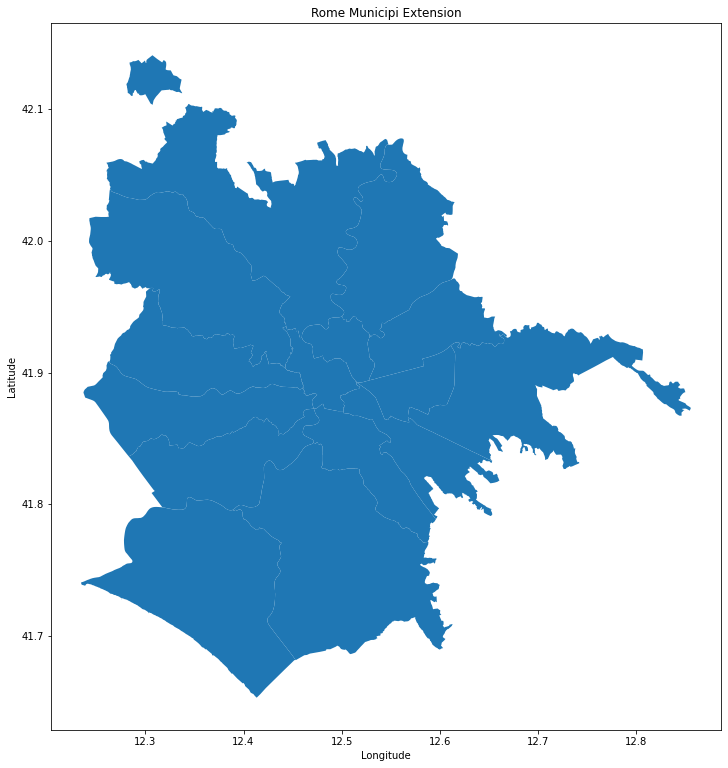

In [3]:
municipi_shape = gpd.read_file('C:/Users/acer/Documents/Mauro/DataScience/IBM/Roma_Restaurants/File Utili/Municipi_Roma/Municipi_Roma_15_wgs84_1.shp')
municipi_shape.plot(figsize=(18, 13))
plt.title('Rome Municipi Extension')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Let's obtain some demographic data from the wikipedia page "Municipi di Roma" (this up to 31st december 2018)

In [4]:
municipi_wikitable = BeautifulSoup(requests.get('https://it.wikipedia.org/wiki/Municipi_di_Roma').content, 'html.parser')

municipi_df = []

for item in municipi_wikitable.table.find_all('tr')[1:]:
    data = [td.text.strip() for td in item.findAll('td')]
    municipio = data[0]
    population = data[1]
    area = data[2]
    density = data[3]
    municipi_df.append((municipio,population,area,density))
    
municipi_df = pd.DataFrame(municipi_df, columns=['Municipio', 'Population', 'Area', 'Density'])
municipi_df.drop([15,16],inplace=True)
municipi_df['Area'] = municipi_df['Area'].str.replace(',','.').astype(float)
municipi_df['Population'] = municipi_df['Population'].str.replace(' ','').astype(float)
municipi_df['Density'] = municipi_df['Density'].str.replace(' ','').str.replace(',','.').astype(float)
municipi_df['Name'] = municipi_df['Municipio'].str.extract(r'^[IVX]+\s{1}(.+)')
municipi_df['Municipio'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
fixed_columns = [municipi_df.columns[0]] + [municipi_df.columns[-1]] + list(municipi_df.columns[1:4])
municipi_df = municipi_df[fixed_columns]

print("This is the dataframe about demographic informations:")
municipi_df

This is the dataframe about demographic informations:


Municipio                              Name  Population    Area   Density
0           1                    Centro Storico    170328.0   20.09  8478.250
1           2                 Parioli/Nomentano    168410.0   19.66  8566.120
2           3                       Monte Sacro    205832.0   98.03  2099.680
3           4                         Tiburtino    175921.0   48.94  3594.630
4           5             Prenestino/Centocelle    245073.0   26.92  9103.750
5           6                  Roma delle Torri    257556.0  113.88  2261.640
6           7  Appio-Latino/Tuscolana/Cinecittà    307184.0   45.84  6701.220
7           8                      Appia Antica    130784.0   47.15  2773.790
8           9                               Eur    183343.0  183.31  1000.180
9          10                      Ostia/Acilia    231701.0  150.74  1537.090
10         11                 Arvalia/Portuense    155652.0   71.48  2177.563
11         12                       Monte Verde    141141.0   73.07  1931.590
12         13                           Aurelio    133367.0   66.93  1992.630
13         14                       Monte Mario    192000.0  133.55  1437.660
14         15                            Milvio    160795.0  187.31   858.440

## Let's obtain some economical data from the file "Reddito dei Romani (2018)" from the webpage https://www.comune.roma.it/web/it/roma-statistica-benessere-economico1.page

In [5]:
excel_file=pd.ExcelFile('C:/Users/acer/Documents/Mauro/DataScience/IBM/Roma_Restaurants/File Utili/Benessere_economico_DATI2018.xlsx')
Pro_Capita = pd.read_excel(excel_file, 'Tab 13.3')
Pro_Capita.drop([0,1,2,3,19,20,21,22], inplace=True)
Pro_Capita['Municipio'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
Pro_Capita = Pro_Capita.reset_index()
Pro_Capita['Yearly Salary / Per Capita'] = Pro_Capita['Unnamed: 1']
fixed_columns = [Pro_Capita.columns[-2]] + [Pro_Capita.columns[-1]]
Pro_Capita = Pro_Capita[fixed_columns]

print("This is the dataframe about economics informations:")
Pro_Capita

This is the dataframe about economics informations:


Municipio Yearly Salary / Per Capita
0           1                    39011.2
1           2                    41743.8
2           3                    25959.5
3           4                    21759.4
4           5                    19281.5
5           6                    17460.1
6           7                    24717.6
7           8                    28690.2
8           9                    30081.5
9          10                    23031.5
10         11                    21550.8
11         12                      27995
12         13                    24004.9
13         14                    26002.8
14         15                    29603.6

## we merge the two data frame together

In [6]:
Municipi_Data_df = pd.merge(municipi_df,Pro_Capita,on='Municipio')
Municipi_Data_df

Municipio                              Name  Population    Area   Density  \
0           1                    Centro Storico    170328.0   20.09  8478.250   
1           2                 Parioli/Nomentano    168410.0   19.66  8566.120   
2           3                       Monte Sacro    205832.0   98.03  2099.680   
3           4                         Tiburtino    175921.0   48.94  3594.630   
4           5             Prenestino/Centocelle    245073.0   26.92  9103.750   
5           6                  Roma delle Torri    257556.0  113.88  2261.640   
6           7  Appio-Latino/Tuscolana/Cinecittà    307184.0   45.84  6701.220   
7           8                      Appia Antica    130784.0   47.15  2773.790   
8           9                               Eur    183343.0  183.31  1000.180   
9          10                      Ostia/Acilia    231701.0  150.74  1537.090   
10         11                 Arvalia/Portuense    155652.0   71.48  2177.563   
11         12                       Monte Verde    141141.0   73.07  1931.590   
12         13                           Aurelio    133367.0   66.93  1992.630   
13         14                       Monte Mario    192000.0  133.55  1437.660   
14         15                            Milvio    160795.0  187.31   858.440   

   Yearly Salary / Per Capita  
0                     39011.2  
1                     41743.8  
2                     25959.5  
3                     21759.4  
4                     19281.5  
5                     17460.1  
6                     24717.6  
7                     28690.2  
8                     30081.5  
9                     23031.5  
10                    21550.8  
11                      27995  
12                    24004.9  
13                    26002.8  
14                    29603.6

## By looking at the following grapth we can tell that Prenestino/Centocelle Municipio is pretty crowded because it has a very high density and a good amount of people living in it.

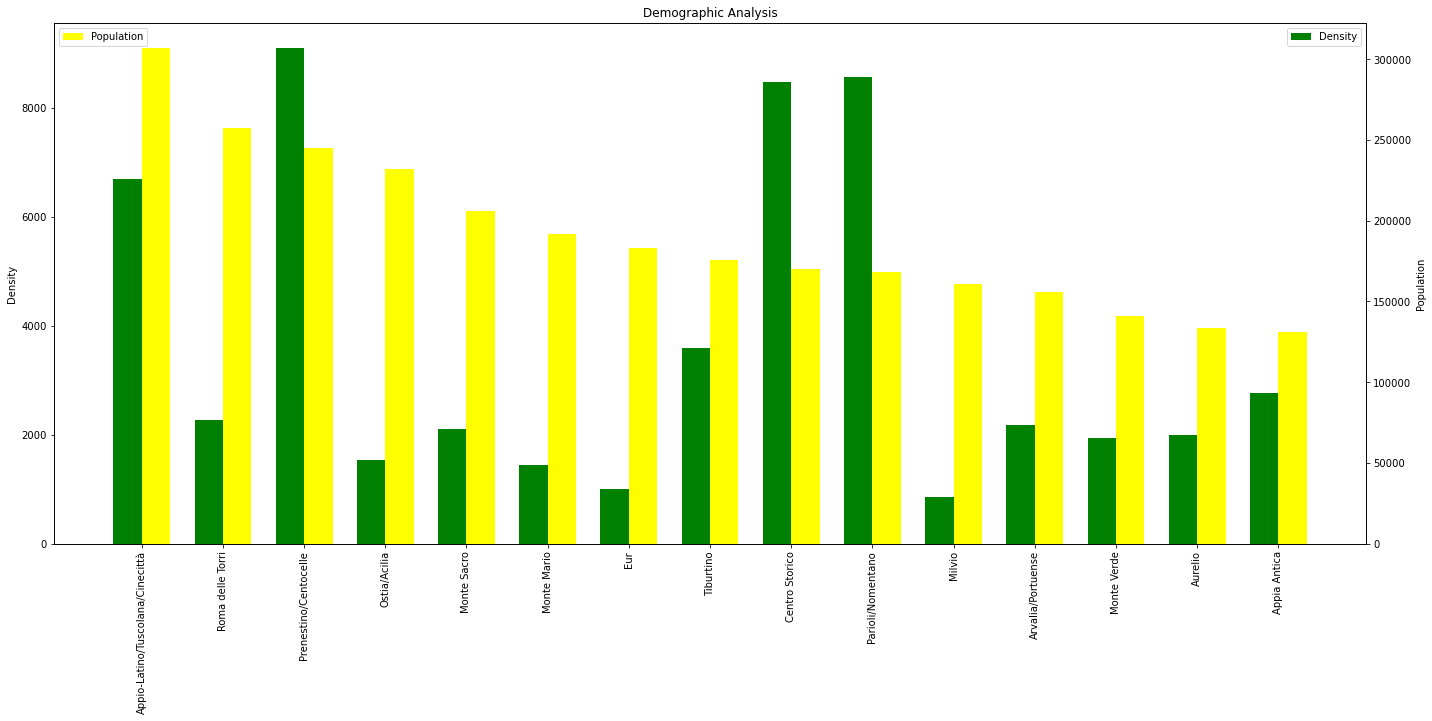

In [7]:
plot_df = Municipi_Data_df.sort_values('Population', ascending=False)
labels = plot_df['Name']
dens = plot_df['Density']
number = plot_df['Population']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams["figure.figsize"] = (20,8)

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.bar(x - width/2, dens, width, label='Density', color='green')
ax_right.bar(x + width/2, number, width, label='Population', color='yellow')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_left.set_ylabel('Density')
ax_right.set_ylabel('Population')
ax_left.set_title('Demographic Analysis')

ax_left.set_xticks(x)
ax_left.set_xticklabels(labels)
ax_left.legend()
ax_right.legend(loc='upper left')


fig.tight_layout()

for tick in ax_left.get_xticklabels():
    tick.set_rotation(90)

plt.show()

## Plotting the Average Income gives us a better idea about the wealthy area in Rome

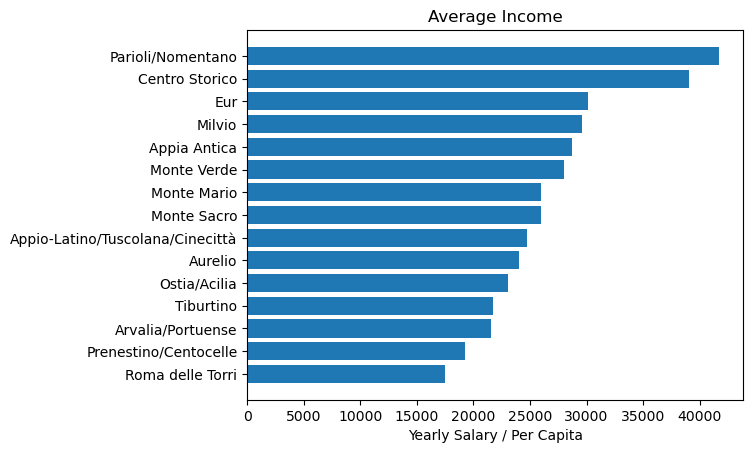

In [8]:
plt.rcdefaults()
fig, ax = plt.subplots()

plot_df = Municipi_Data_df.sort_values('Yearly Salary / Per Capita')

Name = plot_df['Name']
y_pos = np.arange(len(Name))
Nums = plot_df['Yearly Salary / Per Capita']

ax.barh(y_pos,Nums)
ax.set_yticks(y_pos)
ax.set_yticklabels(Name)
ax.set_title('Average Income')
ax.set_xlabel('Yearly Salary / Per Capita')

plt.show()

## Retrieving Restaurants information from Foursquare
## Since Foursquare has a limitation in numbers of outputs per each request I am creating a grid of points

In [182]:
t_lon = 12.60
lon_list=[]
for x in range(0,22):
    t_lon = 12.60 - (x/100)
    lon_list.append(t_lon)
t_lat = 41.97
lat_list=[]
for x in range(0,17):
    t_lat = 41.97 - (x/100)
    lat_list.append(t_lat)

In [183]:
map_Rome = folium.Map(location=[RM_latitude, RM_longitude], zoom_start=12)

x=0
y=0
for x in range(0,17):
    for y in range(0,22):
        folium.CircleMarker(
                [lat_list[x], lon_list[y]],
                radius=5,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(map_Rome) 
        

map_Rome

In [13]:
CLIENT_ID = '******' # Cancelled for security reasons
CLIENT_SECRET = '******' # Cancelled for security reasons
ACCESS_TOKEN = '*******' # Cancelled for security reasons
VERSION = '20180323' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value
radius=500

## Let's retrieve some information about Restasurants using Foursquare. 
### I limit the request only on the "FOOD" Category

In [50]:
cat_id = '4d4b7105d754a06374d81259'     #food category
venues_list=[]
x=0
y=0
count=0

for x in range(0,17):
    for y in range(0,22):
        
        
        url_get = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
            cat_id, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat_list[x], 
            lon_list[y],
            ACCESS_TOKEN, 
            VERSION, 
            radius, 
            LIMIT)
        
        results = requests.get(url_get).json()
        check = results['meta']
        #print(check)
        
        grid_coeff = (x*100)+y
                
        for p in range(0,LIMIT):
            try:
                venue_name = results["response"]['venues'][p]['name'] #venue name
                count=count+1
            except:
                venue_name = "NA"
            try:
                venue_address = results["response"]['venues'][p]['location']['address'] #venue address
            except:
                venue_address = "NA"
            try:
                venue_lat = results["response"]['venues'][p]['location']['lat'] #venue latitude
            except:
                venue_lat = "NA"
            try:
                venue_lon = results["response"]['venues'][p]['location']['lng'] #venue longitude
            except:
                venue_lon = "NA"
            try:
                venue_CAP = results["response"]['venues'][p]['location']['postalCode'] #CAP
            except:
                venue_CAP = "NA"
            try:
                venue_cat = results["response"]['venues'][p]['categories'][0]['name'] #venue category
            except:
                venue_cat = "NA"
            try:
                venue_cat_id = results["response"]['venues'][p]['categories'][0]['id'] #venue cat id
            except:
                venue_cat_id = "NA"
            try:
                venue_id = results["response"]['venues'][p]['id'] #venue id
            except:
                venue_id = "NA"
                
        
        
            venues_list.append([(
            venue_name, 
            venue_address, 
            venue_lat, 
            venue_lon, 
            venue_CAP, 
            venue_cat,
            grid_coeff,
            venue_cat_id,
            venue_id)])

            Restaurant_RAW_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            Restaurant_RAW_df.columns = ['Name', 
                          'Address', 
                          'Latitude', 
                          'Longitude',
                          'CAP',
                          'Category',
                          'Grid Coefficient', 
                          'Category ID',
                          'Venue ID']
            
       # print("Index Y value is: {}".format(y))
            
    print("Index X value is: {}".format(x))
    


Index X value is: 0
Index X value is: 1
Index X value is: 2
Index X value is: 3
Index X value is: 4
Index X value is: 5
Index X value is: 6
Index X value is: 7
Index X value is: 8
Index X value is: 9
Index X value is: 10
Index X value is: 11
Index X value is: 12
Index X value is: 13
Index X value is: 14
Index X value is: 15
Index X value is: 16


### The Grid Coefficient is a unique value for each of the grid's points that I used to retrieve the data from Foursquare. 
### I used this value to fill all the missing CAP. I grouped the restaurants by Grid Coefficient and gave them the same CAP value since they come from the same area.

In [109]:
Restaurant_RAW_df

Name                         Address   Latitude  \
0                     Bar Sodano             Via Nomentana, 1412  41.968716   
1         maki cucina Giapponese                             NaN  41.966124   
2                       Kalimera        Via Di Casal Boccone 283  41.967291   
3                   Che Te Ne Sa               Via bufalotta 891  41.970358   
4              The Butcher House                             NaN  41.971517   
...                          ...                             ...        ...   
7684                 Bar Aladino                             NaN  41.808265   
7685                 Jack Bullet   Viale Salvatore Rebecchini, 3  41.815161   
7686     Ristorante Rinascimento  Sheraton Golf Parco de' Medici  41.814951   
7687  Ristorante dei Condottieri                             NaN  41.814056   
7688     Antica Biblioteca Valle      Largo Teatro Della Valle 9  41.815076   

      Longitude    CAP               Category ID                  Category  
0     12.604666    NaN  4bf58dd8d48988d16d941735                      Café  
1     12.602642    NaN  4bf58dd8d48988d1d1941735              Noodle House  
2     12.554955  00137  4bf58dd8d48988d16d941735                      Café  
3     12.550154    NaN  4bf58dd8d48988d110941735        Italian Restaurant  
4     12.550375  00139  4bf58dd8d48988d16c941735              Burger Joint  
...         ...    ...                       ...                       ...  
7684  12.413944  00144  4bf58dd8d48988d16d941735                      Café  
7685  12.411920  00148  4bf58dd8d48988d147941735                     Diner  
7686  12.399995  00148  4bf58dd8d48988d1c0941735  Mediterranean Restaurant  
7687  12.397716    NaN  4bf58dd8d48988d143941735            Breakfast Spot  
7688  12.400111    NaN  4bf58dd8d48988d1c4941735                Restaurant  

[7689 rows x 7 columns]

## The Restaurants_RAW dataframe needed a lot of cleaning and filling of information. This took a while and I saved a csv file which I am now reading
## The database contains 6431 restaurants

In [9]:
file = 'Rome_Restaurant_Cleaned.csv'    #Cleaned and ready to use Restaurant database
Restaurants_df = pd.read_csv(file)
Restaurants_df.drop(Restaurants_df.columns[0], axis=1, inplace=True)
Restaurants_df

Name                        Address   Latitude  \
0                       Kalimera       Via Di Casal Boccone 283  41.967291   
1                  La Mangiatoia         Via dei Due Ponti, 181  41.965430   
2                     Sport Cafè                Via cassia 1001  41.973301   
3                   La Graticola               Via Cassia, 1054  41.974827   
4         Gelateria Il Pellicano               Via Cassia 999/c  41.973329   
...                          ...                            ...        ...   
6426                 The Village         Viale Parco de' Medici  41.815153   
6427               La Piadineria                            NaN  41.814774   
6428                 Pizza Space                            NaN  41.815371   
6429                 Jack Bullet  Viale Salvatore Rebecchini, 3  41.815161   
6430  Ristorante dei Condottieri                            NaN  41.814056   

      Longitude    CAP            Category  Grid Coefficient  \
0     12.554955  00137                Café               4.0   
1     12.459590  00189  Italian Restaurant              14.0   
2     12.429365  00189                Café              17.0   
3     12.426693  00189  Seafood Restaurant              17.0   
4     12.429833  00189      Ice Cream Shop              17.0   
...         ...    ...                 ...               ...   
6426  12.411915  00148                Food            1619.0   
6427  12.411353  00148   Emilia Restaurant            1619.0   
6428  12.412148  00144         Pizza Place            1619.0   
6429  12.411920  00148               Diner            1619.0   
6430  12.397716  00148      Breakfast Spot            1620.0   

                   Category ID                  Venue ID  
0     4bf58dd8d48988d16d941735  50ed252ee4b0218313a9fed0  
1     4bf58dd8d48988d110941735  4d0133991ebe6dcb18f08b91  
2     4bf58dd8d48988d16d941735  4cab61f714c33704f831ea3b  
3     4bf58dd8d48988d1ce941735  4d90e53f3bfef04dd062cd86  
4     4bf58dd8d48988d1c9941735  4de2bba945dd180ae54e1180  
...                        ...                       ...  
6426  4d4b7105d754a06374d81259  4def5e62b0fbe76bc3c14978  
6427  55a5a1ebe4b013909087cb89  586c0240a55db03737341ed6  
6428  4bf58dd8d48988d1ca941735  51950955498e685d443bb0e0  
6429  4bf58dd8d48988d147941735  4c7ab34c81bca0934e470115  
6430  4bf58dd8d48988d143941735  518a999c498eb64d2b5b0f9f  

[6431 rows x 9 columns]

### By using the coordinates of each restaurant I can determine in which Municipio they are.
### I can do this by checking if their positions is contained in any of the polygon of the shape file

In [10]:
i=0
temp_list = []
Restaurants_municipi = pd.DataFrame(columns=['Name','Municipio'])
for R in Restaurants_df['Name']:
    x=0
    plat = Restaurants_df['Latitude'].loc[i]
    plng = Restaurants_df['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in municipi_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
            if x==15:
                mun=0
                temp_list.append([(R,mun)]) 
        else:
            mun = municipi_shape['municipio'].loc[x]
            temp_list.append([(R,mun)])       

    i=i+1
temp_list
Restaurants_municipi = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Restaurants_municipi.columns = ['Name','Municipio']
Restaurants_municipi

Name Municipio
0                       Kalimera         3
1                  La Mangiatoia        15
2                     Sport Cafè        15
3                   La Graticola        15
4         Gelateria Il Pellicano        15
...                          ...       ...
6426                 The Village        11
6427               La Piadineria        11
6428                 Pizza Space        11
6429                 Jack Bullet        11
6430  Ristorante dei Condottieri        11

[6431 rows x 2 columns]

In [11]:
Restaurants_merged_df = pd.merge(Restaurants_df,Restaurants_municipi, on='Name', how='inner')
print('OK! Now we merged the Municipio indformation into the main Data Frame')
Restaurants_merged_df.drop_duplicates(subset='Venue ID', keep='first', inplace=True)
Restaurants_merged_df.reset_index(inplace=True)
Restaurants_merged_df.drop(columns='index', inplace=True)
Restaurants_merged_df
Restaurants_merged_df

OK! Now we merged the Municipio indformation into the main Data Frame


Name                        Address   Latitude  \
0                       Kalimera       Via Di Casal Boccone 283  41.967291   
1                  La Mangiatoia         Via dei Due Ponti, 181  41.965430   
2                     Sport Cafè                Via cassia 1001  41.973301   
3                   La Graticola               Via Cassia, 1054  41.974827   
4         Gelateria Il Pellicano               Via Cassia 999/c  41.973329   
...                          ...                            ...        ...   
6426                That's Amore  Viale Salvatore Rebecchini, 3  41.815138   
6427                 The Village         Viale Parco de' Medici  41.815153   
6428                 Pizza Space                            NaN  41.815371   
6429                 Jack Bullet  Viale Salvatore Rebecchini, 3  41.815161   
6430  Ristorante dei Condottieri                            NaN  41.814056   

      Longitude    CAP            Category  Grid Coefficient  \
0     12.554955  00137                Café               4.0   
1     12.459590  00189  Italian Restaurant              14.0   
2     12.429365  00189                Café              17.0   
3     12.426693  00189  Seafood Restaurant              17.0   
4     12.429833  00189      Ice Cream Shop              17.0   
...         ...    ...                 ...               ...   
6426  12.411929  00148         Pizza Place            1619.0   
6427  12.411915  00148                Food            1619.0   
6428  12.412148  00144         Pizza Place            1619.0   
6429  12.411920  00148               Diner            1619.0   
6430  12.397716  00148      Breakfast Spot            1620.0   

                   Category ID                  Venue ID Municipio  
0     4bf58dd8d48988d16d941735  50ed252ee4b0218313a9fed0         3  
1     4bf58dd8d48988d110941735  4d0133991ebe6dcb18f08b91        15  
2     4bf58dd8d48988d16d941735  4cab61f714c33704f831ea3b        15  
3     4bf58dd8d48988d1ce941735  4d90e53f3bfef04dd062cd86        15  
4     4bf58dd8d48988d1c9941735  4de2bba945dd180ae54e1180        15  
...                        ...                       ...       ...  
6426  4bf58dd8d48988d1ca941735  4c121f63b2510f47dd00c498        11  
6427  4d4b7105d754a06374d81259  4def5e62b0fbe76bc3c14978        11  
6428  4bf58dd8d48988d1ca941735  51950955498e685d443bb0e0        11  
6429  4bf58dd8d48988d147941735  4c7ab34c81bca0934e470115        11  
6430  4bf58dd8d48988d143941735  518a999c498eb64d2b5b0f9f        11  

[6431 rows x 10 columns]

### Some Restaurants are outside the polygons. Looking at them I found out that they belong to the city of Ciampino. Therefore we can ignore them

In [12]:
Restaurants_merged_df.loc[Restaurants_merged_df['Municipio'] == 0]

Name                  Address  \
2143                                          NaN                      NaN   
6326                          Mad Cow & Mad Pizza  Via Lucrezia Romana, 65   
6327                                Diamond Caffè          Via G. Spada, 2   
6328                          Pizzeria Il Boccale    Via J. F. Kennedy 109   
6329                                Pizza al Volo                      NaN   
6330                            così é se vi pare                      NaN   
6331                            Così è se vi Pare    Via Giuseppe Spada, 2   
6332  Renata Corporation (di Mimmo e Camillo SPA)         via Petrarca, 42   
6333                            La casa del dolce                      NaN   
6334                                  Quantum Bar                      NaN   
6335                                       bar 3g                      NaN   
6336                  Ristorante Pizzeria Quantum                      NaN   
6337                                Pizza Service          Via Mario Calo'   
6338                              Casa der Frappa          Via Petrarca 42   
6340                                pizzeria omar                      NaN   
6341                                     sicaffe'                      NaN   
6342                          La Romanina SushiCo         Via Enrico FERRI   
6343                                 Pronto Pizza    Via Giuseppe Verdi 25   
6344                                    JOLLY BAR                      NaN   
6345                                     Da Mimmo                      NaN   
6348                         Festa Del Ciiccolato                      NaN   

       Latitude  Longitude    CAP            Category  Grid Coefficient  \
2143        NaN        NaN  00155                 NaN               NaN   
6326  41.810165  12.599419  00043          Steakhouse            1600.0   
6327  41.809300  12.599820  00043                 Bar            1600.0   
6328  41.808376  12.597586  00041         Pizza Place            1600.0   
6329  41.809258  12.593999  00043         Pizza Place            1600.0   
6330  41.809490  12.599828  00043  Italian Restaurant            1600.0   
6331  41.809372  12.600096  00043  Italian Restaurant            1600.0   
6332  41.807501  12.602639  00043              Office            1600.0   
6333  41.808904  12.601572  00043        Cupcake Shop            1600.0   
6334  41.805808  12.600187  00043                Café            1600.0   
6335  41.804568  12.600235  00043                Café            1600.0   
6336  41.805702  12.604275  00043         Pizza Place            1600.0   
6337  41.805592  12.602379  00043         Pizza Place            1600.0   
6338  41.807759  12.604991  00043          Strip Club            1600.0   
6340  41.807223  12.598719  00043         Pizza Place            1600.0   
6341  41.805351  12.598608  00043                Café            1600.0   
6342  41.809803  12.599038  00043    Asian Restaurant            1600.0   
6343  41.806780  12.595169  00043         Pizza Place            1600.0   
6344  41.809613  12.592666  00178                Café            1601.0   
6345  41.809853  12.592905  00043  Italian Restaurant            1601.0   
6348  41.809526  12.591449  00178        Cupcake Shop            1601.0   

                   Category ID                  Venue ID Municipio  
2143                       NaN                       NaN         0  
6326  4bf58dd8d48988d1cc941735  52f5435e11d2bcfe7c6dc5bd         0  
6327  4bf58dd8d48988d116941735  518cc3f6498e5f4607e55c7c         0  
6328  4bf58dd8d48988d1ca941735  4e81a39d93ad414533accf71         0  
6329  4bf58dd8d48988d1ca941735  52448005498e734702274f0a         0  
6330  4bf58dd8d48988d110941735  528e646a11d233883870842a         0  
6331  4bf58dd8d48988d110941735  532e03bf498efa25dc91d54b         0  
6332  4bf58dd8d48988d124941735  4d047d2a92288eecac239be0         0  
6333  4bf58dd8d48988d1bc941735  54993f4f498e29e8a6263c50

## Out of curiosity let's see which is the most common type of Restaurant in Rome.
## No surprises here!

In [13]:
Only_Categories = pd.get_dummies(Restaurants_df[['Category']], prefix="", prefix_sep="")
Frequency_df = pd.DataFrame({'Number of Restaurants' : Only_Categories.sum()})
Top10_Restaurants = Frequency_df.sort_values('Number of Restaurants', ascending=False).head(10)
Top10_Restaurants

Number of Restaurants
Café                                 1485
Pizza Place                           959
Italian Restaurant                    834
Restaurant                            396
Ice Cream Shop                        305
Bakery                                219
Chinese Restaurant                    134
Sandwich Place                        118
Dessert Shop                          109
Diner                                 104

<AxesSubplot:ylabel='Number of Restaurants'>

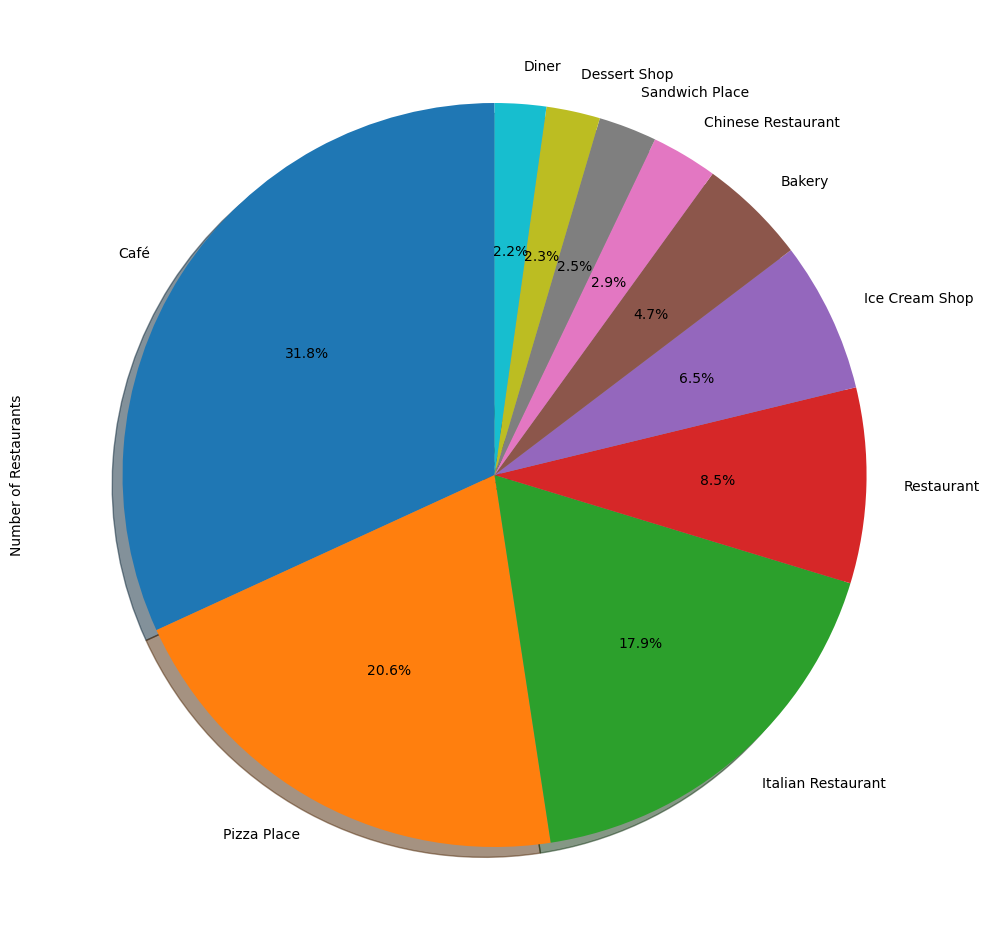

In [14]:
Top10_Restaurants['Number of Restaurants'].plot(kind='pie',
                            figsize=(12, 20),
                            autopct='%1.1f%%',
                            startangle=90,   
                            shadow=True,      
                            )

## Let's see how many restaurants for Municipio

In [14]:
temp = Restaurants_merged_df.groupby('Municipio').count().sort_values('Venue ID', ascending=False)
df_temp = pd.DataFrame(temp)
df_temp['index'] = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14)
df_temp['Municipio'] = df_temp.index.astype('int64')
df_temp = df_temp.set_index('index')
df_temp.drop(df_temp.columns[0:8], axis=1, inplace=True)
df_temp.rename(columns = {'Venue ID' : 'Number of Restaurants'}, inplace=True)
df_temp.dtypes
Municipi_Data_df = pd.merge(Municipi_Data_df,df_temp,left_on='Municipio',right_on='Municipio',how='outer')
Municipi_Data_df

Municipio                              Name  Population    Area   Density  \
0           1                    Centro Storico    170328.0   20.09  8478.250   
1           2                 Parioli/Nomentano    168410.0   19.66  8566.120   
2           3                       Monte Sacro    205832.0   98.03  2099.680   
3           4                         Tiburtino    175921.0   48.94  3594.630   
4           5             Prenestino/Centocelle    245073.0   26.92  9103.750   
5           6                  Roma delle Torri    257556.0  113.88  2261.640   
6           7  Appio-Latino/Tuscolana/Cinecittà    307184.0   45.84  6701.220   
7           8                      Appia Antica    130784.0   47.15  2773.790   
8           9                               Eur    183343.0  183.31  1000.180   
9          10                      Ostia/Acilia    231701.0  150.74  1537.090   
10         11                 Arvalia/Portuense    155652.0   71.48  2177.563   
11         12                       Monte Verde    141141.0   73.07  1931.590   
12         13                           Aurelio    133367.0   66.93  1992.630   
13         14                       Monte Mario    192000.0  133.55  1437.660   
14         15                            Milvio    160795.0  187.31   858.440   
15          0                               NaN         NaN     NaN       NaN   

   Yearly Salary / Per Capita  Number of Restaurants  
0                     39011.2                  860.0  
1                     41743.8                  723.0  
2                     25959.5                  627.0  
3                     21759.4                  406.0  
4                     19281.5                  535.0  
5                     17460.1                   63.0  
6                     24717.6                  694.0  
7                     28690.2                  467.0  
8                     30081.5                  342.0  
9                     23031.5                    NaN  
10                    21550.8                  307.0  
11                      27995                  395.0  
12                    24004.9                  320.0  
13                    26002.8                  396.0  
14                    29603.6                  275.0  
15                        NaN                   20.0

In [15]:
Municipi_Data_df['Restaurant/Square KM'] = Municipi_Data_df['Number of Restaurants'] / Municipi_Data_df['Area']
Municipi_Data_df['Person/Restaurant'] = Municipi_Data_df['Population'] / Municipi_Data_df['Number of Restaurants']
Municipi_Data_df

Municipio                              Name  Population    Area   Density  \
0           1                    Centro Storico    170328.0   20.09  8478.250   
1           2                 Parioli/Nomentano    168410.0   19.66  8566.120   
2           3                       Monte Sacro    205832.0   98.03  2099.680   
3           4                         Tiburtino    175921.0   48.94  3594.630   
4           5             Prenestino/Centocelle    245073.0   26.92  9103.750   
5           6                  Roma delle Torri    257556.0  113.88  2261.640   
6           7  Appio-Latino/Tuscolana/Cinecittà    307184.0   45.84  6701.220   
7           8                      Appia Antica    130784.0   47.15  2773.790   
8           9                               Eur    183343.0  183.31  1000.180   
9          10                      Ostia/Acilia    231701.0  150.74  1537.090   
10         11                 Arvalia/Portuense    155652.0   71.48  2177.563   
11         12                       Monte Verde    141141.0   73.07  1931.590   
12         13                           Aurelio    133367.0   66.93  1992.630   
13         14                       Monte Mario    192000.0  133.55  1437.660   
14         15                            Milvio    160795.0  187.31   858.440   
15          0                               NaN         NaN     NaN       NaN   

   Yearly Salary / Per Capita  Number of Restaurants  Restaurant/Square KM  \
0                     39011.2                  860.0             42.807367   
1                     41743.8                  723.0             36.775178   
2                     25959.5                  627.0              6.396001   
3                     21759.4                  406.0              8.295872   
4                     19281.5                  535.0             19.873700   
5                     17460.1                   63.0              0.553214   
6                     24717.6                  694.0             15.139616   
7                     28690.2                  467.0              9.904560   
8                     30081.5                  342.0              1.865692   
9                     23031.5                    NaN                   NaN   
10                    21550.8                  307.0              4.294908   
11                      27995                  395.0              5.405775   
12                    24004.9                  320.0              4.781115   
13                    26002.8                  396.0              2.965182   
14                    29603.6                  275.0              1.468154   
15                        NaN                   20.0                   NaN   

    Person/Restaurant  
0          198.055814  
1          232.932227  
2          328.280702  
3          433.302956  
4          458.080374  
5         4088.190476  
6          442.628242  
7          280.051392  
8          536.090643  
9                 NaN  
10         507.009772  
11         357.318987  
12         416.771875  
13         484.848485  
14         584.709091  
15                NaN

### Let's have some more detail and find out how many Japanese and Chinese Restaurants there are in Rome

In [16]:
Japanese_id_list = ['4bf58dd8d48988d111941735',
                    '55a59bace4b013909087cb30',
                    '55a59bace4b013909087cb24',
                    '55a59bace4b013909087cb15',
                    '55a59bace4b013909087cb27',
                    '4bf58dd8d48988d1d2941735',
                    '55a59bace4b013909087cb2a',]
Chinese_id_list = ['4bf58dd8d48988d145941735',
              '52af3a7c3cf9994f4e043bed',
              '58daa1558bbb0b01f18ec1d3',
              '4bf58dd8d48988d1f5931735',
              '52af3b773cf9994f4e043c03',]

In [17]:
temp_dic = {}
R = len(Japanese_id_list)
for i in range(R):
    temp_dic[i] = Restaurants_merged_df.loc[Restaurants_merged_df['Category ID'] == Japanese_id_list[i]]

temp_df_1 = temp_dic[0]
temp_df_2 = temp_dic[1]
temp_df_3 = temp_dic[2]
temp_df_4 = temp_dic[3]
temp_df_5 = temp_dic[4]
temp_df_6 = temp_dic[5]
temp_df_7 = temp_dic[6]
frames = [temp_df_1, temp_df_2, temp_df_3, temp_df_4, temp_df_5, temp_df_6, temp_df_7]
Japanese_Restaurants_df = pd.concat(frames)
Japanese_Restaurants_df = Japanese_Restaurants_df.reset_index()
Japanese_Restaurants_df.drop(Japanese_Restaurants_df.columns[0], axis=1, inplace=True)
Japanese_Restaurants_df['Municipio'] = Japanese_Restaurants_df['Municipio'].astype('int64')
Japanese_Restaurants_df

Name                   Address   Latitude  \
0                      Yuzu Cassia                       NaN  41.968032   
1                           Arashi           Via Cassia, 923  41.971027   
2                         La Gioia  Via Renato Fucini, 244/C  41.948050   
3                       Yume Sushi      Via Renato Fucini 66  41.951738   
4          Shinto Sushi Restaurant              Via Riano 35  41.949639   
..                             ...                       ...        ...   
100                           Jiro    9 Viale del Caravaggio  41.851016   
101                      Han Sushi                       NaN  41.849900   
102              Sushi Jo Anagnina            Via Anagnina 3  41.839658   
103     Yama Ristorante Giapponese                       NaN  41.832760   
104  Daruma Sushi Restaurant - Eur          Viale America, 9  41.831542   

     Longitude    CAP             Category  Grid Coefficient  \
0    12.438601  00189  Japanese Restaurant              16.0   
1    12.434028  00189  Japanese Restaurant              16.0   
2    12.550652  00137  Japanese Restaurant             205.0   
3    12.547020  00137  Japanese Restaurant             205.0   
4    12.466169  00191  Japanese Restaurant             213.0   
..         ...    ...                  ...               ...   
100  12.493761  00147     Sushi Restaurant            1211.0   
101  12.460208  00146     Sushi Restaurant            1214.0   
102  12.588540  00173     Sushi Restaurant            1301.0   
103  12.491291  00142     Sushi Restaurant            1411.0   
104  12.461676  00144     Sushi Restaurant            1414.0   

                  Category ID                  Venue ID  Municipio  
0    4bf58dd8d48988d111941735  5e24578edaee0b0008386e94         15  
1    4bf58dd8d48988d111941735  4c17e640fe5a76b07d3f0115         15  
2    4bf58dd8d48988d111941735  4bc633dbb387d13aec79c1e8          3  
3    4bf58dd8d48988d111941735  57547a3e498efe9dae6ba79c          3  
4    4bf58dd8d48988d111941735  56b8a76e498e74a4ea610116         15  
..                        ...                       ...        ...  
100  4bf58dd8d48988d1d2941735  5cdc691b492814002c975546          8  
101  4bf58dd8d48988d1d2941735  5e2c989949dccb0008879ac8         11  
102  4bf58dd8d48988d1d2941735  5f5fb78ea154fa03f760eeaf          7  
103  4bf58dd8d48988d1d2941735  5dcaaf763f05280007dfdfec          8  
104  4bf58dd8d48988d1d2941735  4bebe9f562c0c9280fa0e2d4          9  

[105 rows x 10 columns]

In [18]:
temp_dic = {}
R = len(Chinese_id_list)
for i in range(R):
    temp_dic[i] = Restaurants_merged_df.loc[Restaurants_merged_df['Category ID'] == Chinese_id_list[i]]

temp_df_1 = temp_dic[0]
temp_df_2 = temp_dic[1]
temp_df_3 = temp_dic[2]
temp_df_4 = temp_dic[3]
temp_df_5 = temp_dic[4]
frames = [temp_df_1, temp_df_2, temp_df_3, temp_df_4, temp_df_5]
Chinese_Restaurants_df = pd.concat(frames)
Chinese_Restaurants_df = Chinese_Restaurants_df.reset_index()
Chinese_Restaurants_df.drop(Chinese_Restaurants_df.columns[0], axis=1, inplace=True)
Chinese_Restaurants_df['Municipio'] = Chinese_Restaurants_df['Municipio'].astype('int64')
Chinese_Restaurants_df

Name                              Address  \
0                 Bastoncini D'Oro                      Via Cassia, 744   
1      Ristorante cinese "Jin Hao"      Via della Palmarola Nuova, 31/A   
2    Prosperita' Ristorante Cinese              Via di Grottarossa, 169   
3                      Prosperita'                   Via Longone Sabino   
4                      La Felicità                                  NaN   
..                             ...                                  ...   
131                          Wok 2               Via Cesare Pavese, 301   
132               Cinese Vittorini                   Via Elio Vittorini   
133                        Jing Du  Viale Beata Vergine Del Carmelo, 17   
134               Piccola Cambogia                                  NaN   
135             一餐厅 One Restaurant                    via Tuscolana 623   

      Latitude  Longitude    CAP             Category  Grid Coefficient  \
0    41.965471  12.443076  00189   Chinese Restaurant             116.0   
1    41.948250  12.391058  00135   Chinese Restaurant             221.0   
2    41.973279  12.442160  00189   Chinese Restaurant              16.0   
3    41.973335  12.442116  00189   Chinese Restaurant              16.0   
4    41.963141  12.531548  00139   Chinese Restaurant             107.0   
..         ...        ...    ...                  ...               ...   
131  41.816606  12.471194  00144   Chinese Restaurant            1513.0   
132  41.813891  12.485022  00143   Chinese Restaurant            1611.0   
133  41.808725  12.445388  00144   Chinese Restaurant            1615.0   
134  41.882673  12.506779  00183   Dim Sum Restaurant             910.0   
135  41.863128  12.551012  00174  Szechuan Restaurant            1105.0   

                  Category ID                  Venue ID  Municipio  
0    4bf58dd8d48988d145941735  4ca3964ed5a2a143a9ad4a90         15  
1    4bf58dd8d48988d145941735  4e25c017aeb7df1e0f4c7029         14  
2    4bf58dd8d48988d145941735  4d84ff6b8de9721e8a753d51         15  
3    4bf58dd8d48988d145941735  4e57edfa1f6e2a1922ddec98         15  
4    4bf58dd8d48988d145941735  52af408611d2db47171e3993          3  
..                        ...                       ...        ...  
131  4bf58dd8d48988d145941735  4c3e0eafca012d7f1df52ebe          9  
132  4bf58dd8d48988d145941735  51aa4a97498ea24ab6f82a17          9  
133  4bf58dd8d48988d145941735  4c8bc72eed3ab60c52586121          9  
134  4bf58dd8d48988d1f5931735  51f17a45498ef31ac51e52b7          7  
135  52af3b773cf9994f4e043c03  5d62e67feab7f80007d23108          7  

[136 rows x 10 columns]

In [19]:
temp = Japanese_Restaurants_df.groupby('Municipio').count().sort_values('Venue ID', ascending=False)
df_temp = pd.DataFrame(temp)
df_temp['index'] = (0,1,2,3,4,5,6,7,8,9,10,11,12)
df_temp['Municipio'] = df_temp.index.astype('int64')
df_temp = df_temp.set_index('index')
df_temp.drop(df_temp.columns[0:8], axis=1, inplace=True)
df_temp.rename(columns = {'Venue ID' : 'Number of Japanese Restaurants'}, inplace=True)
df_temp.dtypes
Municipi_Data_df = pd.merge(Municipi_Data_df,df_temp,left_on='Municipio',right_on='Municipio',how='outer')

temp2 = Chinese_Restaurants_df.groupby('Municipio').count().sort_values('Venue ID', ascending=False)
df_temp2 = pd.DataFrame(temp2)
df_temp2['index'] = (0,1,2,3,4,5,6,7,8,9,10,11,12)
df_temp2['Municipio'] = df_temp2.index.astype('int64')
df_temp2 = df_temp2.set_index('index')
df_temp2.drop(df_temp2.columns[0:8], axis=1, inplace=True)
df_temp2.rename(columns = {'Venue ID' : 'Number of Chinese Restaurants'}, inplace=True)
df_temp2.dtypes
Municipi_Data_df = pd.merge(Municipi_Data_df,df_temp2,left_on='Municipio',right_on='Municipio',how='outer')

Municipi_Data_df.drop([9,15], axis=0, inplace=True)
Municipi_Data_df = Municipi_Data_df.reset_index()
Municipi_Data_df.drop(Municipi_Data_df.columns[0], axis=1, inplace=True)
Municipi_Data_df.at[5,'Number of Japanese Restaurants'] = 0
Municipi_Data_df.at[5,'Number of Chinese Restaurants'] = 0
Municipi_Data_df

Municipio                              Name  Population    Area   Density  \
0           1                    Centro Storico    170328.0   20.09  8478.250   
1           2                 Parioli/Nomentano    168410.0   19.66  8566.120   
2           3                       Monte Sacro    205832.0   98.03  2099.680   
3           4                         Tiburtino    175921.0   48.94  3594.630   
4           5             Prenestino/Centocelle    245073.0   26.92  9103.750   
5           6                  Roma delle Torri    257556.0  113.88  2261.640   
6           7  Appio-Latino/Tuscolana/Cinecittà    307184.0   45.84  6701.220   
7           8                      Appia Antica    130784.0   47.15  2773.790   
8           9                               Eur    183343.0  183.31  1000.180   
9          11                 Arvalia/Portuense    155652.0   71.48  2177.563   
10         12                       Monte Verde    141141.0   73.07  1931.590   
11         13                           Aurelio    133367.0   66.93  1992.630   
12         14                       Monte Mario    192000.0  133.55  1437.660   
13         15                            Milvio    160795.0  187.31   858.440   

   Yearly Salary / Per Capita  Number of Restaurants  Restaurant/Square KM  \
0                     39011.2                  860.0             42.807367   
1                     41743.8                  723.0             36.775178   
2                     25959.5                  627.0              6.396001   
3                     21759.4                  406.0              8.295872   
4                     19281.5                  535.0             19.873700   
5                     17460.1                   63.0              0.553214   
6                     24717.6                  694.0             15.139616   
7                     28690.2                  467.0              9.904560   
8                     30081.5                  342.0              1.865692   
9                     21550.8                  307.0              4.294908   
10                      27995                  395.0              5.405775   
11                    24004.9                  320.0              4.781115   
12                    26002.8                  396.0              2.965182   
13                    29603.6                  275.0              1.468154   

    Person/Restaurant  Number of Japanese Restaurants  \
0          198.055814                            13.0   
1          232.932227                            22.0   
2          328.280702                             9.0   
3          433.302956                             8.0   
4          458.080374                             3.0   
5         4088.190476                             0.0   
6          442.628242                             9.0   
7          280.051392                            11.0   
8          536.090643                             4.0   
9          507.009772                             6.0   
10         357.318987                             4.0   
11         416.771875                             4.0   
12         484.848485                             6.0   
13         584.709091                             6.0   

    Number of Chinese Restaurants  
0                            19.0  
1                            10.0  
2                            15.0  
3                             5.0  
4                            13.0  
5                             0.0  
6                            23.0  
7                             6.0  
8                             7.0  
9                             6.0  
10                            7.0  
11                            9.0  
12                           12.0  
13                            4.0

### The plot below gives a better idea of how Restaurants are distribuited in rome.
####               860 in the City Center (Centro Storico)
####               723 in Parioli Nomentano area
####               694 in Appio Tuscolano

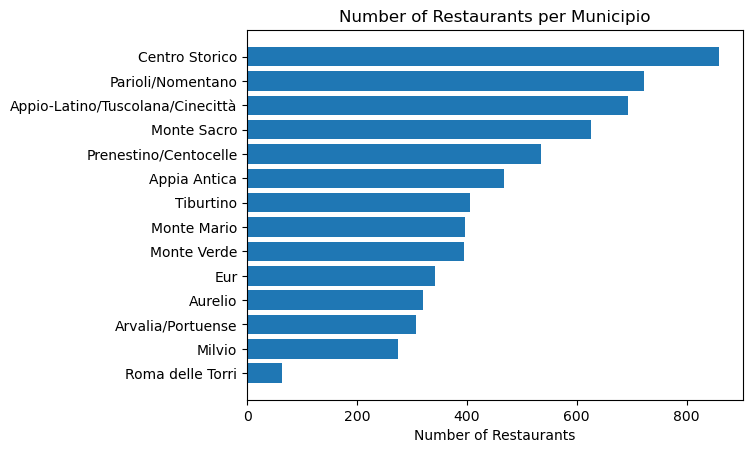

In [20]:
plt.rcdefaults()
fig, ax = plt.subplots()

plot_df = Municipi_Data_df.sort_values('Number of Restaurants')

Name = plot_df['Name']
y_pos = np.arange(len(Name))
Nums = plot_df['Number of Restaurants']

ax.barh(y_pos,Nums)
ax.set_yticks(y_pos)
ax.set_yticklabels(Name)
ax.set_title('Number of Restaurants per Municipio')
ax.set_xlabel('Number of Restaurants')

plt.show()

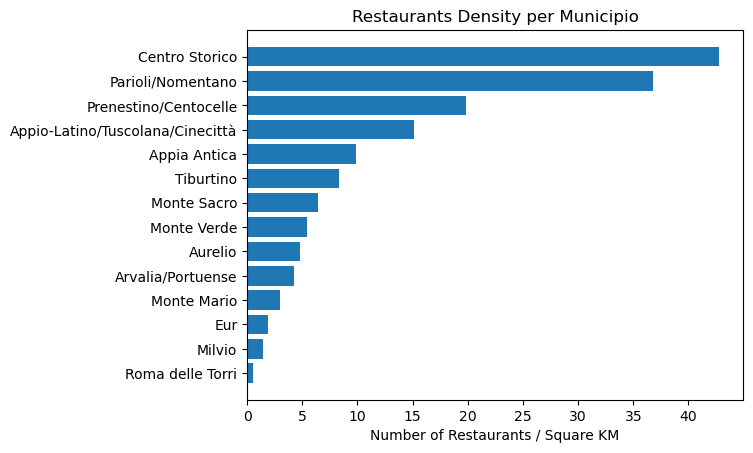

In [21]:
plt.rcdefaults()
fig, ax = plt.subplots()

plot_df = Municipi_Data_df.sort_values('Restaurant/Square KM')

Name = plot_df['Name']
y_pos = np.arange(len(Name))
Nums = plot_df['Restaurant/Square KM']

ax.barh(y_pos,Nums)
ax.set_yticks(y_pos)
ax.set_yticklabels(Name)
ax.set_title('Restaurants Density per Municipio')
ax.set_xlabel('Number of Restaurants / Square KM')

plt.show()

## So far we can tell that Parioli/Nomentano and Centro Storico are not only the most wealthy areas in Rome, but there are also plenty of restaurants that probably serve a huge amount of people, both tourists and inhabitants.

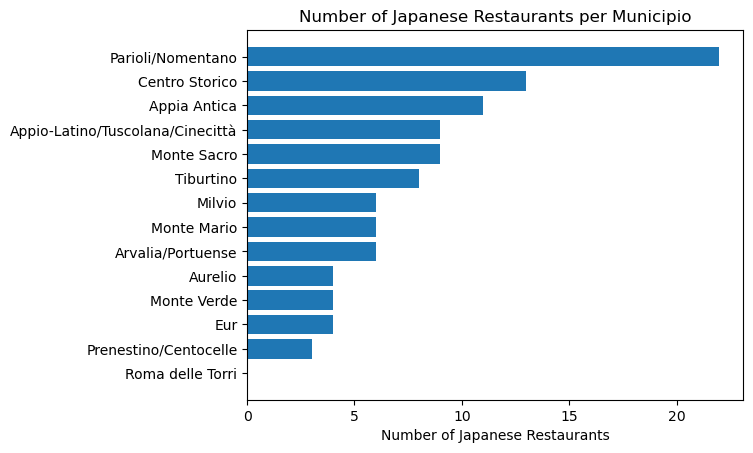

In [22]:
plt.rcdefaults()
fig, ax = plt.subplots()

plot_df = Municipi_Data_df.sort_values('Number of Japanese Restaurants')

Name = plot_df['Name']
y_pos = np.arange(len(Name))
Nums = plot_df['Number of Japanese Restaurants']

ax.barh(y_pos,Nums)
ax.set_yticks(y_pos)
ax.set_yticklabels(Name)
ax.set_title('Number of Japanese Restaurants per Municipio')
ax.set_xlabel('Number of Japanese Restaurants')

plt.show()

## I don't think that it is a surprise that most of the Japanese Restaurants, which are usually expensive, are in these two areas!

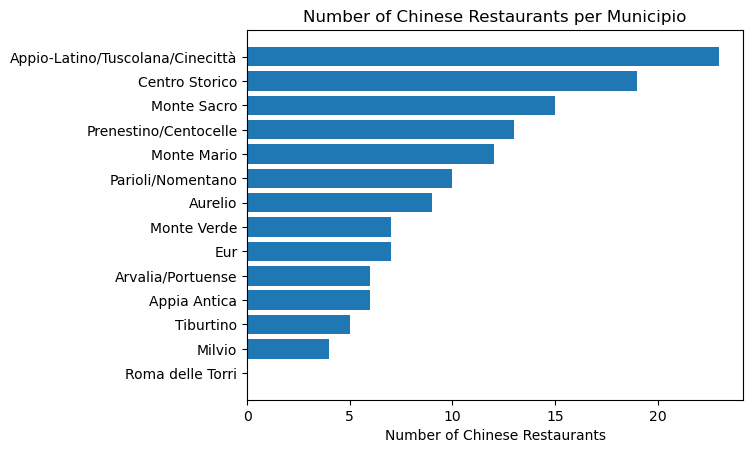

In [23]:
plt.rcdefaults()
fig, ax = plt.subplots()

plot_df = Municipi_Data_df.sort_values('Number of Chinese Restaurants')

Name = plot_df['Name']
y_pos = np.arange(len(Name))
Nums = plot_df['Number of Chinese Restaurants']

ax.barh(y_pos,Nums)
ax.set_yticks(y_pos)
ax.set_yticklabels(Name)
ax.set_title('Number of Chinese Restaurants per Municipio')
ax.set_xlabel('Number of Chinese Restaurants')

plt.show()

## Something interesting here: Prenestino/Centocelle is among the less wealthy areas in Rome but it has a good amount of Chinese Restaurants. This could be a good area.

In [48]:
import json

with open('C:/Users/acer/Documents/Mauro/DataScience/IBM/Roma_Restaurants/File Utili/Municipi_Roma.geojson.txt') as json_file:
    geodata = json.load(json_file)

In [49]:
choropleth_df = pd.read_csv('choropleth_df.csv')
choropleth_df

Unnamed: 0  Municipio                              Name  Population  \
0            0          1                    Centro Storico    170328.0   
1            1          2                 Parioli/Nomentano    168410.0   
2            2          3                       Monte Sacro    205832.0   
3            3          4                         Tiburtino    175921.0   
4            4          5             Prenestino/Centocelle    245073.0   
5            5          6                  Roma delle Torri    257556.0   
6            6          7  Appio-Latino/Tuscolana/Cinecittà    307184.0   
7            7          8                      Appia Antica    130784.0   
8            8          9                               Eur    183343.0   
9            9         11                 Arvalia/Portuense    155652.0   
10          10         12                       Monte Verde    141141.0   
11          11         13                           Aurelio    133367.0   
12          12         14                       Monte Mario    192000.0   
13          13         15                            Milvio    160795.0   

      Area   Density  Yearly Salary / Per Capita  Number of Restaurants  \
0    20.09  8478.250                39011.232472                  860.0   
1    19.66  8566.120                41743.784816                  723.0   
2    98.03  2099.680                25959.520538                  627.0   
3    48.94  3594.630                21759.427651                  406.0   
4    26.92  9103.750                19281.497260                  535.0   
5   113.88  2261.640                17460.053665                   63.0   
6    45.84  6701.220                24717.557293                  694.0   
7    47.15  2773.790                28690.245304                  467.0   
8   183.31  1000.180                30081.517805                  342.0   
9    71.48  2177.563                21550.822023                  307.0   
10   73.07  1931.590                27995.023460                  395.0   
11   66.93  1992.630                24004.926083                  320.0   
12  133.55  1437.660                26002.819904                  396.0   
13  187.31   858.440                29603.591002                  275.0   

    Restaurant/Square KM  Person/Restaurant  Number of Japanese Restaurants  \
0              42.807367         198.055814                            13.0   
1              36.775178         232.932227                            22.0   
2               6.396001         328.280702                             9.0   
3               8.295872         433.302956                             8.0   
4              19.873700         458.080374                             3.0   
5               0.553214        4088.190476                             NaN   
6              15.139616         442.628242                             9.0   
7               9.904560         280.051392                            11.0   
8               1.865692         536.090643                             4.0   
9               4.294908         507.009772                             6.0   
10              5.405775         357.318987                             4.0   
11              4.781115         416.771875                             4.0   
12              2.965182         484.848485                             6.0   
13              1.468154         584.709091                             6.0   

    Number of Chinese Restaurants                      id  \
0                            19.0   limiti_municipiroma.1   
1                            10.0  limiti_municipiroma.10   
2                            15.0  limiti_municipiroma.12   
3                             5.0  limiti_municipiroma.13   
4                            13.0  limiti_municipiroma.14   
5                             NaN  limiti_municipiroma.16   
6                            23.0   limiti_municipiroma.2   
7                             6.0   limiti_municipiroma.3   
8                

## The following map shows the distribution of the population density in Rome.

In [50]:
map_Rome = folium.Map(location=[RM_latitude, RM_longitude], zoom_start=11)

#folium.GeoJson(municipi_shape).add_to(map_Rome)
map_Rome.choropleth(geo_data=geodata,
                   data=choropleth_df,
                   columns=['id','Density'],
                   key_on='feature.id',
                   fill_color='Greens',
                   fill_opacity=0.7, 
                   line_opacity=0.5,
                   legend_name='Density',
                   highlight=True,
                   smooth_factor=0)

locations = choropleth_df[['Latitude','Longitude']].values
names = choropleth_df['Name'].tolist()
nums = choropleth_df['Municipio'].tolist()
density = choropleth_df['Density'].tolist()
popup = '<center><b>Municipio {}</b></br><i>{}</i></br>Density: {:,} PPL/sqkm</center>'
for loc, num, name, dens in zip(locations, nums, names, density):
    folium.Marker(loc, popup=folium.Popup(popup.format(num,name,dens))).add_to(map_Rome)


map_Rome

## The following map shows the distribution of the average yearly salary of the popultion in Rome.

In [56]:
map_Rome = folium.Map(location=[RM_latitude, RM_longitude], zoom_start=11)

#folium.GeoJson(municipi_shape).add_to(map_Rome)
map_Rome.choropleth(geo_data=geodata,
                   data=choropleth_df,
                   columns=['id','Yearly Salary / Per Capita'],
                   key_on='feature.id',
                   fill_color='Blues',
                   fill_opacity=0.7, 
                   line_opacity=0.5,
                   legend_name='Density',
                   highlight=True,
                   smooth_factor=0)

locations = choropleth_df[['Latitude','Longitude']].values
names = choropleth_df['Name'].tolist()
nums = choropleth_df['Municipio'].tolist()
avg_income = choropleth_df['Yearly Salary / Per Capita'].tolist()
popup = '<center><b>Municipio {}</b></br><i>{}</i></br>Avg Income: {} &#8364</center>'
for loc, num, name, inc in zip(locations, nums, names, avg_income):
    inc = int(inc)
    folium.Marker(loc, popup=folium.Popup(popup.format(num,name,inc))).add_to(map_Rome)


map_Rome

## So far I think good options for the Japanese Restaurant are:
### - Municipio 2: Parioli/Nomentano
### - Municipio 1: Centro Storico
## Whereas a good choice for the "All you can eat" Chinese Restaurant is:
### - Municipio 5: Prenestino/Centocelle
### - Municipio 7: Appio-Latino/Tuscolana/Cinecittà

## I will use the Zone Urbanistiche shape file and demographic information to further investigate these three areas.

Text(399.2433871370232, 0.5, 'Latitude')

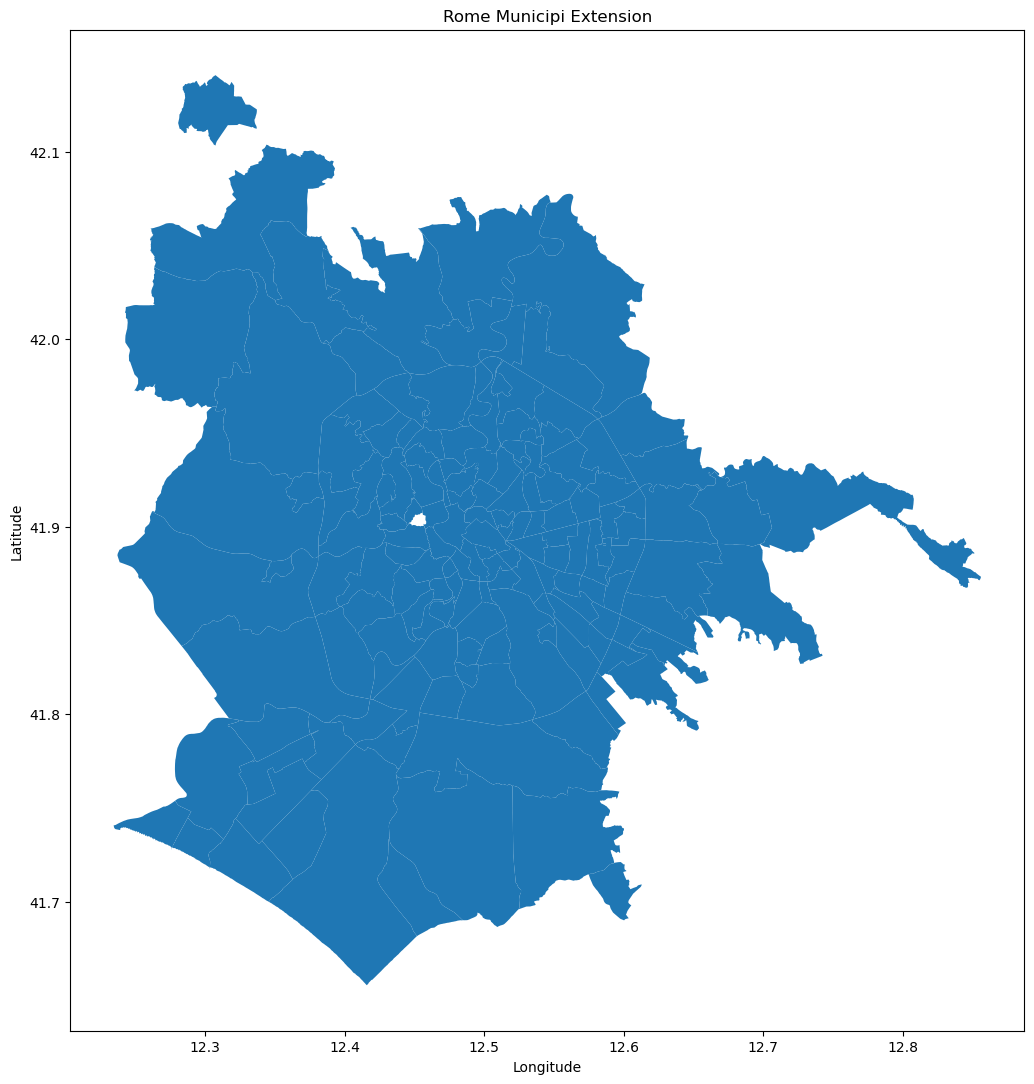

In [24]:
zone_urbanistiche_shape = gpd.read_file('C:/Users/acer/Documents/Mauro/DataScience/IBM/Roma_Restaurants/File Utili/ZoneUrbanistiche/ZoneUrbanistiche.shp').to_crs({'proj': 'latlong'})
zone_urbanistiche_shape.plot(figsize=(18, 13))
plt.title('Rome Municipi Extension')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Since the "Zone Urbane" shape file does not contain information about the Municipio of each zone I had to scrape the wikipedia page in order to get a list of each Municipio and its corresponding "Zone Urbane". Then, with a little creativity, I managed to put this information in the shape file, so that I can select only what I am interested in.

In [25]:
zone_urbanistiche_wikitable = BeautifulSoup(requests.get('https://it.wikipedia.org/wiki/Zone_urbanistiche_di_Roma').content, 'html.parser')

zone_urbanistiche_list = []

lists = zone_urbanistiche_wikitable.find_all('li')
for i in range(6,21):
    zone = lists[i].get_text()
    zone_urbanistiche_list.append(zone)

for zone in range(0,155):
    test = ' {} '.format(zone_urbanistiche_shape['ZONA_URBAN'][zone].upper())
    mainStr = str(zone_urbanistiche_list)
    patternObj = re.compile(test)
    matchObj = patternObj.search(mainStr)
    check_num = matchObj.span()
    
    if check_num[1] > 18 and check_num[1] < 187:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 1
    elif check_num[1] > 204 and check_num[1] < 369:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 2
    elif check_num[1] > 387 and check_num[1] < 609:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 3
    elif check_num[1] >  626 and check_num[1] < 807:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 4       
    elif check_num[1] >  823 and check_num[1] < 1028:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 5
    elif check_num[1] >  1045 and check_num[1] < 1194:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 6 
    elif check_num[1] >  1212 and check_num[1] < 1471:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 7
    elif check_num[1] >  1490 and check_num[1] < 1661:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 8
    elif check_num[1] >  1678 and check_num[1] < 1912:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 9
    elif check_num[1] >  1928 and check_num[1] < 2097:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 10
    elif check_num[1] >  2114 and check_num[1] < 2225:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 11
    elif check_num[1] >  2243 and check_num[1] < 2373:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 12
    elif check_num[1] >  2392 and check_num[1] < 2499:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 13
    elif check_num[1] >  2517 and check_num[1] < 2672:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 14
    elif check_num[1] >  2689:
        zone_urbanistiche_shape.at[zone,'MUNICIPIO'] = 15

In [26]:
zone_urbanistiche_df = pd.DataFrame(zone_urbanistiche_shape)
zone_urbanistiche_df['Centroid'] = zone_urbanistiche_shape.centroid
zone_urbanistiche_df['Latitude'] = zone_urbanistiche_shape.centroid.apply(lambda p: round(p.y,7)).astype(float)
zone_urbanistiche_df['Longitude'] = zone_urbanistiche_shape.centroid.apply(lambda p: round(p.x,7)).astype(float)
zone_urbanistiche_df.drop(columns=['geometry'], inplace=True)
zone_urbanistiche_df.drop(columns=['Centroid'], inplace=True)
zone_urbanistiche_df.drop(columns=['PERIMETRO'], inplace=True)
zone_urbanistiche_df['AREA'] = zone_urbanistiche_df['AREA']/1000000
zone_urbanistiche_df

<ipython-input-26-48baa2306121>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_urbanistiche_df['Centroid'] = zone_urbanistiche_shape.centroid
<ipython-input-26-48baa2306121>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_urbanistiche_df['Latitude'] = zone_urbanistiche_shape.centroid.apply(lambda p: round(p.y,7)).astype(float)
<ipython-input-26-48baa2306121>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_urbanistiche_df['Longitude'] = zone_urbanistiche_shape.centroid.apply(lambda p: round(p.x,7)).astype(float)


ZONA_URBAN       DENOMINAZI       AREA MUNICIPIO   Latitude  Longitude
0           1f     XX Settembre   1.402282         1  41.905764  12.496505
1          13h    Castel Fusano  12.258320        10  41.720399  12.331798
2          20b    Acquatraversa   1.381128        15  41.949920  12.445283
3          20c  Tomba di Nerone   4.837299        15  41.968893  12.442213
4          20d        Farnesina   2.431019        15  41.944935  12.459706
..         ...              ...        ...       ...        ...        ...
150         9e           Latino   1.593387         7  41.871485  12.514062
151        17c             Eroi   0.876736         1  41.908296  12.448571
152        18a      Aurelio Sud   2.866431        13  41.894217  12.445559
153        18b      Val Cannuta   7.110734        13  41.896763  12.407356
154        18c         Fogaccia   4.764087        13  41.911254  12.392465

[155 rows x 6 columns]

In [27]:
excel_file=pd.ExcelFile('C:/Users/acer/Documents/Mauro/DataScience/IBM/Roma_Restaurants/File Utili/Terrirorio_Zone_Urbanistiche_2019.xlsx')
Zone_Density = pd.read_excel(excel_file, 'Estensione e densità abitativa')
Zone_Density.drop(Zone_Density.columns[0], axis=1, inplace=True)
Zone_Density.drop(Zone_Density.columns[2], axis=1, inplace=True)
Zone_Density.dropna(axis=0, how='any', inplace=True)
Zone_Density.drop([2], inplace=True)
Zone_Density = Zone_Density.rename(columns={'Unnamed: 1':'ZONA_URBAN','Unnamed: 2':'DENOMINAZI','Unnamed: 4':'Density'})
Zone_Density.drop(Zone_Density.columns[1], axis=1, inplace=True)
Zone_Density = Zone_Density.reset_index()
Zone_Density.drop(Zone_Density.columns[0], axis=1, inplace=True)
Zone_Density

ZONA_URBAN  Density
0           1a  7579.24
1           1b  7541.04
2           1c  5310.57
3           1d  12088.1
4           1e  10813.7
..         ...      ...
164        20l  119.923
165        20m  1876.82
166        20n  263.496
167        20o  4.37036
168        20x  335.312

[169 rows x 2 columns]

In [28]:
zone_urbanistiche_df = pd.merge(zone_urbanistiche_df,Zone_Density,on='ZONA_URBAN')
zone_urbanistiche_df

ZONA_URBAN       DENOMINAZI       AREA MUNICIPIO   Latitude  Longitude  \
0           1f     XX Settembre   1.402282         1  41.905764  12.496505   
1          13h    Castel Fusano  12.258320        10  41.720399  12.331798   
2          20b    Acquatraversa   1.381128        15  41.949920  12.445283   
3          20c  Tomba di Nerone   4.837299        15  41.968893  12.442213   
4          20d        Farnesina   2.431019        15  41.944935  12.459706   
..         ...              ...        ...       ...        ...        ...   
150         9e           Latino   1.593387         7  41.871485  12.514062   
151        17c             Eroi   0.876736         1  41.908296  12.448571   
152        18a      Aurelio Sud   2.866431        13  41.894217  12.445559   
153        18b      Val Cannuta   7.110734        13  41.896763  12.407356   
154        18c         Fogaccia   4.764087        13  41.911254  12.392465   

     Density  
0    6308.29  
1    121.876  
2    7148.51  
3       6638  
4    7945.64  
..       ...  
150  14209.4  
151  21927.9  
152  8561.17  
153  4718.92  
154  6253.24  

[155 rows x 7 columns]

## These are the "Zona Urbana" that are contained in the Centro Storico area:

In [29]:
Zone_Urbanistiche_Mun_1_df = zone_urbanistiche_df.loc[zone_urbanistiche_df['MUNICIPIO'] == 1]
Zone_Urbanistiche_Mun_1_df = Zone_Urbanistiche_Mun_1_df.reset_index()
Zone_Urbanistiche_Mun_1_df.drop(Zone_Urbanistiche_Mun_1_df.columns[0], axis=1, inplace=True)
Zone_Urbanistiche_Mun_1_df

ZONA_URBAN         DENOMINAZI      AREA MUNICIPIO   Latitude  Longitude  \
0          1f       XX Settembre  1.402282         1  41.905764  12.496505   
1          1e          Esquilino  3.094494         1  41.894879  12.500851   
2          1a     Centro Storico  3.188448         1  41.899879  12.477498   
3          1g              Celio  0.682698         1  41.886452  12.500488   
4          1x  Zona Archeologica  1.906625         1  41.881858  12.493141   
5          1b         Trastevere  1.809831         1  41.890113  12.467390   
6         17a              Prati  1.759290         1  41.906836  12.464726   
7         17b     Della Vittoria  3.158216         1  41.921400  12.456509   
8          1c           Aventino  1.560472         1  41.878965  12.485041   
9          1d          Testaccio  0.648075         1  41.877606  12.474733   
10        17c               Eroi  0.876736         1  41.908296  12.448571   

    Density  
0   6308.29  
1   10813.7  
2   7579.24  
3   5703.84  
4   384.973  
5   7541.04  
6   9988.69  
7   8056.13  
8   5310.57  
9   12088.1  
10  21927.9

## These are the "Zona Urbana" that are contained in the Parioli/Nomentano area:

In [30]:
Zone_Urbanistiche_Mun_2_df = zone_urbanistiche_df.loc[zone_urbanistiche_df['MUNICIPIO'] == 2]
Zone_Urbanistiche_Mun_2_df = Zone_Urbanistiche_Mun_2_df.reset_index()
Zone_Urbanistiche_Mun_2_df.drop(Zone_Urbanistiche_Mun_2_df.columns[0], axis=1, inplace=True)
Zone_Urbanistiche_Mun_2_df

ZONA_URBAN          DENOMINAZI      AREA MUNICIPIO   Latitude  Longitude  \
0          2c            Flaminio  1.388886         2  41.924928  12.467305   
1          3a           Nomentano  2.913411         2  41.914885  12.519730   
2          3b          S. Lorenzo  0.522473         2  41.897806  12.515318   
3          2a  Villaggio Olimpico  1.152447         2  41.931692  12.475563   
4          2b             Parioli  2.068552         2  41.924712  12.483909   
5          2d             Salario  1.931729         2  41.917169  12.500267   
6          3y              Verano  1.489490         2  41.900629  12.525489   
7          3x          Università  1.015284         2  41.904587  12.513029   
8          2e             Trieste  2.909327         2  41.929623  12.514565   
9          2x      Villa Borghese  1.395248         2  41.914785  12.484441   
10         2y           Villa Ada  2.875615         2  41.933828  12.498088   

    Density  
0   9378.74  
1   13275.8  
2   16969.3  
3   2458.25  
4   10529.6  
5   13093.4  
6   153.744  
7   933.729  
8   18130.3  
9   447.949  
10  294.893

## These are the "Zona Urbana" that are contained in the Prenestino/Centocelle area:

In [31]:
Zone_Urbanistiche_Mun_5_df = zone_urbanistiche_df.loc[zone_urbanistiche_df['MUNICIPIO'] == 5]
Zone_Urbanistiche_Mun_5_df = Zone_Urbanistiche_Mun_5_df.reset_index()
Zone_Urbanistiche_Mun_5_df.drop(Zone_Urbanistiche_Mun_5_df.columns[0], axis=1, inplace=True)
Zone_Urbanistiche_Mun_5_df

ZONA_URBAN                     DENOMINAZI      AREA MUNICIPIO   Latitude  \
0          7g  Centro Direzionale Centocelle  1.813194         5  41.869838   
1          7a                     Centocelle  3.073681         5  41.887800   
2          7b                   Alessandrina  3.117914         5  41.885018   
3          7c                   Tor Sapienza  2.154367         5  41.903635   
4          7d                     La Rustica  1.801450         5  41.911936   
5          7e                  Tor Tre Teste  1.294996         5  41.885863   
6          7f                Casetta Mistica  3.290692         5  41.883485   
7          7h                            Omo  2.811689         5  41.898788   
8          6b                       Casilino  1.998170         5  41.883686   
9          6c                       Quadraro  1.528267         5  41.873666   
10         6d                       Gordiani  1.767161         5  41.895201   
11         6a                  Torpignattara  2.267712         5  41.889215   

    Longitude  Density  
0   12.559888  667.882  
1   12.567657  17625.8  
2   12.579413  8653.86  
3   12.589943  5752.04  
4   12.607712  5572.18  
5   12.586557  8341.34  
6   12.601263  266.205  
7   12.603598  704.559  
8   12.552335  5294.85  
9   12.544140    13548  
10  12.554182  23455.1  
11  12.534015  20997.4

## These are the "Zona Urbana" that are contained in the Appio-Latino/Tuscolana/Cinecittà area:

In [32]:
Zone_Urbanistiche_Mun_7_df = zone_urbanistiche_df.loc[zone_urbanistiche_df['MUNICIPIO'] == 7]
Zone_Urbanistiche_Mun_7_df = Zone_Urbanistiche_Mun_7_df.reset_index()
Zone_Urbanistiche_Mun_7_df.drop(Zone_Urbanistiche_Mun_7_df.columns[0], axis=1, inplace=True)
Zone_Urbanistiche_Mun_7_df

ZONA_URBAN          DENOMINAZI      AREA MUNICIPIO   Latitude  Longitude  \
0          9b       Tuscolano Sud  3.181761         7  41.872348  12.531329   
1         10g            Romanina  2.102663         7  41.844083  12.602652   
2         10e     Lucrezia Romana  1.723059         7  41.837769  12.581604   
3         10f  Osteria del Curato  2.224941         7  41.849589  12.586967   
4         10a           Don Bosco  2.307537         7  41.858576  12.567499   
5         10b       Appio-Claudio  3.441692         7  41.850329  12.561789   
6         10c       Quarto Miglio  5.012835         7  41.831263  12.566172   
7          9a      Tuscolano Nord  1.124112         7  41.884306  12.518816   
8         10h              Gregna  2.704755         7  41.830241  12.595903   
9         10i           Barcaccia  5.046460         7  41.832479  12.632673   
10        10l              Morena  8.811097         7  41.816460  12.617738   
11        10x            Ciampino  3.268257         7  41.806671  12.586356   
12        10d          Pignatelli  1.015415         7  41.842699  12.545764   
13         9c         Tor Fiscale  0.936942         7  41.857783  12.543236   
14         9d               Appio  1.349991         7  41.878880  12.507547   
15         9e              Latino  1.593387         7  41.871485  12.514062   

    Density  
0   15014.3  
1   3435.64  
2   3059.68  
3   8675.73  
4   21964.5  
5   8474.61  
6   2136.12  
7   19196.5  
8   2619.46  
9   2208.68  
10  3634.51  
11  126.061  
12  6501.77  
13  2401.43  
14  20279.4  
15  14209.4

## Here is a list of the Chinese Restaurants that are in the Prenestino/Centocelle area:

In [33]:
Chinese_Restaurants_Mun_5_df = Chinese_Restaurants_df.loc[Chinese_Restaurants_df['Municipio'] == 5]
Chinese_Restaurants_Mun_5_df = Chinese_Restaurants_Mun_5_df.reset_index()
Chinese_Restaurants_Mun_5_df.drop(Chinese_Restaurants_Mun_5_df.columns[0], axis=1, inplace=True)
Chinese_Restaurants_Mun_5_df

Name                           Address  \
0                             Easy                               NaN   
1           Nuovo Aroma di Pechino               Via Prenestina, 726   
2         WU XIN Ristorante Cinese               Via Delle Rose, 100   
3          Ristorante Mediterraneo                     via Anagni 52   
4         La città della primavera  Via delle Acacie, 16, 00171 Roma   
5               Ristorante La Luna               Via Dei Castani 28A   
6                            Gemma          Via Benedetto Bordoni 22   
7                   VDO Restaurant                               NaN   
8                  Vento D'oriente                  Via casilina 447   
9                          Jin Xin      Via di Tor Pignattara, 40-82   
10                Ristorante Fuhai         Via Cario della Rocca, 65   
11                  Yongdao Coffee                                 X   
12  Ristorante Cinese Leone D'oro2                     Via Tuscolana   

     Latitude  Longitude    CAP            Category  Grid Coefficient  \
0   41.897346  12.607088  00155  Chinese Restaurant             700.0   
1   41.888946  12.587211  00155  Chinese Restaurant             801.0   
2   41.890483  12.565013  00171  Chinese Restaurant             803.0   
3   41.890090  12.556373  00171  Chinese Restaurant             804.0   
4   41.887110  12.563131  00171  Chinese Restaurant             804.0   
5   41.877982  12.566807  00172  Chinese Restaurant             903.0   
6   41.881033  12.541409  00176  Chinese Restaurant             905.0   
7   41.880450  12.541486  00177  Chinese Restaurant             905.0   
8   41.880346  12.541867  00177  Chinese Restaurant             905.0   
9   41.878273  12.541773  00177  Chinese Restaurant             906.0   
10  41.876477  12.543779  00177  Chinese Restaurant             906.0   
11  41.871940  12.567380  00172  Chinese Restaurant            1003.0   
12  41.867289  12.550199  00175  Chinese Restaurant            1005.0   

                 Category ID                  Venue ID  Municipio  
0   4bf58dd8d48988d145941735  53499f9d498e53c7c19d6518          5  
1   4bf58dd8d48988d145941735  4dc53a8e45dd2645526a2393          5  
2   4bf58dd8d48988d145941735  4d330586b6093704ba1cfddf          5  
3   4bf58dd8d48988d145941735  4d24bc4114f2b1f7b2f270be          5  
4   4bf58dd8d48988d145941735  4f79f979e4b09a7cf07a1a96          5  
5   4bf58dd8d48988d145941735  51bcb774498e24fd07b943bb          5  
6   4bf58dd8d48988d145941735  57e93127cd10e26952842a04          5  
7   4bf58dd8d48988d145941735  4f3ab566e4b0b6d3bc1ccc81          5  
8   4bf58dd8d48988d145941735  4c5d9d786ebe2d7f8a52d32e          5  
9   4bf58dd8d48988d145941735  4bf6eb905317a593ff17fd7e          5  
10  4bf58dd8d48988d145941735  4d98595faf3d236a25ee39c7          5  
11  4bf58dd8d48988d145941735  4f0bbde8e4b0ece6d0b02dbe          5  
12  4bf58dd8d48988d145941735  4cc8741a4650a35dfebd881e          5

## Here is a list of the Chinese Restaurants that are in the Appio-Latino/Tuscolana/Cinecittà area:

In [34]:
Chinese_Restaurants_Mun_7_df = Chinese_Restaurants_df.loc[Chinese_Restaurants_df['Municipio'] == 7]
Chinese_Restaurants_Mun_7_df = Chinese_Restaurants_Mun_7_df.reset_index()
Chinese_Restaurants_Mun_7_df.drop(Chinese_Restaurants_Mun_7_df.columns[0], axis=1, inplace=True)
Chinese_Restaurants_Mun_7_df

Name                       Address  \
0          New Hong Kong Risorante Cinese                           NaN   
1                                 Hua Hua                  Via Aosta 69   
2                 Iki Oriental Restaurant                 Piazza Ragusa   
3                       Ristorante Mikaku       Viale Furio Camillo, 22   
4              Ristorante/Pizzeria Cinese        Viale Furio Camillo 22   
5               Ristorante Cinese Hua Hua                  Via Aosta 71   
6                               San Seven                           NaN   
7   Cucina Cinese e Italiana a Portar Via               Via Dei Lentuli   
8           Ristorante Cinese Mondo D'Oro                           NaN   
9                         Ristorante Zhou                           NaN   
10                          Mi Ristorante                           NaN   
11                                  Tokyo   via Pietro Colletta 16 / 20   
12            Ristorante Cinese La Peonia  Viale Palmiro Togliatti, 237   
13          Ristorante La Capitale Cinese       Largo Appio Claudio 364   
14                  Il Giardino d'Oriente        Via degli Opimiani, 49   
15                  Ristorante Shun Chang      Viale Appio Claudio, 324   
16                             Shun Chang                           NaN   
17                             Shun Chang           Viale Appio Claudio   
18                              Shunchang           Viale Appio Claudio   
19                       Sapori D'Oriente                           NaN   
20                                chinees                           NaN   
21                       Piccola Cambogia                           NaN   
22                     一餐厅 One Restaurant             via Tuscolana 623   

     Latitude  Longitude    CAP             Category  Grid Coefficient  \
0   41.886541  12.515365  00185   Chinese Restaurant             809.0   
1   41.886837  12.514812  00182   Chinese Restaurant             809.0   
2   41.881683  12.522751  00182   Chinese Restaurant             908.0   
3   41.875038  12.523660  00181   Chinese Restaurant             908.0   
4   41.875268  12.523509  00182   Chinese Restaurant             908.0   
5   41.884012  12.514958  00183   Chinese Restaurant             909.0   
6   41.864265  12.547652  00175   Chinese Restaurant            1005.0   
7   41.864200  12.547554  00175   Chinese Restaurant            1005.0   
8   41.870354  12.533307  00181   Chinese Restaurant            1006.0   
9   41.870605  12.533379  00181   Chinese Restaurant            1006.0   
10  41.870253  12.525934  00179   Chinese Restaurant            1008.0   
11  41.872436  12.517350  00179   Chinese Restaurant            1008.0   
12  41.862292  12.569138  00173   Chinese Restaurant            1103.0   
13  41.856257  12.563439  00174   Chinese Restaurant            1104.0   
14  41.861427  12.550131  00174   Chinese Restaurant            1105.0   
15  41.854315  12.563338  00174   Chinese Restaurant            1204.0   
16  41.853981  12.563917  00174   Chinese Restaurant            1204.0   
17  41.852815  12.543699  00178   Chinese Restaurant            1206.0   
18  41.853991  12.563153  00174   Chinese Restaurant            1204.0   
19  41.829284  12.557578  00178   Chinese Restaurant            1404.0   
20  41.829515  12.557895  00178   Chinese Restaurant            1404.0   
21  41.882673  12.506779  00183   Dim Sum Restaurant             910.0   
22  41.863128  12.551012  00174  Szechuan Restaurant            1105.0   

                 Category ID                  Venue ID  Municipio  
0   4bf58dd8d48988d145941735  4d56f16ba747b60cf8252f2b          7  
1   4bf58dd8d48988d145941735  4e4a676b45dd81ecad8bfe86          7  
2   4bf58dd8d48988d145941735  5c366208b6eedb002c524769          7  
3   4bf58dd8d48988d145941735  4c2f73d57cc0c9b67ab7eb9a          7  
4   4bf58dd8d48988d145941735  4e304f1152b111a1e38c74f9          7  
5   4bf58dd8d48988d145941735  4d2f5adda6df6dcbe04ce

## Here is a list of the Japanese Restaurants that are in the Centro Storico area:

In [35]:
Japanese_Restaurants_Mun_1_df = Japanese_Restaurants_df.loc[Japanese_Restaurants_df['Municipio'] == 1]
Japanese_Restaurants_Mun_1_df = Japanese_Restaurants_Mun_1_df.reset_index()
Japanese_Restaurants_Mun_1_df.drop(Japanese_Restaurants_Mun_1_df.columns[0], axis=1, inplace=True)
Japanese_Restaurants_Mun_1_df

Name  \
0                  Sapporo pizza e sushi   
1                                   Taki   
2                   Temakinho Rome Borgo   
3                             Ginza Gold   
4                              Zuma Roma   
5                        Sushi e Noodles   
6             Zero21 Brazilian Sushi Bar   
7                              Sambamaki   
8                            Genso Sushi   
9                              Temakinho   
10  Daruma Sushi Restaurant - Parlamento   
11        Ristorante Giapponese Xing Hai   
12                                   São   

                                  Address   Latitude  Longitude    CAP  \
0                       Via Oslavia, 39/A  41.918405  12.461897  00195   
1                Via Marianna Dionigi, 56  41.905920  12.471180  00193   
2                      Borgo Angelico, 30  41.905232  12.459694  00193   
3                       Via Barberini, 53  41.904500  12.491337  00185   
4   Via della Fontanella di Borghese, 48,  41.904624  12.478446  00186   
5                     Viale Aventino, 117  41.880751  12.484587  00153   
6                       3A Via della Luce  41.889154  12.475898  00153   
7              Via Vittoria Colonna 17/19  41.905204  12.472110  00193   
8                        75 Via Trionfale  41.914400  12.450656  00136   
9                    Via dei Serpenti, 16  41.895486  12.490374  00184   
10               Piazza del Parlamento 37  41.902378  12.477739  00186   
11                 Emanuele Filiberto 197  41.889644  12.507075  00185   
12                     Viale Aventino 123  41.880549  12.484652  00153   

               Category  Grid Coefficient               Category ID  \
0   Japanese Restaurant             514.0  4bf58dd8d48988d111941735   
1   Japanese Restaurant             613.0  4bf58dd8d48988d111941735   
2   Japanese Restaurant             614.0  4bf58dd8d48988d111941735   
3   Japanese Restaurant             711.0  4bf58dd8d48988d111941735   
4   Japanese Restaurant             712.0  4bf58dd8d48988d111941735   
5   Japanese Restaurant             911.0  4bf58dd8d48988d111941735   
6      Sushi Restaurant             812.0  4bf58dd8d48988d1d2941735   
7      Sushi Restaurant             613.0  4bf58dd8d48988d1d2941735   
8      Sushi Restaurant             615.0  4bf58dd8d48988d1d2941735   
9      Sushi Restaurant             711.0  4bf58dd8d48988d1d2941735   
10     Sushi Restaurant             712.0  4bf58dd8d48988d1d2941735   
11     Sushi Restaurant             809.0  4bf58dd8d48988d1d2941735   
12     Sushi Restaurant             911.0  4bf58dd8d48988d1d2941735   

                    Venue ID  Municipio  
0   53b1b07f498e3bbe35073016          1  
1   4bae76fbf964a520c3b53be3          1  
2   55c90ad6498ec409623c12e5          1  
3   4bbcdb878ec3d13a2c551b28          1  
4   57123127498ea9ddf6846517          1  
5   50f1d6f7e4b08185d8a455fb          1  
6   5c26393c475abd002c30a928          1  
7   564da44c498e5869e72fcc3a          1  
8   58d325be13af1c4839d12be5          1  
9   53f8fe8c498ecb81e43b7c38          1  
10  4ecf948799114b48871e473e          1  
11  5651adb4498ee87b7b2499fe          1  
12  5866cf55c0df766439d23c5a          1

## Here is a list of the Japanese Restaurants that are in the Parioli/Nomentano area:

In [36]:
Japanese_Restaurants_Mun_2_df = Japanese_Restaurants_df.loc[Japanese_Restaurants_df['Municipio'] == 2]
Japanese_Restaurants_Mun_2_df = Japanese_Restaurants_Mun_2_df.reset_index()
Japanese_Restaurants_Mun_2_df.drop(Japanese_Restaurants_Mun_2_df.columns[0], axis=1, inplace=True)
Japanese_Restaurants_Mun_2_df

Name                         Address  \
0                               Ninja            Viale Somalia, 73/79   
1                          Zen Fusion                Viale Eritrea 67   
2                            sushiami                             NaN   
3                       Jinjá Parioli  Via Guidubaldo Del Monte, 6/6A   
4                         izumi sushi                 Via Pigorini 27   
5                               izumi                             NaN   
6                             Shibuya                             NaN   
7                                 WOX                             NaN   
8                Chopstick Restaurant  Viale Regina Margherita, 19-21   
9                                Gong                   55 Via Padova   
10                            Tokyo 3  via della Lega Lombarda, 10-14   
11                    Ramen Bar Akira                             NaN   
12                           SushiAma               Via Nemorense 112   
13                           Sushi Jo               Via Nemorense, 39   
14                    Cantera Parioli             Via Ruggero Fauro 2   
15                             Zero21            95 Viale dei Parioli   
16  Daruma Sushi Restaurant - Parioli     Via Guidubaldo Del Monte, 9   
17                          Kuro Club                             NaN   
18                         Sushi Shop                      via Po 160   
19                           Chikutei           Via Luciani Luigi, 21   
20                            Sushita               Via Nomentana 221   
21                         Domó Sushi                   21 Via Novara   

     Latitude  Longitude    CAP             Category  Grid Coefficient  \
0   41.935914  12.513456  00199  Japanese Restaurant             309.0   
1   41.926748  12.515845  00199  Japanese Restaurant             408.0   
2   41.926651  12.513056  00199  Japanese Restaurant             409.0   
3   41.927113  12.480126  00197  Japanese Restaurant             412.0   
4   41.916110  12.522439  00162  Japanese Restaurant             508.0   
5   41.916077  12.522334  00162  Japanese Restaurant             508.0   
6   41.921654  12.509840  00199  Japanese Restaurant             509.0   
7   41.915137  12.509484  00199  Japanese Restaurant             509.0   
8   41.919212  12.498848  00198  Japanese Restaurant             510.0   
9   41.910882  12.520248  00161  Japanese Restaurant             608.0   
10  41.909388  12.521963  00162  Japanese Restaurant             608.0   
11  41.931699  12.467659  00196     Ramen Restaurant             413.0   
12  41.928800  12.512195  00199     Sushi Restaurant             409.0   
13  41.925238  12.508776  00199     Sushi Restaurant             409.0   
14  41.925776  12.489395  00197     Sushi Restaurant             411.0   
15  41.928871  12.485936  00197     Sushi Restaurant             411.0   
16  41.927296  12.480274  00191     Sushi Restaurant             412.0   
17  41.922971  12.512334  00199     Sushi Restaurant             509.0   
18  41.917649  12.499743  00198     Sushi Restaurant             510.0   
19  41.921500  12.480590  00197     Sushi Restaurant             512.0   
20  41.913432  12.507420  00161     Sushi Restaurant             609.0   
21  41.914087  12.507092  00198     Sushi Restaurant             609.0   

                 Category ID                  Venue ID  Municipio  
0   4bf58dd8d48988d111941735  5c20d6fcfb8e59002c58946a          2  
1   4bf58dd8d48988d111941735  4bc0cd8a2a89ef3bb62ff188          2  
2   4bf58dd8d48988d111941735  54134453498e23d989124cbe          2  
3   4bf58dd8d48988d111941735  58f746e86bd36b5411ae57a1          2  
4   4bf58dd8d48988d111941735  53b99a4d498e09de3df90599          2  
5   4bf58dd8d48988d111941735  528f540511d222595cccad54          2  
6   4bf58dd8d48988d111941735  59bad4416e46504966c52e20          2  
7   4bf58dd8d48988d111941735  5186be67498e1d5b60eeb1d3          2  
8   4bf58dd8d48988d111941735  527a9159

## Again I am using each restaurant position to see in which Zona Urbana polygon they belong.

In [37]:
i=0
temp_list = []
Chinese_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urban'])
for R in Chinese_Restaurants_Mun_5_df['Name']:
    x=0
    plat = Chinese_Restaurants_Mun_5_df['Latitude'].loc[i]
    plng = Chinese_Restaurants_Mun_5_df['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Chinese_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Chinese_in_Zona_Urban.columns = ['Name','Zona Urbana']
Chinese_Restaurants_Mun_5_df = pd.merge(Chinese_Restaurants_Mun_5_df,Chinese_in_Zona_Urban,on='Name')
Chinese_Restaurants_Mun_5_df

Name                           Address  \
0                             Easy                               NaN   
1           Nuovo Aroma di Pechino               Via Prenestina, 726   
2         WU XIN Ristorante Cinese               Via Delle Rose, 100   
3          Ristorante Mediterraneo                     via Anagni 52   
4         La città della primavera  Via delle Acacie, 16, 00171 Roma   
5               Ristorante La Luna               Via Dei Castani 28A   
6                            Gemma          Via Benedetto Bordoni 22   
7                   VDO Restaurant                               NaN   
8                  Vento D'oriente                  Via casilina 447   
9                          Jin Xin      Via di Tor Pignattara, 40-82   
10                Ristorante Fuhai         Via Cario della Rocca, 65   
11                  Yongdao Coffee                                 X   
12  Ristorante Cinese Leone D'oro2                     Via Tuscolana   

     Latitude  Longitude    CAP            Category  Grid Coefficient  \
0   41.897346  12.607088  00155  Chinese Restaurant             700.0   
1   41.888946  12.587211  00155  Chinese Restaurant             801.0   
2   41.890483  12.565013  00171  Chinese Restaurant             803.0   
3   41.890090  12.556373  00171  Chinese Restaurant             804.0   
4   41.887110  12.563131  00171  Chinese Restaurant             804.0   
5   41.877982  12.566807  00172  Chinese Restaurant             903.0   
6   41.881033  12.541409  00176  Chinese Restaurant             905.0   
7   41.880450  12.541486  00177  Chinese Restaurant             905.0   
8   41.880346  12.541867  00177  Chinese Restaurant             905.0   
9   41.878273  12.541773  00177  Chinese Restaurant             906.0   
10  41.876477  12.543779  00177  Chinese Restaurant             906.0   
11  41.871940  12.567380  00172  Chinese Restaurant            1003.0   
12  41.867289  12.550199  00175  Chinese Restaurant            1005.0   

                 Category ID                  Venue ID  Municipio Zona Urbana  
0   4bf58dd8d48988d145941735  53499f9d498e53c7c19d6518          5          7h  
1   4bf58dd8d48988d145941735  4dc53a8e45dd2645526a2393          5          7e  
2   4bf58dd8d48988d145941735  4d330586b6093704ba1cfddf          5          7a  
3   4bf58dd8d48988d145941735  4d24bc4114f2b1f7b2f270be          5          6d  
4   4bf58dd8d48988d145941735  4f79f979e4b09a7cf07a1a96          5          7a  
5   4bf58dd8d48988d145941735  51bcb774498e24fd07b943bb          5          7a  
6   4bf58dd8d48988d145941735  57e93127cd10e26952842a04          5          6a  
7   4bf58dd8d48988d145941735  4f3ab566e4b0b6d3bc1ccc81          5          6a  
8   4bf58dd8d48988d145941735  4c5d9d786ebe2d7f8a52d32e          5          6a  
9   4bf58dd8d48988d145941735  4bf6eb905317a593ff17fd7e          5          6c  
10  4bf58dd8d48988d145941735  4d98595faf3d236a25ee39c7          5          6c  
11  4bf58dd8d48988d145941735  4f0bbde8e4b0ece6d0b02dbe          5          7g  
12  4bf58dd8d48988d145941735  4cc8741a4650a35dfebd881e          5         10a

In [38]:
i=0
temp_list = []
Chinese_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urban'])
for R in Chinese_Restaurants_Mun_7_df['Name']:
    x=0
    plat = Chinese_Restaurants_Mun_7_df['Latitude'].loc[i]
    plng = Chinese_Restaurants_Mun_7_df['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Chinese_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Chinese_in_Zona_Urban.columns = ['Name','Zona Urbana']
Chinese_Restaurants_Mun_7_df = pd.merge(Chinese_Restaurants_Mun_7_df,Chinese_in_Zona_Urban,on='Name')
Chinese_Restaurants_Mun_7_df

Name                       Address  \
0          New Hong Kong Risorante Cinese                           NaN   
1                                 Hua Hua                  Via Aosta 69   
2                 Iki Oriental Restaurant                 Piazza Ragusa   
3                       Ristorante Mikaku       Viale Furio Camillo, 22   
4              Ristorante/Pizzeria Cinese        Viale Furio Camillo 22   
5               Ristorante Cinese Hua Hua                  Via Aosta 71   
6                               San Seven                           NaN   
7   Cucina Cinese e Italiana a Portar Via               Via Dei Lentuli   
8           Ristorante Cinese Mondo D'Oro                           NaN   
9                         Ristorante Zhou                           NaN   
10                          Mi Ristorante                           NaN   
11                                  Tokyo   via Pietro Colletta 16 / 20   
12            Ristorante Cinese La Peonia  Viale Palmiro Togliatti, 237   
13          Ristorante La Capitale Cinese       Largo Appio Claudio 364   
14                  Il Giardino d'Oriente        Via degli Opimiani, 49   
15                  Ristorante Shun Chang      Viale Appio Claudio, 324   
16                             Shun Chang                           NaN   
17                             Shun Chang                           NaN   
18                             Shun Chang           Viale Appio Claudio   
19                             Shun Chang           Viale Appio Claudio   
20                              Shunchang           Viale Appio Claudio   
21                       Sapori D'Oriente                           NaN   
22                                chinees                           NaN   
23                       Piccola Cambogia                           NaN   
24                     一餐厅 One Restaurant             via Tuscolana 623   

     Latitude  Longitude    CAP             Category  Grid Coefficient  \
0   41.886541  12.515365  00185   Chinese Restaurant             809.0   
1   41.886837  12.514812  00182   Chinese Restaurant             809.0   
2   41.881683  12.522751  00182   Chinese Restaurant             908.0   
3   41.875038  12.523660  00181   Chinese Restaurant             908.0   
4   41.875268  12.523509  00182   Chinese Restaurant             908.0   
5   41.884012  12.514958  00183   Chinese Restaurant             909.0   
6   41.864265  12.547652  00175   Chinese Restaurant            1005.0   
7   41.864200  12.547554  00175   Chinese Restaurant            1005.0   
8   41.870354  12.533307  00181   Chinese Restaurant            1006.0   
9   41.870605  12.533379  00181   Chinese Restaurant            1006.0   
10  41.870253  12.525934  00179   Chinese Restaurant            1008.0   
11  41.872436  12.517350  00179   Chinese Restaurant            1008.0   
12  41.862292  12.569138  00173   Chinese Restaurant            1103.0   
13  41.856257  12.563439  00174   Chinese Restaurant            1104.0   
14  41.861427  12.550131  00174   Chinese Restaurant            1105.0   
15  41.854315  12.563338  00174   Chinese Restaurant            1204.0   
16  41.853981  12.563917  00174   Chinese Restaurant            1204.0   
17  41.853981  12.563917  00174   Chinese Restaurant            1204.0   
18  41.852815  12.543699  00178   Chinese Restaurant            1206.0   
19  41.852815  12.543699  00178   Chinese Restaurant            1206.0   
20  41.853991  12.563153  00174   Chinese Restaurant            1204.0   
21  41.829284  12.557578  00178   Chinese Restaurant            1404.0   
22  41.829515  12.557895  00178   Chinese Restaurant            1404.0   
23  41.882673  12.506779  00183   Dim Sum Restaurant             910.0   
24  41.863128  12.551012  00174  Szechuan Restaurant            1105.0   

                 Category ID                  Venue ID  Municipio Zona Urbana  
0   4bf58dd8d48988d145941735  4d56f16ba747b60cf8252f2b          7          9a  
1

In [39]:
i=0
temp_list = []
Japanese_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urbana'])
for R in Japanese_Restaurants_Mun_1_df['Name']:
    x=0
    plat = Japanese_Restaurants_Mun_1_df['Latitude'].loc[i]
    plng = Japanese_Restaurants_Mun_1_df['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Japanese_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Japanese_in_Zona_Urban.columns = ['Name','Zona Urbana']
Japanese_Restaurants_Mun_1_df = pd.merge(Japanese_Restaurants_Mun_1_df,Japanese_in_Zona_Urban,on='Name')
Japanese_Restaurants_Mun_1_df

Name  \
0                  Sapporo pizza e sushi   
1                                   Taki   
2                   Temakinho Rome Borgo   
3                             Ginza Gold   
4                              Zuma Roma   
5                        Sushi e Noodles   
6             Zero21 Brazilian Sushi Bar   
7                              Sambamaki   
8                            Genso Sushi   
9                              Temakinho   
10  Daruma Sushi Restaurant - Parlamento   
11        Ristorante Giapponese Xing Hai   
12                                   São   

                                  Address   Latitude  Longitude    CAP  \
0                       Via Oslavia, 39/A  41.918405  12.461897  00195   
1                Via Marianna Dionigi, 56  41.905920  12.471180  00193   
2                      Borgo Angelico, 30  41.905232  12.459694  00193   
3                       Via Barberini, 53  41.904500  12.491337  00185   
4   Via della Fontanella di Borghese, 48,  41.904624  12.478446  00186   
5                     Viale Aventino, 117  41.880751  12.484587  00153   
6                       3A Via della Luce  41.889154  12.475898  00153   
7              Via Vittoria Colonna 17/19  41.905204  12.472110  00193   
8                        75 Via Trionfale  41.914400  12.450656  00136   
9                    Via dei Serpenti, 16  41.895486  12.490374  00184   
10               Piazza del Parlamento 37  41.902378  12.477739  00186   
11                 Emanuele Filiberto 197  41.889644  12.507075  00185   
12                     Viale Aventino 123  41.880549  12.484652  00153   

               Category  Grid Coefficient               Category ID  \
0   Japanese Restaurant             514.0  4bf58dd8d48988d111941735   
1   Japanese Restaurant             613.0  4bf58dd8d48988d111941735   
2   Japanese Restaurant             614.0  4bf58dd8d48988d111941735   
3   Japanese Restaurant             711.0  4bf58dd8d48988d111941735   
4   Japanese Restaurant             712.0  4bf58dd8d48988d111941735   
5   Japanese Restaurant             911.0  4bf58dd8d48988d111941735   
6      Sushi Restaurant             812.0  4bf58dd8d48988d1d2941735   
7      Sushi Restaurant             613.0  4bf58dd8d48988d1d2941735   
8      Sushi Restaurant             615.0  4bf58dd8d48988d1d2941735   
9      Sushi Restaurant             711.0  4bf58dd8d48988d1d2941735   
10     Sushi Restaurant             712.0  4bf58dd8d48988d1d2941735   
11     Sushi Restaurant             809.0  4bf58dd8d48988d1d2941735   
12     Sushi Restaurant             911.0  4bf58dd8d48988d1d2941735   

                    Venue ID  Municipio Zona Urbana  
0   53b1b07f498e3bbe35073016          1         17b  
1   4bae76fbf964a520c3b53be3          1         17a  
2   55c90ad6498ec409623c12e5          1         17a  
3   4bbcdb878ec3d13a2c551b28          1          1f  
4   57123127498ea9ddf6846517          1          1a  
5   50f1d6f7e4b08185d8a455fb          1          1c  
6   5c26393c475abd002c30a928          1          1b  
7   564da44c498e5869e72fcc3a          1         17a  
8   58d325be13af1c4839d12be5          1         17c  
9   53f8fe8c498ecb81e43b7c38          1          1e  
10  4ecf948799114b48871e473e          1          1a  
11  5651adb4498ee87b7b2499fe          1          1e  
12  5866cf55c0df766439d23c5a          1          1c

In [40]:
i=0
temp_list = []
Japanese_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urbana'])
for R in Japanese_Restaurants_Mun_2_df['Name']:
    x=0
    plat = Japanese_Restaurants_Mun_2_df['Latitude'].loc[i]
    plng = Japanese_Restaurants_Mun_2_df['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Japanese_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Japanese_in_Zona_Urban.columns = ['Name','Zona Urbana']
Japanese_Restaurants_Mun_2_df = pd.merge(Japanese_Restaurants_Mun_2_df,Japanese_in_Zona_Urban,on='Name')
Japanese_Restaurants_Mun_2_df

Name                         Address  \
0                               Ninja            Viale Somalia, 73/79   
1                          Zen Fusion                Viale Eritrea 67   
2                            sushiami                             NaN   
3                       Jinjá Parioli  Via Guidubaldo Del Monte, 6/6A   
4                         izumi sushi                 Via Pigorini 27   
5                               izumi                             NaN   
6                             Shibuya                             NaN   
7                                 WOX                             NaN   
8                Chopstick Restaurant  Viale Regina Margherita, 19-21   
9                                Gong                   55 Via Padova   
10                            Tokyo 3  via della Lega Lombarda, 10-14   
11                    Ramen Bar Akira                             NaN   
12                           SushiAma               Via Nemorense 112   
13                           Sushi Jo               Via Nemorense, 39   
14                    Cantera Parioli             Via Ruggero Fauro 2   
15                             Zero21            95 Viale dei Parioli   
16  Daruma Sushi Restaurant - Parioli     Via Guidubaldo Del Monte, 9   
17                          Kuro Club                             NaN   
18                         Sushi Shop                      via Po 160   
19                           Chikutei           Via Luciani Luigi, 21   
20                            Sushita               Via Nomentana 221   
21                         Domó Sushi                   21 Via Novara   

     Latitude  Longitude    CAP             Category  Grid Coefficient  \
0   41.935914  12.513456  00199  Japanese Restaurant             309.0   
1   41.926748  12.515845  00199  Japanese Restaurant             408.0   
2   41.926651  12.513056  00199  Japanese Restaurant             409.0   
3   41.927113  12.480126  00197  Japanese Restaurant             412.0   
4   41.916110  12.522439  00162  Japanese Restaurant             508.0   
5   41.916077  12.522334  00162  Japanese Restaurant             508.0   
6   41.921654  12.509840  00199  Japanese Restaurant             509.0   
7   41.915137  12.509484  00199  Japanese Restaurant             509.0   
8   41.919212  12.498848  00198  Japanese Restaurant             510.0   
9   41.910882  12.520248  00161  Japanese Restaurant             608.0   
10  41.909388  12.521963  00162  Japanese Restaurant             608.0   
11  41.931699  12.467659  00196     Ramen Restaurant             413.0   
12  41.928800  12.512195  00199     Sushi Restaurant             409.0   
13  41.925238  12.508776  00199     Sushi Restaurant             409.0   
14  41.925776  12.489395  00197     Sushi Restaurant             411.0   
15  41.928871  12.485936  00197     Sushi Restaurant             411.0   
16  41.927296  12.480274  00191     Sushi Restaurant             412.0   
17  41.922971  12.512334  00199     Sushi Restaurant             509.0   
18  41.917649  12.499743  00198     Sushi Restaurant             510.0   
19  41.921500  12.480590  00197     Sushi Restaurant             512.0   
20  41.913432  12.507420  00161     Sushi Restaurant             609.0   
21  41.914087  12.507092  00198     Sushi Restaurant             609.0   

                 Category ID                  Venue ID  Municipio Zona Urbana  
0   4bf58dd8d48988d111941735  5c20d6fcfb8e59002c58946a          2          2e  
1   4bf58dd8d48988d111941735  4bc0cd8a2a89ef3bb62ff188          2          2e  
2   4bf58dd8d48988d111941735  54134453498e23d989124cbe          2          2e  
3   4bf58dd8d48988d111941735  58f746e86bd36b5411ae57a1          2          2b  
4   4bf58dd8d48988d111941735  53b99a4d498e09de3df90599          2          3a  
5   4bf58dd8d48988d111941735  528f540511d222595cccad54          2          3a  
6   4bf58dd8d48988d111941735  59bad4416e46504966c52e20          2          2e  
7   4bf58d

## Then I easily calculate how many restaurants there are for each Zona Urbana

In [41]:
temp = Japanese_Restaurants_Mun_1_df.groupby('Zona Urbana').count().sort_values('Venue ID', ascending=False)
df_temp = pd.DataFrame(temp)
df_temp['index'] = (0,1,2,3,4,5,6,7)
df_temp['Zona Urbana'] = df_temp.index
df_temp = df_temp.set_index('index')
df_temp.drop(df_temp.columns[0:9], axis=1, inplace=True)
df_temp.rename(columns = {'Municipio' : 'Number of Japanese Restaurants'}, inplace=True)
Zone_Urbanistiche_Mun_1_df = pd.merge(Zone_Urbanistiche_Mun_1_df,df_temp,left_on='ZONA_URBAN',right_on='Zona Urbana',how='outer')
Zone_Urbanistiche_Mun_1_df.drop(Zone_Urbanistiche_Mun_1_df.columns[-1], axis=1, inplace=True)
Zone_Urbanistiche_Mun_1_df['Number of Japanese Restaurants'] = Zone_Urbanistiche_Mun_1_df['Number of Japanese Restaurants'].fillna(0)
Zone_Urbanistiche_Mun_1_df

ZONA_URBAN         DENOMINAZI      AREA MUNICIPIO   Latitude  Longitude  \
0          1f       XX Settembre  1.402282         1  41.905764  12.496505   
1          1e          Esquilino  3.094494         1  41.894879  12.500851   
2          1a     Centro Storico  3.188448         1  41.899879  12.477498   
3          1g              Celio  0.682698         1  41.886452  12.500488   
4          1x  Zona Archeologica  1.906625         1  41.881858  12.493141   
5          1b         Trastevere  1.809831         1  41.890113  12.467390   
6         17a              Prati  1.759290         1  41.906836  12.464726   
7         17b     Della Vittoria  3.158216         1  41.921400  12.456509   
8          1c           Aventino  1.560472         1  41.878965  12.485041   
9          1d          Testaccio  0.648075         1  41.877606  12.474733   
10        17c               Eroi  0.876736         1  41.908296  12.448571   

    Density  Number of Japanese Restaurants  
0   6308.29                             1.0  
1   10813.7                             2.0  
2   7579.24                             2.0  
3   5703.84                             0.0  
4   384.973                             0.0  
5   7541.04                             1.0  
6   9988.69                             3.0  
7   8056.13                             1.0  
8   5310.57                             2.0  
9   12088.1                             0.0  
10  21927.9                             1.0

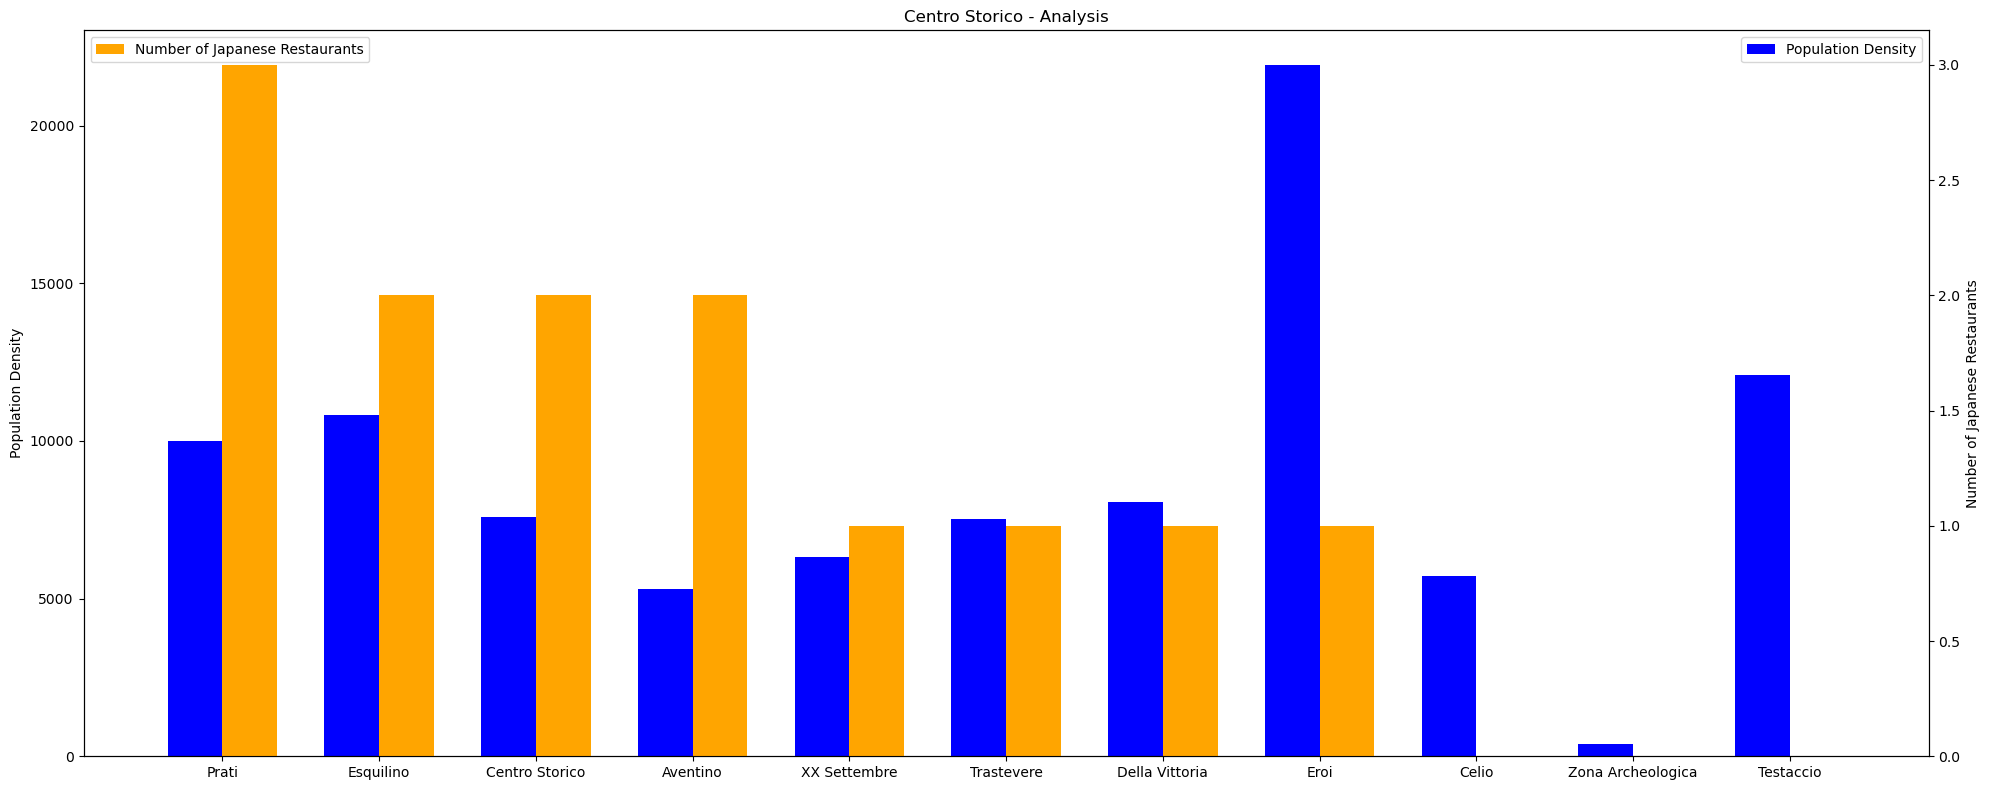

In [42]:
plot_df = Zone_Urbanistiche_Mun_1_df.sort_values('Number of Japanese Restaurants', ascending=False)
labels = plot_df['DENOMINAZI']
dens = plot_df['Density']
number = plot_df['Number of Japanese Restaurants']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams["figure.figsize"] = (20,8)

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.bar(x - width/2, dens, width, label='Population Density', color='blue')
ax_right.bar(x + width/2, number, width, label='Number of Japanese Restaurants', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_left.set_ylabel('Population Density')
ax_right.set_ylabel('Number of Japanese Restaurants')
ax_left.set_title('Centro Storico - Analysis')

ax_left.set_xticks(x)
ax_left.set_xticklabels(labels)
ax_left.legend()
ax_right.legend(loc='upper left')


fig.tight_layout()

plt.show()

## Based on the above graph, "EROI" has a very high population density and only 1 Japanese Restaurant. This area could be a good choice as well as "TESTACCIO" which doesn't have any Japanese Restaurant.

In [43]:
temp = Japanese_Restaurants_Mun_2_df.groupby('Zona Urbana').count().sort_values('Venue ID', ascending=False)
df_temp = pd.DataFrame(temp)
df_temp['index'] = (0,1,2,3,4)
df_temp['Zona Urbana'] = df_temp.index
df_temp = df_temp.set_index('index')
df_temp.drop(df_temp.columns[0:9], axis=1, inplace=True)
df_temp.rename(columns = {'Municipio' : 'Number of Japanese Restaurants'}, inplace=True)
Zone_Urbanistiche_Mun_2_df = pd.merge(Zone_Urbanistiche_Mun_2_df,df_temp,left_on='ZONA_URBAN',right_on='Zona Urbana',how='outer')
Zone_Urbanistiche_Mun_2_df.drop(Zone_Urbanistiche_Mun_2_df.columns[-1], axis=1, inplace=True)
Zone_Urbanistiche_Mun_2_df['Number of Japanese Restaurants'] = Zone_Urbanistiche_Mun_2_df['Number of Japanese Restaurants'].fillna(0)
Zone_Urbanistiche_Mun_2_df

ZONA_URBAN          DENOMINAZI      AREA MUNICIPIO   Latitude  Longitude  \
0          2c            Flaminio  1.388886         2  41.924928  12.467305   
1          3a           Nomentano  2.913411         2  41.914885  12.519730   
2          3b          S. Lorenzo  0.522473         2  41.897806  12.515318   
3          2a  Villaggio Olimpico  1.152447         2  41.931692  12.475563   
4          2b             Parioli  2.068552         2  41.924712  12.483909   
5          2d             Salario  1.931729         2  41.917169  12.500267   
6          3y              Verano  1.489490         2  41.900629  12.525489   
7          3x          Università  1.015284         2  41.904587  12.513029   
8          2e             Trieste  2.909327         2  41.929623  12.514565   
9          2x      Villa Borghese  1.395248         2  41.914785  12.484441   
10         2y           Villa Ada  2.875615         2  41.933828  12.498088   

    Density  Number of Japanese Restaurants  
0   9378.74                             1.0  
1   13275.8                             5.0  
2   16969.3                             0.0  
3   2458.25                             0.0  
4   10529.6                             5.0  
5   13093.4                             4.0  
6   153.744                             0.0  
7   933.729                             0.0  
8   18130.3                             7.0  
9   447.949                             0.0  
10  294.893                             0.0

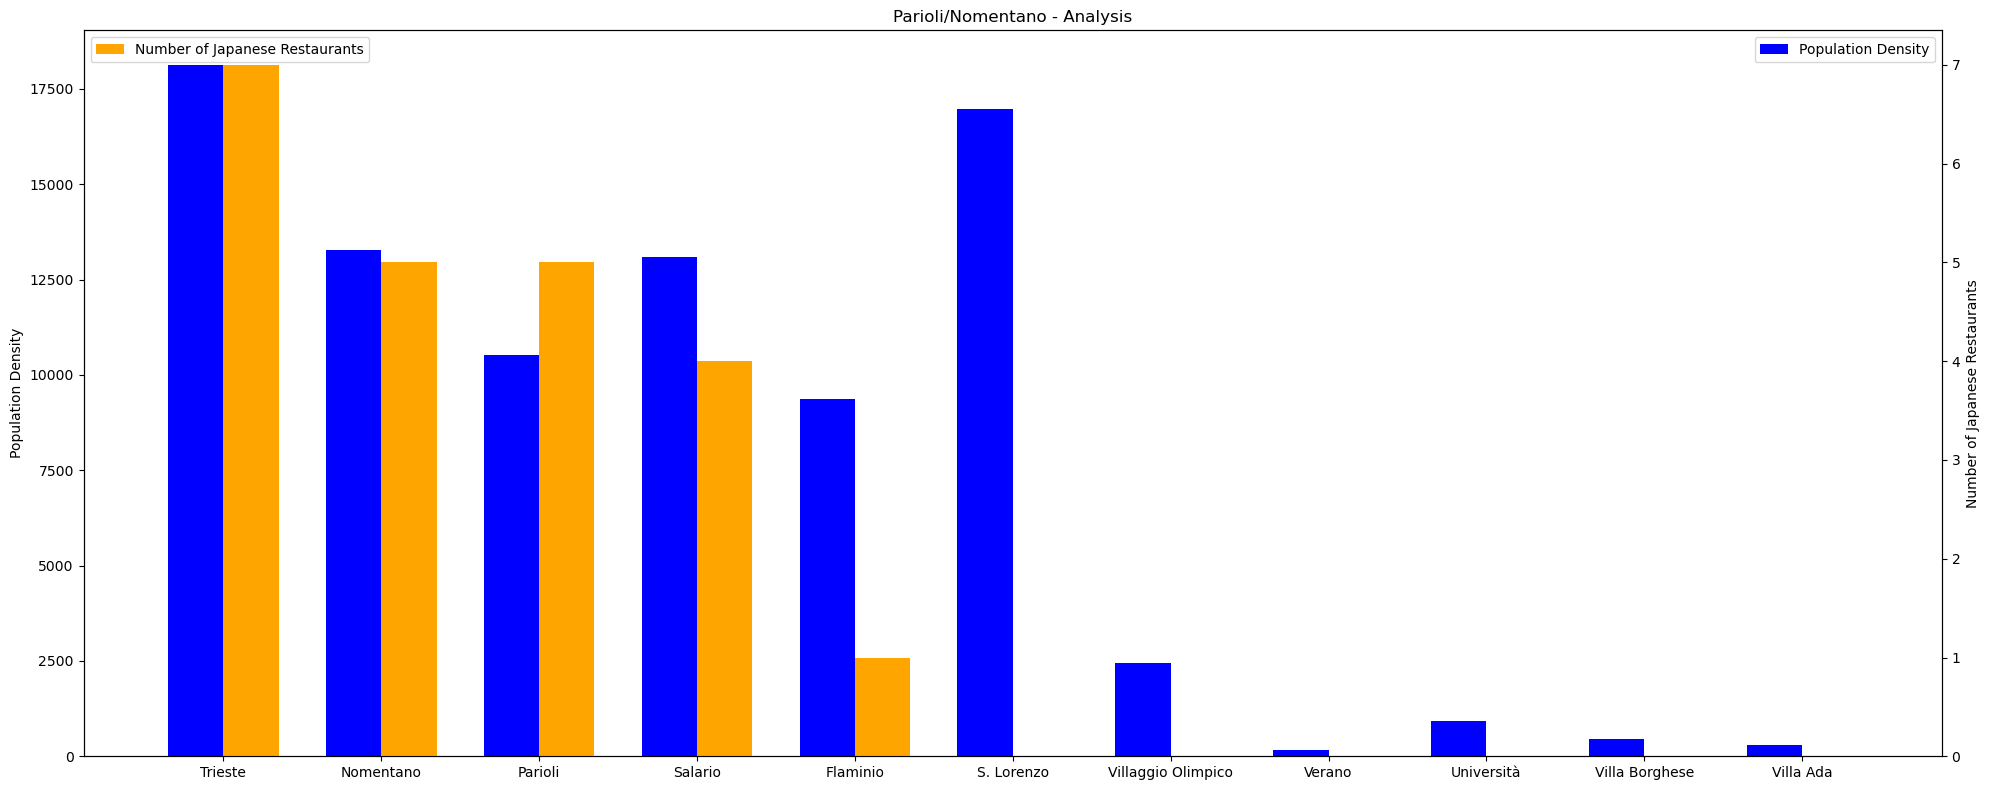

In [49]:
plot_df = Zone_Urbanistiche_Mun_2_df.sort_values('Number of Japanese Restaurants', ascending=False)
labels = plot_df['DENOMINAZI']
dens = plot_df['Density']
number = plot_df['Number of Japanese Restaurants']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams["figure.figsize"] = (20,8)

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.bar(x - width/2, dens, width, label='Population Density', color='blue')
ax_right.bar(x + width/2, number, width, label='Number of Japanese Restaurants', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_left.set_ylabel('Population Density')
ax_right.set_ylabel('Number of Japanese Restaurants')
ax_left.set_title('Parioli/Nomentano - Analysis')

ax_left.set_xticks(x)
ax_left.set_xticklabels(labels)
ax_left.legend()
ax_right.legend(loc='upper left')


fig.tight_layout()

plt.show()

## Based on the above graph, "FLAMINIO" and "SAN LORENZO" can be good options for a new Japanese Restaurant.

In [44]:
temp = Chinese_Restaurants_Mun_5_df.groupby('Zona Urbana').count().sort_values('Venue ID', ascending=False)
df_temp = pd.DataFrame(temp)
df_temp['index'] = (0,1,2,3,4,5,6,7)
df_temp['Zona Urbana'] = df_temp.index
df_temp = df_temp.set_index('index')
df_temp.drop(df_temp.columns[0:9], axis=1, inplace=True)
df_temp.rename(columns = {'Municipio' : 'Number of Chinese Restaurants'}, inplace=True)
Zone_Urbanistiche_Mun_5_df = pd.merge(Zone_Urbanistiche_Mun_5_df,df_temp,left_on='ZONA_URBAN',right_on='Zona Urbana',how='outer')
Zone_Urbanistiche_Mun_5_df.drop(Zone_Urbanistiche_Mun_5_df.columns[-1], axis=1, inplace=True)
Zone_Urbanistiche_Mun_5_df['Number of Chinese Restaurants'] = Zone_Urbanistiche_Mun_5_df['Number of Chinese Restaurants'].fillna(0)
Zone_Urbanistiche_Mun_5_df

ZONA_URBAN                     DENOMINAZI      AREA MUNICIPIO   Latitude  \
0          7g  Centro Direzionale Centocelle  1.813194         5  41.869838   
1          7a                     Centocelle  3.073681         5  41.887800   
2          7b                   Alessandrina  3.117914         5  41.885018   
3          7c                   Tor Sapienza  2.154367         5  41.903635   
4          7d                     La Rustica  1.801450         5  41.911936   
5          7e                  Tor Tre Teste  1.294996         5  41.885863   
6          7f                Casetta Mistica  3.290692         5  41.883485   
7          7h                            Omo  2.811689         5  41.898788   
8          6b                       Casilino  1.998170         5  41.883686   
9          6c                       Quadraro  1.528267         5  41.873666   
10         6d                       Gordiani  1.767161         5  41.895201   
11         6a                  Torpignattara  2.267712         5  41.889215   
12        NaN                            NaN       NaN       NaN        NaN   

    Longitude  Density  Number of Chinese Restaurants  
0   12.559888  667.882                            1.0  
1   12.567657  17625.8                            3.0  
2   12.579413  8653.86                            0.0  
3   12.589943  5752.04                            0.0  
4   12.607712  5572.18                            0.0  
5   12.586557  8341.34                            1.0  
6   12.601263  266.205                            0.0  
7   12.603598  704.559                            1.0  
8   12.552335  5294.85                            0.0  
9   12.544140    13548                            2.0  
10  12.554182  23455.1                            1.0  
11  12.534015  20997.4                            3.0  
12        NaN      NaN                            1.0

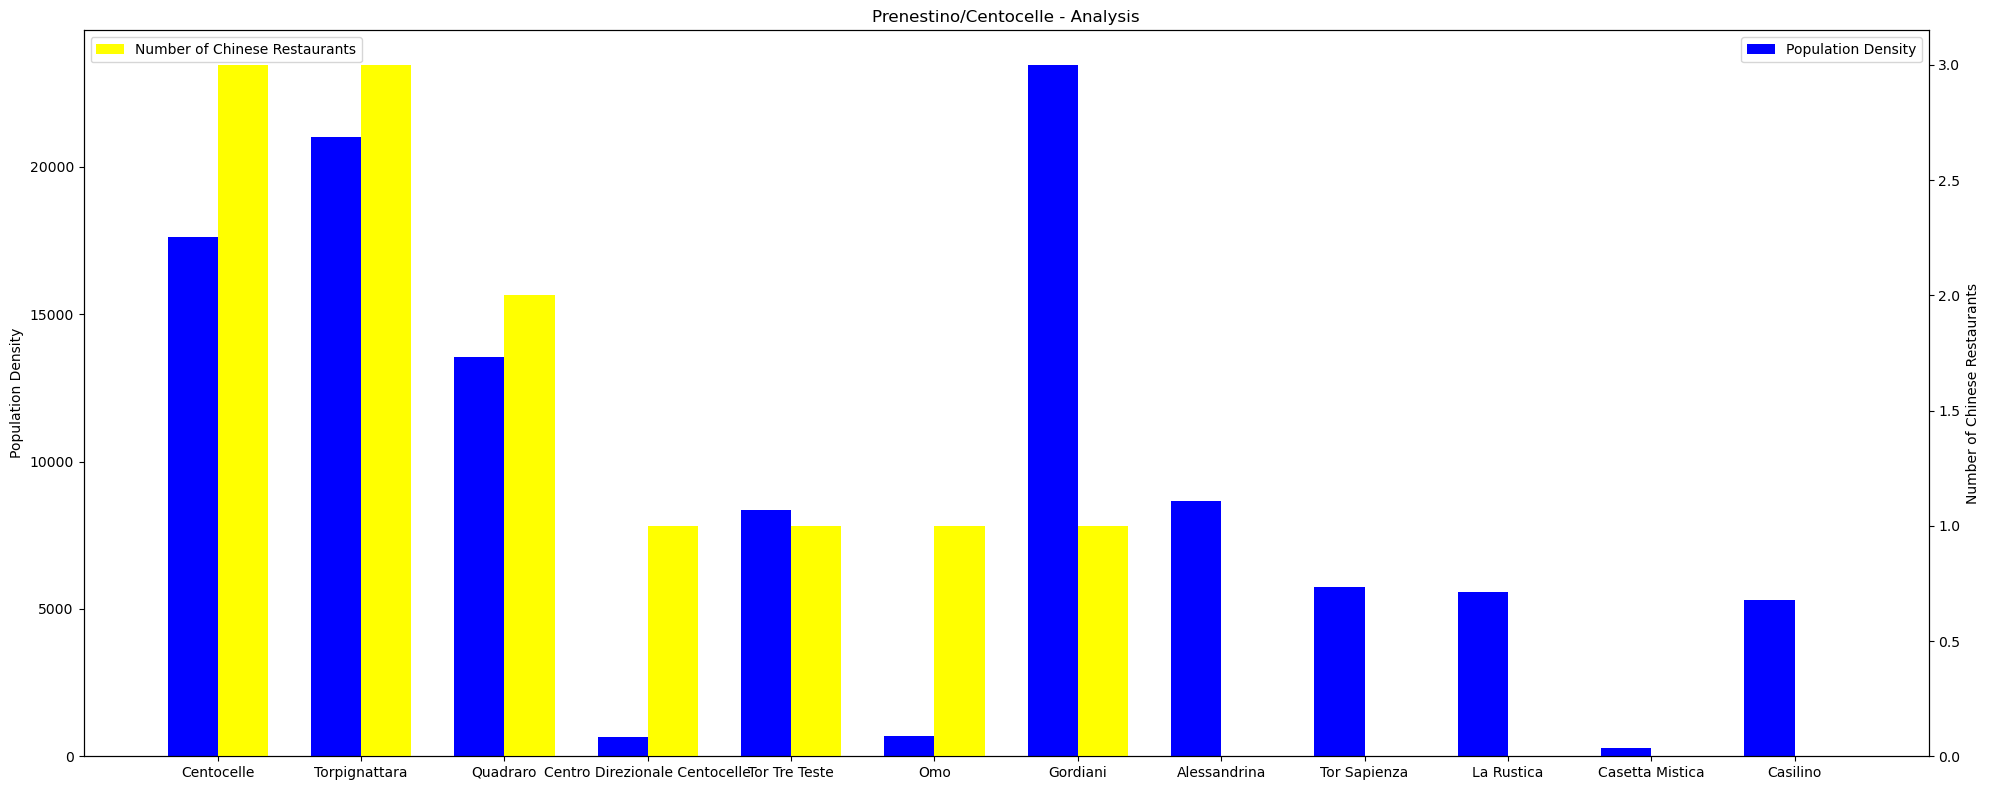

In [51]:
plot_df = Zone_Urbanistiche_Mun_5_df.sort_values('Number of Chinese Restaurants', ascending=False)
labels = plot_df['DENOMINAZI'].drop([12], axis=0)
dens = plot_df['Density'].drop([12], axis=0)
number = plot_df['Number of Chinese Restaurants'].drop([12], axis=0)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams["figure.figsize"] = (20,8)

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.bar(x - width/2, dens, width, label='Population Density', color='blue')
ax_right.bar(x + width/2, number, width, label='Number of Chinese Restaurants', color='yellow')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_left.set_ylabel('Population Density')
ax_right.set_ylabel('Number of Chinese Restaurants')
ax_left.set_title('Prenestino/Centocelle - Analysis')

ax_left.set_xticks(x)
ax_left.set_xticklabels(labels)
ax_left.legend()
ax_right.legend(loc='upper left')


fig.tight_layout()

plt.show()

## Based on the above graph, "GORDIANI" has a very high population density and only 1 Chinese Restaurant. This area could be a good choice.

In [45]:
temp = Chinese_Restaurants_Mun_7_df.groupby('Zona Urbana').count().sort_values('Venue ID', ascending=False)
df_temp = pd.DataFrame(temp)
df_temp['index'] = (0,1,2,3,4,5,6,7)
df_temp['Zona Urbana'] = df_temp.index
df_temp = df_temp.set_index('index')
df_temp.drop(df_temp.columns[0:9], axis=1, inplace=True)
df_temp.rename(columns = {'Municipio' : 'Number of Chinese Restaurants'}, inplace=True)
Zone_Urbanistiche_Mun_7_df = pd.merge(Zone_Urbanistiche_Mun_7_df,df_temp,left_on='ZONA_URBAN',right_on='Zona Urbana',how='outer')
Zone_Urbanistiche_Mun_7_df.drop(Zone_Urbanistiche_Mun_7_df.columns[-1], axis=1, inplace=True)
Zone_Urbanistiche_Mun_7_df['Number of Chinese Restaurants'] = Zone_Urbanistiche_Mun_7_df['Number of Chinese Restaurants'].fillna(0)
Zone_Urbanistiche_Mun_7_df

ZONA_URBAN          DENOMINAZI      AREA MUNICIPIO   Latitude  Longitude  \
0          9b       Tuscolano Sud  3.181761         7  41.872348  12.531329   
1         10g            Romanina  2.102663         7  41.844083  12.602652   
2         10e     Lucrezia Romana  1.723059         7  41.837769  12.581604   
3         10f  Osteria del Curato  2.224941         7  41.849589  12.586967   
4         10a           Don Bosco  2.307537         7  41.858576  12.567499   
5         10b       Appio-Claudio  3.441692         7  41.850329  12.561789   
6         10c       Quarto Miglio  5.012835         7  41.831263  12.566172   
7          9a      Tuscolano Nord  1.124112         7  41.884306  12.518816   
8         10h              Gregna  2.704755         7  41.830241  12.595903   
9         10i           Barcaccia  5.046460         7  41.832479  12.632673   
10        10l              Morena  8.811097         7  41.816460  12.617738   
11        10x            Ciampino  3.268257         7  41.806671  12.586356   
12        10d          Pignatelli  1.015415         7  41.842699  12.545764   
13         9c         Tor Fiscale  0.936942         7  41.857783  12.543236   
14         9d               Appio  1.349991         7  41.878880  12.507547   
15         9e              Latino  1.593387         7  41.871485  12.514062   
16        NaN                 NaN       NaN       NaN        NaN        NaN   

    Density  Number of Chinese Restaurants  
0   15014.3                            5.0  
1   3435.64                            0.0  
2   3059.68                            0.0  
3   8675.73                            0.0  
4   21964.5                            5.0  
5   8474.61                            5.0  
6   2136.12                            2.0  
7   19196.5                            4.0  
8   2619.46                            0.0  
9   2208.68                            0.0  
10  3634.51                            0.0  
11  126.061                            0.0  
12  6501.77                            0.0  
13  2401.43                            0.0  
14  20279.4                            1.0  
15  14209.4                            1.0  
16      NaN                            2.0

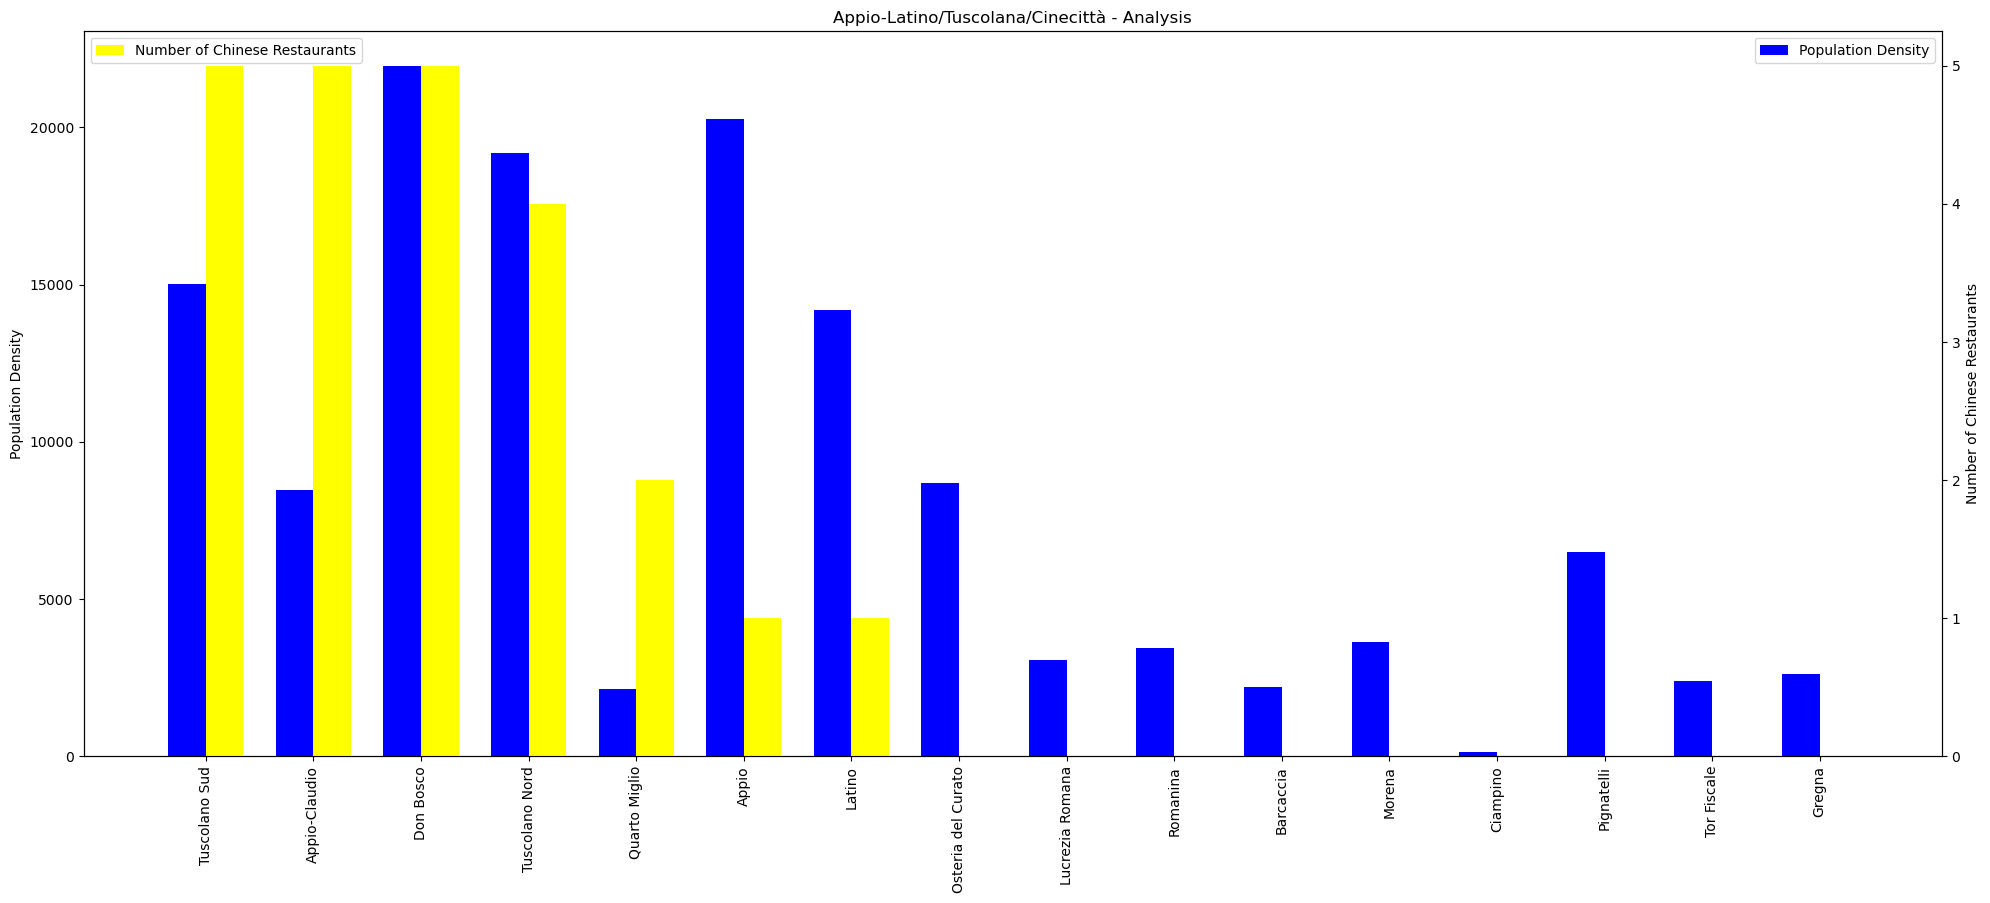

In [53]:
plot_df = Zone_Urbanistiche_Mun_7_df.sort_values('Number of Chinese Restaurants', ascending=False)
labels = plot_df['DENOMINAZI'].drop([16], axis=0)
dens = plot_df['Density'].drop([16], axis=0)
number = plot_df['Number of Chinese Restaurants'].drop([16], axis=0)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams["figure.figsize"] = (20,8)

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.bar(x - width/2, dens, width, label='Population Density', color='blue')
ax_right.bar(x + width/2, number, width, label='Number of Chinese Restaurants', color='yellow')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_left.set_ylabel('Population Density')
ax_right.set_ylabel('Number of Chinese Restaurants')
ax_left.set_title('Appio-Latino/Tuscolana/Cinecittà - Analysis')

ax_left.set_xticks(x)
ax_left.set_xticklabels(labels)
ax_left.legend()
ax_right.legend(loc='upper left')


fig.tight_layout()

for tick in ax_left.get_xticklabels():
    tick.set_rotation(90)

plt.show()

## Based on the above graph, both "APPIO" and "LATINO" have a very high population density and only 1 Chinese Restaurant each. These areas could be a good option.

# Now, let's get more general information about these 4 areas.
# I am going to explore the following Foursquare Categories:
## - Art & Entertainment
## - College&University
## - Night life Spot
## - Professional & other Places
## - Travel and Transport

In [76]:
cat_id_list = ['4d4b7104d754a06370d81259',     #Art & Entertainment
               '4d4b7105d754a06372d81259',     #College&University
               '4d4b7105d754a06376d81259',     #Night life Spot
               '4d4b7105d754a06375d81259',     #Professional & other Places
               '4d4b7105d754a06379d81259']     #Travel and Transport

cat_dict = {'4d4b7104d754a06370d81259' : 'Art & Entertainment',
            '4d4b7105d754a06372d81259' : 'College&University',
            '4d4b7105d754a06376d81259' : 'Night life Spot',
            '4d4b7105d754a06375d81259' : 'Professional & other Places',
            '4d4b7105d754a06379d81259' : 'Travel and Transport'}

venues_list=[]
x=0

R = len(Zone_Urbanistiche_Mun_1_df)

for cat_id in cat_id_list:
    
    print('I am retrieving information about {}'.format(cat_dict[cat_id]))

    for x in range(0,R):
        lat = Zone_Urbanistiche_Mun_1_df['Latitude'][x]
        lng = Zone_Urbanistiche_Mun_1_df['Longitude'][x]


        url_get = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
                cat_id, 
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng,
                ACCESS_TOKEN, 
                VERSION, 
                radius, 
                LIMIT)

        results = requests.get(url_get).json()
        check = results['meta']
            #print(check)

        lim = len(results["response"]['venues'])


        for p in range(0,lim):
            try:
                venue_name = results["response"]['venues'][p]['name'] #venue name
                venue_address = results["response"]['venues'][p]['location']['address'] #venue address
                venue_lat = results["response"]['venues'][p]['location']['lat'] #venue latitude
                venue_lon = results["response"]['venues'][p]['location']['lng'] #venue longitude
                venue_CAP = results["response"]['venues'][p]['location']['postalCode'] #CAP
                venue_cat = results["response"]['venues'][p]['categories'][0]['name'] #venue category
                venue_cat_id = results["response"]['venues'][p]['categories'][0]['id'] #venue cat id
                venue_id = results["response"]['venues'][p]['id'] #venue id
            except:
                pass




            venues_list.append([(
                venue_name, 
                venue_address, 
                venue_lat, 
                venue_lon, 
                venue_CAP, 
                venue_cat,
                venue_cat_id,
                venue_id)])

            Venues_df_Mun_1 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            Venues_df_Mun_1.columns = ['Name', 
                              'Address', 
                              'Latitude', 
                              'Longitude',
                              'CAP',
                              'Category', 
                              'Category ID',
                              'Venue ID']

    print('Information about {} acquired!'.format(cat_dict[cat_id]))



I am retrieving information about Art & Entertainment
Information about Art & Entertainment acquired!
I am retrieving information about College&University
Information about College&University acquired!
I am retrieving information about Night life Spot
Information about Night life Spot acquired!
I am retrieving information about Professional & other Places
Information about Professional & other Places acquired!
I am retrieving information about Travel and Transport
Information about Travel and Transport acquired!


In [90]:
Venues_df_Mun_1.drop_duplicates(subset='Venue ID', keep='first', inplace=True)
Venues_df_Mun_1 = Venues_df_Mun_1.reset_index()
Venues_df_Mun_1.drop(Venues_df_Mun_1.columns[0], axis=1, inplace=True)
#Venues_df_Mun_1.to_csv('Venues_df_Mun_1.csv')
Venues_df_Mun_1

Name  \
0    Basilica of St. Mary of the Angels and the Mar...   
1                     Museo delle Terme di Diocleziano   
2                             The Space Cinema Moderno   
3               Museo Numismatico della Zecca Italiana   
4     Chiostro Michelangiolesco - Terme di Diocleziano   
..                                                 ...   
700                                      Hotel Pacific   
701                                        At Simona's   
702                                       Momo Vatican   
703                                   Lauretum Turismo   
704                                   Hotel Nova Domus   

                            Address   Latitude  Longitude    CAP  \
0                     Via Cernaia 9  41.903002  12.496685  00185   
1        Viale Enrico de Nicola, 79  41.902912  12.498882  00185   
2    Piazza Della Repubblica, 43-45  41.902387  12.496211  00184   
3               Via 20 Settembre 97  41.908984  12.500573  00185   
4        Viale Enrico de Nicola, 79  41.903345  12.498949  00185   
..                              ...        ...        ...    ...   
700       Via Gualtiero Serafino, 7  41.910665  12.446069  00136   
701               52 Viale Vaticano  41.904920  12.448943  00165   
702              Via Santamaura, 15  41.907899  12.453840  00192   
703  Viale delle Medaglie d'Oro 106  41.910944  12.444492  00136   
704            Via G. Savonarola 38  41.912032  12.450617  00195   

           Category               Category ID                  Venue ID  
0            Church  4bf58dd8d48988d132941735  4adcdac6f964a520175321e3  
1    History Museum  4bf58dd8d48988d190941735  4adcdac9f964a5204f5421e3  
2     Movie Theater  4bf58dd8d48988d17f941735  4c9d0a2e54c8a1cd57e27f4b  
3            Museum  4bf58dd8d48988d181941735  4adcdacaf964a520665421e3  
4     Historic Site  4deefb944765f83613cdba6e  50ae4e91e4b05083be8f26a8  
..              ...                       ...                       ...  
700           Hotel  4bf58dd8d48988d1fa931735  4dade5461e7207bbeb05a9ae  
701           Hotel  4bf58dd8d48988d1fa931735  4adcdac0f964a520ad5121e3  
702  Boarding House  4f4530a74b9074f6e4fb0100  593d6be78c812a1b8349f6af  
703  General Travel  4bf58dd8d48988d1f6931735  4d218a252eb1f04dd4fff8c1  
704           Hotel  4bf58dd8d48988d1fa931735  4cffde5d7c563704ede2acf0  

[705 rows x 8 columns]

In [79]:
cat_id_list = ['4d4b7104d754a06370d81259',     #Art & Entertainment
               '4d4b7105d754a06372d81259',     #College&University
               '4d4b7105d754a06376d81259',     #Night life Spot
               '4d4b7105d754a06375d81259',     #Professional & other Places
               '4d4b7105d754a06379d81259']     #Travel and Transport

cat_dict = {'4d4b7104d754a06370d81259' : 'Art & Entertainment',
            '4d4b7105d754a06372d81259' : 'College&University',
            '4d4b7105d754a06376d81259' : 'Night life Spot',
            '4d4b7105d754a06375d81259' : 'Professional & other Places',
            '4d4b7105d754a06379d81259' : 'Travel and Transport'}

venues_list=[]
x=0

R = len(Zone_Urbanistiche_Mun_2_df)

for cat_id in cat_id_list:
    
    print('I am retrieving information about {}'.format(cat_dict[cat_id]))

    for x in range(0,R):
        lat = Zone_Urbanistiche_Mun_2_df['Latitude'][x]
        lng = Zone_Urbanistiche_Mun_2_df['Longitude'][x]


        url_get = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
                cat_id, 
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng,
                ACCESS_TOKEN, 
                VERSION, 
                radius, 
                LIMIT)

        results = requests.get(url_get).json()
        check = results['meta']
            #print(check)

        lim = len(results["response"]['venues'])


        for p in range(0,lim):
            try:
                venue_name = results["response"]['venues'][p]['name'] #venue name
                venue_address = results["response"]['venues'][p]['location']['address'] #venue address
                venue_lat = results["response"]['venues'][p]['location']['lat'] #venue latitude
                venue_lon = results["response"]['venues'][p]['location']['lng'] #venue longitude
                venue_CAP = results["response"]['venues'][p]['location']['postalCode'] #CAP
                venue_cat = results["response"]['venues'][p]['categories'][0]['name'] #venue category
                venue_cat_id = results["response"]['venues'][p]['categories'][0]['id'] #venue cat id
                venue_id = results["response"]['venues'][p]['id'] #venue id
            except:
                pass




            venues_list.append([(
                venue_name, 
                venue_address, 
                venue_lat, 
                venue_lon, 
                venue_CAP, 
                venue_cat,
                venue_cat_id,
                venue_id)])

            Venues_df_Mun_2 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            Venues_df_Mun_2.columns = ['Name', 
                              'Address', 
                              'Latitude', 
                              'Longitude',
                              'CAP',
                              'Category', 
                              'Category ID',
                              'Venue ID']

    print('Information about {} acquired!'.format(cat_dict[cat_id]))


I am retrieving information about Art & Entertainment
Information about Art & Entertainment acquired!
I am retrieving information about College&University
Information about College&University acquired!
I am retrieving information about Night life Spot
Information about Night life Spot acquired!
I am retrieving information about Professional & other Places
Information about Professional & other Places acquired!
I am retrieving information about Travel and Transport
Information about Travel and Transport acquired!


In [91]:
Venues_df_Mun_2.drop_duplicates(subset='Venue ID', keep='first', inplace=True)
Venues_df_Mun_2 = Venues_df_Mun_2.reset_index()
Venues_df_Mun_2.drop(Venues_df_Mun_2.columns[0], axis=1, inplace=True)
#Venues_df_Mun_2.to_csv('Venues_df_Mun_2.csv')
Venues_df_Mun_2

Name  \
0                                             I.A.L.S.   
1                                      Stadio Flaminio   
2               Istituzione Universitaria dei Concerti   
3                           Casa Museo Alberto Moravia   
4    Museo Storico dell'Arma del Genio e dell'Archi...   
..                                                 ...   
441             Aldrovandi Palace Hotel Villa Borghese   
442                                        Capolinea 3   
443                   Campi Sportivi (linea Roma Nord)   
444                                   Hotel delle Muse   
445                                         Villa Duse   

                            Address   Latitude  Longitude    CAP  \
0          Via Cesare Fracassini 60  41.923255  12.469115  00195   
1       Viale dello Stadio Flaminio  41.926923  12.472283  00196   
2           50 Lungotevere Flaminio  41.923692  12.465753  00196   
3     Lungotevere della Vittoria, 1  41.921375  12.466328  00195   
4     31 Lungotevere della Vittoria  41.921150  12.461478  00195   
..                              ...        ...        ...    ...   
441        Via Ulisse Aldrovandi 15  41.918769  12.484784  00197   
442  Piazza Thorwaldsen, 00197 Roma  41.916697  12.479975  00197   
443              Via del Pentathlon  41.933126  12.491596  00197   
444          Via Tommaso Salvini 18  41.930250  12.492806  00197   
445         Via Alamanno Morelli, 1  41.929451  12.492727  00197   

                  Category               Category ID                  Venue ID  
0                    Hotel  4bf58dd8d48988d1fa931735  4cffde5d7c563704ede2acf0  
1           Soccer Stadium  4bf58dd8d48988d188941735  4adcdac9f964a5201b5421e3  
2    Performing Arts Venue  4bf58dd8d48988d1f2931735  4adcdad0f964a520125621e3  
3               Art Museum  4bf58dd8d48988d18f941735  4eeb62700cd6af4ce7e1143a  
4               Art Museum  4bf58dd8d48988d18f941735  4adcdacaf964a520725421e3  
..                     ...                       ...                       ...  
441                  Hotel  4bf58dd8d48988d1fa931735  4c53ea66728920a10222df81  
442               Bus Line  4bf58dd8d48988d12b951735  4ec264789a52cce4f4adbccf  
443     Light Rail Station  4bf58dd8d48988d1fc931735  4d5aca648e105941a7f9e0e1  
444                  Hotel  4bf58dd8d48988d1fa931735  4adcdabff964a5207d5121e3  
445                  Hotel  4bf58dd8d48988d1fa931735  4c8539f4d92ea0939fee6372  

[446 rows x 8 columns]

In [81]:
cat_id_list = ['4d4b7104d754a06370d81259',     #Art & Entertainment
               '4d4b7105d754a06372d81259',     #College&University
               '4d4b7105d754a06376d81259',     #Night life Spot
               '4d4b7105d754a06375d81259',     #Professional & other Places
               '4d4b7105d754a06379d81259']     #Travel and Transport

cat_dict = {'4d4b7104d754a06370d81259' : 'Art & Entertainment',
            '4d4b7105d754a06372d81259' : 'College&University',
            '4d4b7105d754a06376d81259' : 'Night life Spot',
            '4d4b7105d754a06375d81259' : 'Professional & other Places',
            '4d4b7105d754a06379d81259' : 'Travel and Transport'}

venues_list=[]
x=0

R = len(Zone_Urbanistiche_Mun_5_df)

for cat_id in cat_id_list:
    
    print('I am retrieving information about {}'.format(cat_dict[cat_id]))

    for x in range(0,R):
        lat = Zone_Urbanistiche_Mun_5_df['Latitude'][x]
        lng = Zone_Urbanistiche_Mun_5_df['Longitude'][x]


        url_get = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
                cat_id, 
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng,
                ACCESS_TOKEN, 
                VERSION, 
                radius, 
                LIMIT)

        results = requests.get(url_get).json()
        check = results['meta']
            #print(check)
        try:
            lim = len(results["response"]['venues'])
        except:
            lim = 15


        for p in range(0,lim):
            try:
                venue_name = results["response"]['venues'][p]['name'] #venue name
                venue_address = results["response"]['venues'][p]['location']['address'] #venue address
                venue_lat = results["response"]['venues'][p]['location']['lat'] #venue latitude
                venue_lon = results["response"]['venues'][p]['location']['lng'] #venue longitude
                venue_CAP = results["response"]['venues'][p]['location']['postalCode'] #CAP
                venue_cat = results["response"]['venues'][p]['categories'][0]['name'] #venue category
                venue_cat_id = results["response"]['venues'][p]['categories'][0]['id'] #venue cat id
                venue_id = results["response"]['venues'][p]['id'] #venue id
            except:
                pass




            venues_list.append([(
                venue_name, 
                venue_address, 
                venue_lat, 
                venue_lon, 
                venue_CAP, 
                venue_cat,
                venue_cat_id,
                venue_id)])

            Venues_df_Mun_5 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            Venues_df_Mun_5.columns = ['Name', 
                              'Address', 
                              'Latitude', 
                              'Longitude',
                              'CAP',
                              'Category', 
                              'Category ID',
                              'Venue ID']

    print('Information about {} acquired!'.format(cat_dict[cat_id]))


I am retrieving information about Art & Entertainment
Information about Art & Entertainment acquired!
I am retrieving information about College&University
Information about College&University acquired!
I am retrieving information about Night life Spot
Information about Night life Spot acquired!
I am retrieving information about Professional & other Places
Information about Professional & other Places acquired!
I am retrieving information about Travel and Transport
Information about Travel and Transport acquired!


In [92]:
Venues_df_Mun_5.drop_duplicates(subset='Venue ID', keep='first', inplace=True)
Venues_df_Mun_5 = Venues_df_Mun_5.reset_index()
Venues_df_Mun_5.drop(Venues_df_Mun_5.columns[0], axis=1, inplace=True)
#Venues_df_Mun_5.to_csv('Venues_df_Mun_5.csv')
Venues_df_Mun_5

Name                             Address  \
0                      Airport One                    Via Casilina 712   
1                       Il Geranio              Via dei Rododendri, 15   
2    Spazio Sociale 100celleAPERTE                 Via delle Resede, 5   
3                USD Sales "Parri"  Via del Pergolato, 112, 00172 Roma   
4                     Quasar Elite          Via Aristide Staderini, 83   
..                             ...                                 ...   
156             Metro Pigneto (MC)                     Via del Pigneto   
157                    Club Decru'                      Via Urbana 148   
158  Four Seasons Natura e Cultura    via Guglielmo degli Ubertini, 44   
159              Residenza Pigneta       Via Castruccio Castracane, 36   
160                    Amica Hotel              Piazzale Prenestino 15   

      Latitude  Longitude    CAP               Category  \
0    41.874355  12.558995  00197                  Hotel   
1    41.886361  12.567630  00171             Non-Profit   
2    41.886734  12.563003  00171  General Entertainment   
3    41.886762  12.578737  00172                Stadium   
4    41.891089  12.587403  00155                 Arcade   
..         ...        ...    ...                    ...   
156  41.888700  12.527380  00176          Metro Station   
157  41.891500  12.533609  00184         General Travel   
158  41.889188  12.540572  00176         General Travel   
159  41.888348  12.529710  00176        Bed & Breakfast   
160  41.891187  12.526945  00176                  Hotel   

                  Category ID                  Venue ID  
0    4bf58dd8d48988d1fa931735  4c8539f4d92ea0939fee6372  
1    50328a8e91d4c4b30a586d6c  4d9dff028efaa143198973b7  
2    4bf58dd8d48988d1f1931735  4d6976af6297721ed622c9b5  
3    4bf58dd8d48988d184941735  4f196864e4b0a9e6db3cbab6  
4    4bf58dd8d48988d1e1931735  4d320cb398336dcb6d441ff0  
..                        ...                       ...  
156  4bf58dd8d48988d1fd931735  55448c5c498e0032a3248971  
157  4bf58dd8d48988d1f6931735  51ba5483498e2611a81b7392  
158  4bf58dd8d48988d1f6931735  50475f33e0e288d1c78cdba1  
159  4bf58dd8d48988d1f8931735  57efb1d0498e549380b62ebb  
160  4bf58dd8d48988d1fa931735  519cc731498e50ad5c2094df  

[161 rows x 8 columns]

In [83]:
cat_id_list = ['4d4b7104d754a06370d81259',     #Art & Entertainment
               '4d4b7105d754a06372d81259',     #College&University
               '4d4b7105d754a06376d81259',     #Night life Spot
               '4d4b7105d754a06375d81259',     #Professional & other Places
               '4d4b7105d754a06379d81259']     #Travel and Transport

cat_dict = {'4d4b7104d754a06370d81259' : 'Art & Entertainment',
            '4d4b7105d754a06372d81259' : 'College&University',
            '4d4b7105d754a06376d81259' : 'Night life Spot',
            '4d4b7105d754a06375d81259' : 'Professional & other Places',
            '4d4b7105d754a06379d81259' : 'Travel and Transport'}

venues_list=[]
x=0

R = len(Zone_Urbanistiche_Mun_7_df)

for cat_id in cat_id_list:
    
    print('I am retrieving information about {}'.format(cat_dict[cat_id]))

    for x in range(0,R):
        lat = Zone_Urbanistiche_Mun_7_df['Latitude'][x]
        lng = Zone_Urbanistiche_Mun_7_df['Longitude'][x]


        url_get = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
                cat_id, 
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng,
                ACCESS_TOKEN, 
                VERSION, 
                radius, 
                LIMIT)

        results = requests.get(url_get).json()
        check = results['meta']
            #print(check)

        try:
            lim = len(results["response"]['venues'])
        except:
            lim = 15


        for p in range(0,lim):
            try:
                venue_name = results["response"]['venues'][p]['name'] #venue name
                venue_address = results["response"]['venues'][p]['location']['address'] #venue address
                venue_lat = results["response"]['venues'][p]['location']['lat'] #venue latitude
                venue_lon = results["response"]['venues'][p]['location']['lng'] #venue longitude
                venue_CAP = results["response"]['venues'][p]['location']['postalCode'] #CAP
                venue_cat = results["response"]['venues'][p]['categories'][0]['name'] #venue category
                venue_cat_id = results["response"]['venues'][p]['categories'][0]['id'] #venue cat id
                venue_id = results["response"]['venues'][p]['id'] #venue id
            except:
                pass




            venues_list.append([(
                venue_name, 
                venue_address, 
                venue_lat, 
                venue_lon, 
                venue_CAP, 
                venue_cat,
                venue_cat_id,
                venue_id)])

            Venues_df_Mun_7 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            Venues_df_Mun_7.columns = ['Name', 
                              'Address', 
                              'Latitude', 
                              'Longitude',
                              'CAP',
                              'Category', 
                              'Category ID',
                              'Venue ID']

    print('Information about {} acquired!'.format(cat_dict[cat_id]))


I am retrieving information about Art & Entertainment
Information about Art & Entertainment acquired!
I am retrieving information about College&University
Information about College&University acquired!
I am retrieving information about Night life Spot
Information about Night life Spot acquired!
I am retrieving information about Professional & other Places
Information about Professional & other Places acquired!
I am retrieving information about Travel and Transport
Information about Travel and Transport acquired!


In [93]:
Venues_df_Mun_7.drop_duplicates(subset='Venue ID', keep='first', inplace=True)
Venues_df_Mun_7 = Venues_df_Mun_7.reset_index()
Venues_df_Mun_7.drop(Venues_df_Mun_7.columns[0], axis=1, inplace=True)
#Venues_df_Mun_7.to_csv('Venues_df_Mun_7.csv')
Venues_df_Mun_7

Name                 Address   Latitude  \
0                             radio godot  Piazzale Prenestino 15  41.891187   
1                          Capodanno Roma       Via Coriolano, 22  41.873515   
2                        Nosilence Eventi    Via Coriolano, 20/22  41.873515   
3                             Teatro Roma        Via Umbertide, 3  41.873943   
4                                 Trianon    Via Muzio Scevola 29  41.875237   
..                                    ...                     ...        ...   
288                     Yellow Apartments          Via Fregene 16  41.881862   
289                    Cogli l'attico B&B            Via Gabi, 32  41.881386   
290                     Hotel Palace 2000      Via Campobello, 37  41.880712   
291  Apartment 'Sakura' Rome Accomodation           Via Clelia 46  41.873160   
292                     Oceanitis Agenzia   Via Tommaso da Celano  41.870397   

     Longitude    CAP         Category               Category ID  \
0    12.526945  00176            Hotel  4bf58dd8d48988d1fa931735   
1    12.527066  00181           Office  4bf58dd8d48988d124941735   
2    12.527066  00142           Office  4bf58dd8d48988d124941735   
3    12.530859  00181          Theater  4bf58dd8d48988d137941735   
4    12.526345  00181    Movie Theater  4bf58dd8d48988d17f941735   
..         ...    ...              ...                       ...   
288  12.509810  00183            Hotel  4bf58dd8d48988d1fa931735   
289  12.509046  00183  Bed & Breakfast  4bf58dd8d48988d1f8931735   
290  12.511007  00040            Hotel  4bf58dd8d48988d1fa931735   
291  12.513836  00181  Bed & Breakfast  4bf58dd8d48988d1f8931735   
292  12.515891  00179    Travel Agency  4f04b08c2fb6e1c99f3db0bd   

                     Venue ID  
0    519cc731498e50ad5c2094df  
1    50c755dde4b01e00708ff334  
2    50c7541de4b072dfb88396a3  
3    4cab6cb944a8224b59dd2d40  
4    4adcdad1f964a520235621e3  
..                        ...  
288  590e3d3c1de76577cc04f335  
289  4e10c2491838f8ad81558b0e  
290  4f26c8e9e4b0d609c8d91faa  
291  4f48a813e4b0426dbb1fd7f7  
292  51516f20e4b08df1a016a151  

[293 rows x 8 columns]

## The cell below is to retrieve the data whenever I need instead of going through the Foursquare API.

In [55]:
Venues_df_Mun_1 = pd.read_csv('Venues_df_Mun_1.csv')
Venues_df_Mun_1.drop(Venues_df_Mun_1.columns[0], axis=1, inplace=True)
Venues_df_Mun_2 = pd.read_csv('Venues_df_Mun_2.csv')
Venues_df_Mun_2.drop(Venues_df_Mun_2.columns[0], axis=1, inplace=True)
Venues_df_Mun_5 = pd.read_csv('Venues_df_Mun_5.csv')
Venues_df_Mun_5.drop(Venues_df_Mun_5.columns[0], axis=1, inplace=True)
Venues_df_Mun_7 = pd.read_csv('Venues_df_Mun_7.csv')
Venues_df_Mun_7.drop(Venues_df_Mun_7.columns[0], axis=1, inplace=True)

In [56]:
i=0
temp_list = []
Venues_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urbana'])
for R in Venues_df_Mun_1['Name']:
    x=0
    plat = Venues_df_Mun_1['Latitude'].loc[i]
    plng = Venues_df_Mun_1['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Venues_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Venues_in_Zona_Urban.columns = ['Name','Zona Urbana']
Venues_df_Mun_1 = pd.merge(Venues_df_Mun_1,Venues_in_Zona_Urban,on='Name')
Venues_df_Mun_1

Name  \
0    Basilica of St. Mary of the Angels and the Mar...   
1                     Museo delle Terme di Diocleziano   
2                             The Space Cinema Moderno   
3               Museo Numismatico della Zecca Italiana   
4     Chiostro Michelangiolesco - Terme di Diocleziano   
..                                                 ...   
731                                 c'est le vie rooms   
732                                      Hotel Pacific   
733                                       Momo Vatican   
734                                   Lauretum Turismo   
735                                   Hotel Nova Domus   

                            Address   Latitude  Longitude    CAP  \
0                     Via Cernaia 9  41.903002  12.496685  00185   
1        Viale Enrico de Nicola, 79  41.902912  12.498882  00185   
2    Piazza Della Repubblica, 43-45  41.902387  12.496211  00184   
3               Via 20 Settembre 97  41.908984  12.500573  00185   
4        Viale Enrico de Nicola, 79  41.903345  12.498949  00185   
..                              ...        ...        ...    ...   
731                     via buccari  41.912342  12.453774  00100   
732       Via Gualtiero Serafino, 7  41.910665  12.446069  00136   
733              Via Santamaura, 15  41.907899  12.453840  00192   
734  Viale delle Medaglie d'Oro 106  41.910944  12.444492  00136   
735            Via G. Savonarola 38  41.912032  12.450617  00195   

            Category               Category ID                  Venue ID  \
0             Church  4bf58dd8d48988d132941735  4adcdac6f964a520175321e3   
1     History Museum  4bf58dd8d48988d190941735  4adcdac9f964a5204f5421e3   
2      Movie Theater  4bf58dd8d48988d17f941735  4c9d0a2e54c8a1cd57e27f4b   
3             Museum  4bf58dd8d48988d181941735  4adcdacaf964a520665421e3   
4      Historic Site  4deefb944765f83613cdba6e  50ae4e91e4b05083be8f26a8   
..               ...                       ...                       ...   
731  Bed & Breakfast  4bf58dd8d48988d1f8931735  511d82bde4b07a9f9b0b395e   
732            Hotel  4bf58dd8d48988d1fa931735  4dade5461e7207bbeb05a9ae   
733   Boarding House  4f4530a74b9074f6e4fb0100  593d6be78c812a1b8349f6af   
734   General Travel  4bf58dd8d48988d1f6931735  4d218a252eb1f04dd4fff8c1   
735            Hotel  4bf58dd8d48988d1fa931735  4cffde5d7c563704ede2acf0   

    Zona Urbana  
0            1f  
1            1f  
2            1e  
3            1f  
4            1f  
..          ...  
731         17b  
732         17c  
733         17c  
734         19a  
735         17c  

[736 rows x 9 columns]

In [57]:
i=0
temp_list = []
Venues_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urbana'])
for R in Venues_df_Mun_2['Name']:
    x=0
    plat = Venues_df_Mun_2['Latitude'].loc[i]
    plng = Venues_df_Mun_2['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Venues_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Venues_in_Zona_Urban.columns = ['Name','Zona Urbana']
Venues_df_Mun_2 = pd.merge(Venues_df_Mun_2,Venues_in_Zona_Urban,on='Name')
Venues_df_Mun_2

Name  \
0                                             I.A.L.S.   
1                                      Stadio Flaminio   
2               Istituzione Universitaria dei Concerti   
3                           Casa Museo Alberto Moravia   
4    Museo Storico dell'Arma del Genio e dell'Archi...   
..                                                 ...   
459             Aldrovandi Palace Hotel Villa Borghese   
460                                        Capolinea 3   
461                   Campi Sportivi (linea Roma Nord)   
462                                   Hotel delle Muse   
463                                         Villa Duse   

                            Address   Latitude  Longitude    CAP  \
0          Via Cesare Fracassini 60  41.923255  12.469115  00195   
1       Viale dello Stadio Flaminio  41.926923  12.472283  00196   
2           50 Lungotevere Flaminio  41.923692  12.465753  00196   
3     Lungotevere della Vittoria, 1  41.921375  12.466328  00195   
4     31 Lungotevere della Vittoria  41.921150  12.461478  00195   
..                              ...        ...        ...    ...   
459        Via Ulisse Aldrovandi 15  41.918769  12.484784  00197   
460  Piazza Thorwaldsen, 00197 Roma  41.916697  12.479975  00197   
461              Via del Pentathlon  41.933126  12.491596  00197   
462          Via Tommaso Salvini 18  41.930250  12.492806  00197   
463         Via Alamanno Morelli, 1  41.929451  12.492727  00197   

                  Category               Category ID  \
0                    Hotel  4bf58dd8d48988d1fa931735   
1           Soccer Stadium  4bf58dd8d48988d188941735   
2    Performing Arts Venue  4bf58dd8d48988d1f2931735   
3               Art Museum  4bf58dd8d48988d18f941735   
4               Art Museum  4bf58dd8d48988d18f941735   
..                     ...                       ...   
459                  Hotel  4bf58dd8d48988d1fa931735   
460               Bus Line  4bf58dd8d48988d12b951735   
461     Light Rail Station  4bf58dd8d48988d1fc931735   
462                  Hotel  4bf58dd8d48988d1fa931735   
463                  Hotel  4bf58dd8d48988d1fa931735   

                     Venue ID Zona Urbana  
0    4cffde5d7c563704ede2acf0          2c  
1    4adcdac9f964a5201b5421e3          2a  
2    4adcdad0f964a520125621e3          2c  
3    4eeb62700cd6af4ce7e1143a         17b  
4    4adcdacaf964a520725421e3         17b  
..                        ...         ...  
459  4c53ea66728920a10222df81          2b  
460  4ec264789a52cce4f4adbccf          2x  
461  4d5aca648e105941a7f9e0e1          2y  
462  4adcdabff964a5207d5121e3          2b  
463  4c8539f4d92ea0939fee6372          2b  

[464 rows x 9 columns]

In [58]:
i=0
temp_list = []
Venues_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urbana'])
for R in Venues_df_Mun_5['Name']:
    x=0
    plat = Venues_df_Mun_5['Latitude'].loc[i]
    plng = Venues_df_Mun_5['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Venues_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Venues_in_Zona_Urban.columns = ['Name','Zona Urbana']
Venues_df_Mun_5 = pd.merge(Venues_df_Mun_5,Venues_in_Zona_Urban,on='Name')
Venues_df_Mun_5

Name                             Address  \
0                      Airport One                    Via Casilina 712   
1                       Il Geranio              Via dei Rododendri, 15   
2    Spazio Sociale 100celleAPERTE                 Via delle Resede, 5   
3                USD Sales "Parri"  Via del Pergolato, 112, 00172 Roma   
4                     Quasar Elite          Via Aristide Staderini, 83   
..                             ...                                 ...   
212             Metro Pigneto (MC)                     Via del Pigneto   
213                    Club Decru'                      Via Urbana 148   
214  Four Seasons Natura e Cultura    via Guglielmo degli Ubertini, 44   
215              Residenza Pigneta       Via Castruccio Castracane, 36   
216                    Amica Hotel              Piazzale Prenestino 15   

      Latitude  Longitude  CAP               Category  \
0    41.874355  12.558995  197                  Hotel   
1    41.886361  12.567630  171             Non-Profit   
2    41.886734  12.563003  171  General Entertainment   
3    41.886762  12.578737  172                Stadium   
4    41.891089  12.587403  155                 Arcade   
..         ...        ...  ...                    ...   
212  41.888700  12.527380  176          Metro Station   
213  41.891500  12.533609  184         General Travel   
214  41.889188  12.540572  176         General Travel   
215  41.888348  12.529710  176        Bed & Breakfast   
216  41.891187  12.526945  176                  Hotel   

                  Category ID                  Venue ID Zona Urbana  
0    4bf58dd8d48988d1fa931735  4c8539f4d92ea0939fee6372          7g  
1    50328a8e91d4c4b30a586d6c  4d9dff028efaa143198973b7          7a  
2    4bf58dd8d48988d1f1931735  4d6976af6297721ed622c9b5          7a  
3    4bf58dd8d48988d184941735  4f196864e4b0a9e6db3cbab6          7b  
4    4bf58dd8d48988d1e1931735  4d320cb398336dcb6d441ff0          7e  
..                        ...                       ...         ...  
212  4bf58dd8d48988d1fd931735  55448c5c498e0032a3248971          6a  
213  4bf58dd8d48988d1f6931735  51ba5483498e2611a81b7392          6a  
214  4bf58dd8d48988d1f6931735  50475f33e0e288d1c78cdba1          6a  
215  4bf58dd8d48988d1f8931735  57efb1d0498e549380b62ebb          6a  
216  4bf58dd8d48988d1fa931735  519cc731498e50ad5c2094df          6a  

[217 rows x 9 columns]

In [59]:
i=0
temp_list = []
Venues_in_Zona_Urban = pd.DataFrame(columns=['Name','Zona Urbana'])
for R in Venues_df_Mun_7['Name']:
    x=0
    plat = Venues_df_Mun_7['Latitude'].loc[i]
    plng = Venues_df_Mun_7['Longitude'].loc[i]
    p1 = Point(plng, plat)
    for P in zone_urbanistiche_shape['geometry']:
        poly = P        
        if p1.within(poly) == False:
            x=x+1
        else:
            zon_urb = zone_urbanistiche_shape['ZONA_URBAN'].loc[x]
            temp_list.append([(R,zon_urb)])       

    i=i+1
Venues_in_Zona_Urban = pd.DataFrame([item for temp_list in temp_list for item in temp_list])
Venues_in_Zona_Urban.columns = ['Name','Zona Urbana']
Venues_df_Mun_7 = pd.merge(Venues_df_Mun_7,Venues_in_Zona_Urban,on='Name')
Venues_df_Mun_7

Name                 Address   Latitude  \
0                             radio godot  Piazzale Prenestino 15  41.891187   
1                          Capodanno Roma       Via Coriolano, 22  41.873515   
2                        Nosilence Eventi    Via Coriolano, 20/22  41.873515   
3                             Teatro Roma        Via Umbertide, 3  41.873943   
4                                 Trianon    Via Muzio Scevola 29  41.875237   
..                                    ...                     ...        ...   
424                     Yellow Apartments          Via Fregene 16  41.881862   
425                    Cogli l'attico B&B            Via Gabi, 32  41.881386   
426                     Hotel Palace 2000      Via Campobello, 37  41.880712   
427  Apartment 'Sakura' Rome Accomodation           Via Clelia 46  41.873160   
428                     Oceanitis Agenzia   Via Tommaso da Celano  41.870397   

     Longitude  CAP         Category               Category ID  \
0    12.526945  176            Hotel  4bf58dd8d48988d1fa931735   
1    12.527066  181           Office  4bf58dd8d48988d124941735   
2    12.527066  142           Office  4bf58dd8d48988d124941735   
3    12.530859  181          Theater  4bf58dd8d48988d137941735   
4    12.526345  181    Movie Theater  4bf58dd8d48988d17f941735   
..         ...  ...              ...                       ...   
424  12.509810  183            Hotel  4bf58dd8d48988d1fa931735   
425  12.509046  183  Bed & Breakfast  4bf58dd8d48988d1f8931735   
426  12.511007   40            Hotel  4bf58dd8d48988d1fa931735   
427  12.513836  181  Bed & Breakfast  4bf58dd8d48988d1f8931735   
428  12.515891  179    Travel Agency  4f04b08c2fb6e1c99f3db0bd   

                     Venue ID Zona Urbana  
0    519cc731498e50ad5c2094df          6a  
1    50c755dde4b01e00708ff334          9b  
2    50c7541de4b072dfb88396a3          9b  
3    4cab6cb944a8224b59dd2d40          9b  
4    4adcdad1f964a520235621e3          9b  
..                        ...         ...  
424  590e3d3c1de76577cc04f335          9d  
425  4e10c2491838f8ad81558b0e          9d  
426  4f26c8e9e4b0d609c8d91faa          9d  
427  4f48a813e4b0426dbb1fd7f7          9e  
428  51516f20e4b08df1a016a151          9e  

[429 rows x 9 columns]

## I have now obtained a Data Frame containing Venues in the areas of our interest

In [60]:
temp_df_1 = Venues_df_Mun_1
temp_df_1['Municipio'] = 1
temp_df_2 = Venues_df_Mun_2
temp_df_2['Municipio'] = 2
temp_df_5 = Venues_df_Mun_5
temp_df_5['Municipio'] = 5
temp_df_7 = Venues_df_Mun_7
temp_df_7['Municipio'] = 7

frames = [temp_df_1,temp_df_2,temp_df_5,temp_df_7]

Venues_df = pd.concat(frames)
Venues_df = Venues_df.reset_index()
Venues_df.drop(Venues_df.columns[0], axis=1, inplace=True)

temp_df = pd.DataFrame(columns=['Zona Urbana','Denominazione'])
temp_df['Zona Urbana'] = zone_urbanistiche_df['ZONA_URBAN']
temp_df['Denominazione'] = zone_urbanistiche_df['DENOMINAZI']
Venues_df = pd.merge(Venues_df, temp_df, on='Zona Urbana')
Venues_df

Name  \
0     Basilica of St. Mary of the Angels and the Mar...   
1                      Museo delle Terme di Diocleziano   
2                Museo Numismatico della Zecca Italiana   
3      Chiostro Michelangiolesco - Terme di Diocleziano   
4                               Travel Blogger Elevator   
...                                                 ...   
1841                                             HMedia   
1842                                          X Esempio   
1843                           B&B Hotel Roma Cinecittà   
1844                                   Low Cost Parking   
1845                    Centro Odontoiatrico Maria Ezza   

                               Address   Latitude  Longitude    CAP  \
0                        Via Cernaia 9  41.903002  12.496685  00185   
1           Viale Enrico de Nicola, 79  41.902912  12.498882  00185   
2                  Via 20 Settembre 97  41.908984  12.500573  00185   
3           Viale Enrico de Nicola, 79  41.903345  12.498949  00185   
4          Via Marsala, 22, 00185 Roma  41.903075  12.501396  00185   
...                                ...        ...        ...    ...   
1841                  Via Anagnina, 16  41.838770  12.588420    173   
1842                   Via Mormanno 11  41.841816  12.584066    173   
1843               Via Tuscolana, 1782  41.842855  12.583830    173   
1844               via. di ciampino 70  41.810350  12.582473    178   
1845  Via Monte Albino, 18, 00178 Roma  41.857919  12.538764    178   

                   Category               Category ID  \
0                    Church  4bf58dd8d48988d132941735   
1            History Museum  4bf58dd8d48988d190941735   
2                    Museum  4bf58dd8d48988d181941735   
3             Historic Site  4deefb944765f83613cdba6e   
4     General Entertainment  4bf58dd8d48988d1f1931735   
...                     ...                       ...   
1841                 Office  4bf58dd8d48988d124941735   
1842                 Office  4bf58dd8d48988d124941735   
1843                  Hotel  4bf58dd8d48988d1fa931735   
1844                Parking  4c38df4de52ce0d596b336e1   
1845               Building  4bf58dd8d48988d130941735   

                      Venue ID Zona Urbana  Municipio    Denominazione  
0     4adcdac6f964a520175321e3          1f          1     XX Settembre  
1     4adcdac9f964a5204f5421e3          1f          1     XX Settembre  
2     4adcdacaf964a520665421e3          1f          1     XX Settembre  
3     50ae4e91e4b05083be8f26a8          1f          1     XX Settembre  
4     4f3524b6e4b0cd0fe8085811          1f          1     XX Settembre  
...                        ...         ...        ...              ...  
1841  4e76e869a809582dd6954f2c         10e          7  Lucrezia Romana  
1842  4e31b30c1495a9fd30d1a067         10e          7  Lucrezia Romana  
1843  4bd76693304fce72f68033ab         10e          7  Lucrezia Romana  
1844  4c78f06a2d3ba143c97c8cd0         10x          7         Ciampino  
1845  4edcf97829c2b9122b77aafc          9c          7      Tor Fiscale  

[1846 rows x 11 columns]

## Let's prepare the data for a K Neighbour Clustering Algorithm
## This is done by giving a binary value [0,1] for each Venue Category

In [63]:
Venues_onehot_df = pd.get_dummies(Venues_df['Category'])
Venues_onehot_df['Name'] = Venues_df['Name']
Venues_onehot_df['Denominazione'] = Venues_df['Denominazione']
Venues_onehot_df['Zona Urbana'] = Venues_df['Zona Urbana']
Venues_onehot_df['Municipio'] = Venues_df['Municipio']
fixed_columns = [Venues_onehot_df.columns[-4]] + [Venues_onehot_df.columns[-3]] + [Venues_onehot_df.columns[-2]] + [Venues_onehot_df.columns[-1]] + list(Venues_onehot_df.columns[0:199])
Venues_onehot_df = Venues_onehot_df[fixed_columns]
Venues_onehot_df

Name    Denominazione  \
0     Basilica of St. Mary of the Angels and the Mar...     XX Settembre   
1                      Museo delle Terme di Diocleziano     XX Settembre   
2                Museo Numismatico della Zecca Italiana     XX Settembre   
3      Chiostro Michelangiolesco - Terme di Diocleziano     XX Settembre   
4                               Travel Blogger Elevator     XX Settembre   
...                                                 ...              ...   
1841                                             HMedia  Lucrezia Romana   
1842                                          X Esempio  Lucrezia Romana   
1843                           B&B Hotel Roma Cinecittà  Lucrezia Romana   
1844                                   Low Cost Parking         Ciampino   
1845                    Centro Odontoiatrico Maria Ezza      Tor Fiscale   

     Zona Urbana  Municipio  Advertising Agency  Airport  American Restaurant  \
0             1f          1                   0        0                    0   
1             1f          1                   0        0                    0   
2             1f          1                   0        0                    0   
3             1f          1                   0        0                    0   
4             1f          1                   0        0                    0   
...          ...        ...                 ...      ...                  ...   
1841         10e          7                   0        0                    0   
1842         10e          7                   0        0                    0   
1843         10e          7                   0        0                    0   
1844         10x          7                   0        0                    0   
1845          9c          7                   0        0                    0   

      Animal Shelter  Arcade  Art Gallery  ...  University  Vacation Rental  \
0                  0       0            0  ...           0                0   
1                  0       0            0  ...           0                0   
2                  0       0            0  ...           0                0   
3                  0       0            0  ...           0                0   
4                  0       0            0  ...           0                0   
...              ...     ...          ...  ...         ...              ...   
1841               0       0            0  ...           0                0   
1842               0       0            0  ...           0                0   
1843               0       0            0  ...           0                0   
1844               0       0            0  ...           0                0   
1845               0       0            0  ...           0                0   

      Veterinarian  Voting Booth  Warehouse  Wine Bar  Wine Shop  Winery  \
0                0             0          0         0          0       0   
1                0             0          0         0          0       0   
2                0             0          0         0          0       0   
3                0             0          0         0          0       0   
4                0             0          0         0          0       0   
...            ...           ...        ...       ...        ...     ...   
1841             0             0          0         0          0       0   
1842             0             0          0         0          0       0   
1843             0             0          0         0          0       0   
1844             0             0          0         0          0       0   
1845             0             0          0         0          0       0   

      Women's Store  Zoo  
0                 0    0  
1                 0    0  
2                 0    0  
3                 0    0  
4                 0    0  
...             ...  ...  
1841              0    0  
1842              0    0  
1843              0    0  
1844              0    0  
1845  

## Then I group the data by Zona Urbana and I get the mean of the occurences for each Category

In [65]:
Venues_onehot_grouped_df = Venues_onehot_df.groupby('Denominazione').mean().reset_index()
#Venues_onehot_grouped_df.drop(test.columns[1], axis=1, inplace=True)
Venues_onehot_grouped_df

Denominazione  Municipio  Advertising Agency   Airport  \
0                    Alessandrina   5.000000            0.000000  0.000000   
1               Appia Antica Nord   7.000000            0.000000  0.000000   
2                           Appio   6.812500            0.000000  0.000000   
3                   Appio-Claudio   7.000000            0.000000  0.000000   
4                        Aventino   1.000000            0.000000  0.000000   
5                       Barcaccia   7.000000            0.000000  0.000000   
6                   Casal Bertone   2.000000            0.000000  0.000000   
7                        Casilino   5.000000            0.000000  0.000000   
8                           Celio   1.162162            0.000000  0.000000   
9                      Centocelle   5.000000            0.000000  0.000000   
10  Centro Direzionale Centocelle   6.600000            0.000000  0.066667   
11                 Centro Storico   1.007042            0.000000  0.000000   
12                       Ciampino   7.000000            0.000000  0.000000   
13                 Della Vittoria   1.150000            0.000000  0.000000   
14                      Don Bosco   7.000000            0.000000  0.000000   
15                           Eroi   1.000000            0.000000  0.000000   
16                      Esquilino   1.150376            0.000000  0.000000   
17                       Flaminio   2.000000            0.000000  0.000000   
18                   Gianicolense   1.000000            0.000000  0.000000   
19                       Gordiani   5.000000            0.000000  0.000000   
20                         Gregna   7.000000            0.000000  0.000000   
21                     La Rustica   5.000000            0.000000  0.000000   
22                         Latino   7.000000            0.000000  0.000000   
23                Lucrezia Romana   7.000000            0.000000  0.000000   
24                Medaglie d' Oro   1.000000            0.000000  0.000000   
25                         Morena   7.000000            0.000000  0.000000   
26                      Nomentano   2.000000            0.000000  0.000000   
27                            Omo   5.000000            0.000000  0.000000   
28             Osteria del Curato   7.000000            0.000000  0.000000   
29                       Ostiense   1.000000            0.000000  0.000000   
30                        Parioli   2.000000            0.015873  0.000000   
31                     Pignatelli   7.000000            0.000000  0.000000   
32                          Prati   1.000000            0.000000  0.000000   
33                       Quadraro   5.000000            0.000000  0.000000   
34                  Quarto Miglio   7.000000            0.000000  0.000000   
35                       Romanina   7.000000            0.000000  0.000000   
36                     S. Lorenzo   2.000000            0.018519  0.000000   
37                        Salario   1.985075            0.000000  0.000000   
38                      Testaccio   1.000000            0.000000  0.000000   
39                    Tor Fiscale   7.000000            0.000000  0.000000   
40                   Tor Sapienza   5.000000            0.000000  0.000000   
41                  Tor Tre Teste   5.000000            0.000000  0.000000   
42                  Torpignattara   5.026316            0.000000  0.000000   
43                     Trastevere   1.000000            0.000000  0.000000   
44                        Trieste   2.000000            0.000000  0.000000   
45                 Tuscolano Nord   7.000000            0.000000  0.000000   
46                  Tuscolano Sud   6.933333            0.000000  0.000000   
47                     Università   2.000000            0.000000  0.000000   
48                         Verano   2.000000            0.000000  0.000000   
49                      Villa Ada   2.000000            0.000000  0.000000   
50                 Villa Borghese   2.0000

## Since we have 4 areas I will set the K value equal to 4.

In [66]:
# set number of clusters
kclusters = 4

kclust_df = Venues_onehot_grouped_df.drop(Venues_onehot_grouped_df.columns[0], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kclust_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 3, 1, 0, 2, 3, 2])

In [67]:
Venues_grouped_df = Venues_onehot_df.groupby('Denominazione').sum().reset_index()
Venues_grouped_df.insert(1, 'Cluster Labels', kmeans.labels_)
temp_df = pd.DataFrame(columns=['Municipio','Denominazione'])
temp_df['Municipio'] = zone_urbanistiche_df['MUNICIPIO']
temp_df['Denominazione'] = zone_urbanistiche_df['DENOMINAZI']
Venues_grouped_df = pd.merge(Venues_grouped_df, temp_df, on='Denominazione')
Venues_grouped_df.insert(1, 'Municipio', Venues_grouped_df['Municipio_y'] )
Venues_grouped_df.drop(Venues_grouped_df.columns[3], axis=1, inplace=True)
Venues_grouped_df.drop(Venues_grouped_df.columns[-1], axis=1, inplace=True)
Venues_grouped_df

Denominazione Municipio  Cluster Labels  \
0                    Alessandrina         5               2   
1               Appia Antica Nord         8               1   
2                           Appio         7               1   
3                   Appio-Claudio         7               1   
4                        Aventino         1               3   
5                       Barcaccia         7               1   
6                   Casal Bertone         4               0   
7                        Casilino         5               2   
8                           Celio         1               3   
9                      Centocelle         5               2   
10  Centro Direzionale Centocelle         5               1   
11                 Centro Storico         1               3   
12                       Ciampino         7               1   
13                 Della Vittoria         1               3   
14                      Don Bosco         7               1   
15                           Eroi         1               3   
16                      Esquilino         1               3   
17                       Flaminio         2               0   
18                   Gianicolense        12               3   
19                       Gordiani         5               2   
20                         Gregna         7               1   
21                     La Rustica         5               2   
22                         Latino         7               1   
23                Lucrezia Romana         7               1   
24                Medaglie d' Oro        14               3   
25                         Morena         7               1   
26                      Nomentano         2               0   
27                            Omo         5               2   
28             Osteria del Curato         7               1   
29                       Ostiense         8               3   
30                        Parioli         2               0   
31                     Pignatelli         7               1   
32                          Prati         1               3   
33                       Quadraro         5               2   
34                  Quarto Miglio         7               1   
35                       Romanina         7               1   
36                     S. Lorenzo         2               0   
37                        Salario         2               0   
38                      Testaccio         1               3   
39                    Tor Fiscale         7               1   
40                   Tor Sapienza         5               2   
41                  Tor Tre Teste         5               2   
42                  Torpignattara         5               2   
43                     Trastevere         1               3   
44                        Trieste         2               0   
45                 Tuscolano Nord         7               1   
46                  Tuscolano Sud         7               1   
47                     Università         2               0   
48                         Verano         2               0   
49                      Villa Ada         2               0   
50                 Villa Borghese         2               0   
51             Villaggio Olimpico         2               0   
52                   XX Settembre         1               3   
53              Zona Archeologica         1               3   

    Advertising Agency  Airport  American Restaurant  Animal Shelter  Arcade  \
0                    0        0                    0               0       0   
1                    0        0                    0               0       0   
2                    0        0                    0               0       0   
3                    0        0                    0               0       0   
4                    0        0                    0               0       0   
5                    0        0                    0               0      

## It's pretty Amazing how the clustering algorithm is separating pretty well the areas between them. The Municipio number is very consistent inside each Cluster!

In [68]:
Venues_grouped_df.loc[Venues_grouped_df['Cluster Labels'] == 0]

Denominazione Municipio  Cluster Labels  Advertising Agency  Airport  \
6        Casal Bertone         4               0                   0        0   
17            Flaminio         2               0                   0        0   
26           Nomentano         2               0                   0        0   
30             Parioli         2               0                   1        0   
36          S. Lorenzo         2               0                   1        0   
37             Salario         2               0                   0        0   
44             Trieste         2               0                   0        0   
47          Università         2               0                   0        0   
48              Verano         2               0                   0        0   
49           Villa Ada         2               0                   0        0   
50      Villa Borghese         2               0                   0        0   
51  Villaggio Olimpico         2               0                   0        0   

    American Restaurant  Animal Shelter  Arcade  Art Gallery  Art Museum  ...  \
6                     0               0       0            0           0  ...   
17                    0               0       1            0           1  ...   
26                    0               0       0            1           1  ...   
30                    0               0       0            0           1  ...   
36                    0               0       0            0           0  ...   
37                    0               0       0            0           1  ...   
44                    0               0       0            2           0  ...   
47                    0               0       0            0           0  ...   
48                    0               0       0            1           0  ...   
49                    0               0       0            0           0  ...   
50                    0               1       0            0           1  ...   
51                    0               0       0            1           0  ...   

    University  Vacation Rental  Veterinarian  Voting Booth  Warehouse  \
6            0                0             0             0          0   
17           0                0             0             0          0   
26           1                0             1             0          0   
30           1                0             0             0          0   
36           1                1             0             0          0   
37           1                0             0             1          0   
44           0                0             0             0          0   
47           0                0             0             0          0   
48           1                0             0             0          0   
49           0                0             0             0          0   
50           0                0             0             0          0   
51           0                0             1             0          0   

    Wine Bar  Wine Shop  Winery  Women's Store  Zoo  
6          0          0       0              0    0  
17         0          0       1              0    0  
26         2          0       0              0    0  
30         3          0       0              0    0  
36         2          0       0              0    0  
37         1          0       0              0    0  
44         2          0       1              1    0  
47         0          0       0              0    0  
48         0          0       0              0    0  
49         0          0       0              0    0  
50         0          0       0              0    1  
51         0          0       0              0    0  

[12 rows x 202 columns]

In [69]:
Venues_grouped_df.loc[Venues_grouped_df['Cluster Labels'] == 1]

Denominazione Municipio  Cluster Labels  \
1               Appia Antica Nord         8               1   
2                           Appio         7               1   
3                   Appio-Claudio         7               1   
5                       Barcaccia         7               1   
10  Centro Direzionale Centocelle         5               1   
12                       Ciampino         7               1   
14                      Don Bosco         7               1   
20                         Gregna         7               1   
22                         Latino         7               1   
23                Lucrezia Romana         7               1   
25                         Morena         7               1   
28             Osteria del Curato         7               1   
31                     Pignatelli         7               1   
34                  Quarto Miglio         7               1   
35                       Romanina         7               1   
39                    Tor Fiscale         7               1   
45                 Tuscolano Nord         7               1   
46                  Tuscolano Sud         7               1   

    Advertising Agency  Airport  American Restaurant  Animal Shelter  Arcade  \
1                    0        0                    0               0       0   
2                    0        0                    0               0       0   
3                    0        0                    0               0       0   
5                    0        0                    0               0       0   
10                   0        1                    0               0       0   
12                   0        0                    0               0       0   
14                   0        0                    0               0       0   
20                   0        0                    0               0       0   
22                   0        0                    0               0       0   
23                   0        0                    0               0       0   
25                   0        0                    0               0       0   
28                   0        0                    0               0       0   
31                   0        0                    0               0       0   
34                   0        0                    0               0       0   
35                   0        0                    0               0       0   
39                   0        0                    0               0       0   
45                   0        0                    0               0       0   
46                   0        0                    0               0       0   

    Art Gallery  Art Museum  ...  University  Vacation Rental  Veterinarian  \
1             0           0  ...           0                0             0   
2             1           0  ...           0                1             0   
3             0           0  ...           0                0             0   
5             0           0  ...           0                0             0   
10            0           0  ...           0                0             0   
12            0           0  ...           0                0             0   
14            0           0  ...           0                0             0   
20            0           0  ...           0                0             0   
22            1           0  ...           0                0             0   
23            0           0  ...           0                0             0   
25            0           0  ...           0                0             0   
28            0           0  ...           0                0             0   
31            0           0  ...           0                0             0   
34            0           0  ...           0                0             0   
35            0           0  ...           0                0             0   
39            0           0  ...     

In [70]:
Venues_grouped_df.loc[Venues_grouped_df['Cluster Labels'] == 2]

Denominazione Municipio  Cluster Labels  Advertising Agency  Airport  \
0    Alessandrina         5               2                   0        0   
7        Casilino         5               2                   0        0   
9      Centocelle         5               2                   0        0   
19       Gordiani         5               2                   0        0   
21     La Rustica         5               2                   0        0   
27            Omo         5               2                   0        0   
33       Quadraro         5               2                   0        0   
40   Tor Sapienza         5               2                   0        0   
41  Tor Tre Teste         5               2                   0        0   
42  Torpignattara         5               2                   0        0   

    American Restaurant  Animal Shelter  Arcade  Art Gallery  Art Museum  ...  \
0                     0               0       0            0           0  ...   
7                     0               0       0            0           0  ...   
9                     0               0       0            0           0  ...   
19                    0               0       0            1           0  ...   
21                    0               0       0            0           0  ...   
27                    0               0       0            0           0  ...   
33                    0               0       0            1           0  ...   
40                    0               0       0            0           0  ...   
41                    0               0       1            0           0  ...   
42                    0               0       0            2           0  ...   

    University  Vacation Rental  Veterinarian  Voting Booth  Warehouse  \
0            0                0             0             0          0   
7            0                0             0             0          0   
9            0                0             0             0          0   
19           0                0             1             0          0   
21           0                0             0             0          0   
27           0                0             0             0          0   
33           0                0             0             0          0   
40           0                0             0             0          0   
41           0                0             0             0          0   
42           0                1             0             0          0   

    Wine Bar  Wine Shop  Winery  Women's Store  Zoo  
0          0          0       0              0    0  
7          0          0       0              0    0  
9          3          0       0              0    0  
19         0          0       0              0    0  
21         0          0       0              0    0  
27         0          0       0              0    0  
33         0          0       0              0    0  
40         0          0       0              0    0  
41         0          0       0              0    0  
42         2          0       4              0    0  

[10 rows x 202 columns]

In [71]:
Venues_grouped_df.loc[Venues_grouped_df['Cluster Labels'] == 3]

Denominazione Municipio  Cluster Labels  Advertising Agency  Airport  \
4            Aventino         1               3                   0        0   
8               Celio         1               3                   0        0   
11     Centro Storico         1               3                   0        0   
13     Della Vittoria         1               3                   0        0   
15               Eroi         1               3                   0        0   
16          Esquilino         1               3                   0        0   
18       Gianicolense        12               3                   0        0   
24    Medaglie d' Oro        14               3                   0        0   
29           Ostiense         8               3                   0        0   
32              Prati         1               3                   0        0   
38          Testaccio         1               3                   0        0   
43         Trastevere         1               3                   0        0   
52       XX Settembre         1               3                   1        0   
53  Zona Archeologica         1               3                   0        0   

    American Restaurant  Animal Shelter  Arcade  Art Gallery  Art Museum  ...  \
4                     0               0       0            0           0  ...   
8                     0               0       0            0           0  ...   
11                    0               0       0            5           5  ...   
13                    0               0       0            0           3  ...   
15                    0               0       0            0           0  ...   
16                    0               0       0            2           2  ...   
18                    0               0       0            0           0  ...   
24                    0               0       0            0           0  ...   
29                    0               0       0            0           0  ...   
32                    0               0       0            0           0  ...   
38                    0               0       0            2           2  ...   
43                    0               0       0            1           1  ...   
52                    1               0       0            0           0  ...   
53                    0               0       0            0           0  ...   

    University  Vacation Rental  Veterinarian  Voting Booth  Warehouse  \
4            0                0             0             0          0   
8            2                0             0             0          0   
11           6                1             0             0          0   
13           0                0             0             0          1   
15           0                0             0             0          0   
16           1                1             0             0          0   
18           0                0             0             0          0   
24           0                0             0             0          0   
29           0                0             0             0          0   
32           2                0             0             0          0   
38           1                0             0             0          0   
43           1                1             0             0          0   
52           1                0             0             0          0   
53           0                0             0             0          0   

    Wine Bar  Wine Shop  Winery  Women's Store  Zoo  
4          1          0       0              0    0  
8          2          0       1              0    0  
11         3          0       0              0    0  
13         0          0       0              0    0  
15         0          0       0              0    0  
16         4          0       1              0    0  
18         0          0       0              0    0  
24         0          0       0              0  

## Therefore we can rename the Clusters according to the area:
## - Cluster 0: Parioli/Nomentano
## - Cluster 1: Appio-Latino/Tuscolana/Cinecittà
## - Cluster 2: Prenestino/Centocelle
## - Cluster 3: Centro Storico

In [79]:
test_df = Venues_grouped_df.groupby('Cluster Labels').sum().transpose()
test_df = pd.DataFrame(test_df)
test_df.sort_values(test_df.columns[0], ascending=False).head(20)

Cluster Labels              0    1   2   3
Hotel                      35   10   3  91
Office                     32   33   5  29
Bar                        21   14   7  25
Bed & Breakfast            18   21   3  58
General Travel             13    3   3   4
Pub                        13   15   5  16
Movie Theater              12    2   0   8
Wine Bar                   10    6   5  17
General Entertainment      10    6   4  16
Medical Center              9   11   4   3
College Classroom           9    0   1   2
Post Office                 9  144  65  11
Cocktail Bar                8    4   6  29
Bus Line                    8    4   2   4
Doctor's Office             7    7  13   8
School                      6    6   6   1
Embassy / Consulate         6    0   0   3
Event Space                 6    0   0   1
College Academic Building   6    1   1   6
Café                        5    2   3   1

## Now I want to plot the most common venue for each CLuster/Municipio and compare the numbers with the others.
## For example: the below graph shows the 20 most common Categories (from left to right) of venue in the Cluster 0 (Parioli/Nomentano). Each of the venue is also compared against the other Cluisters.

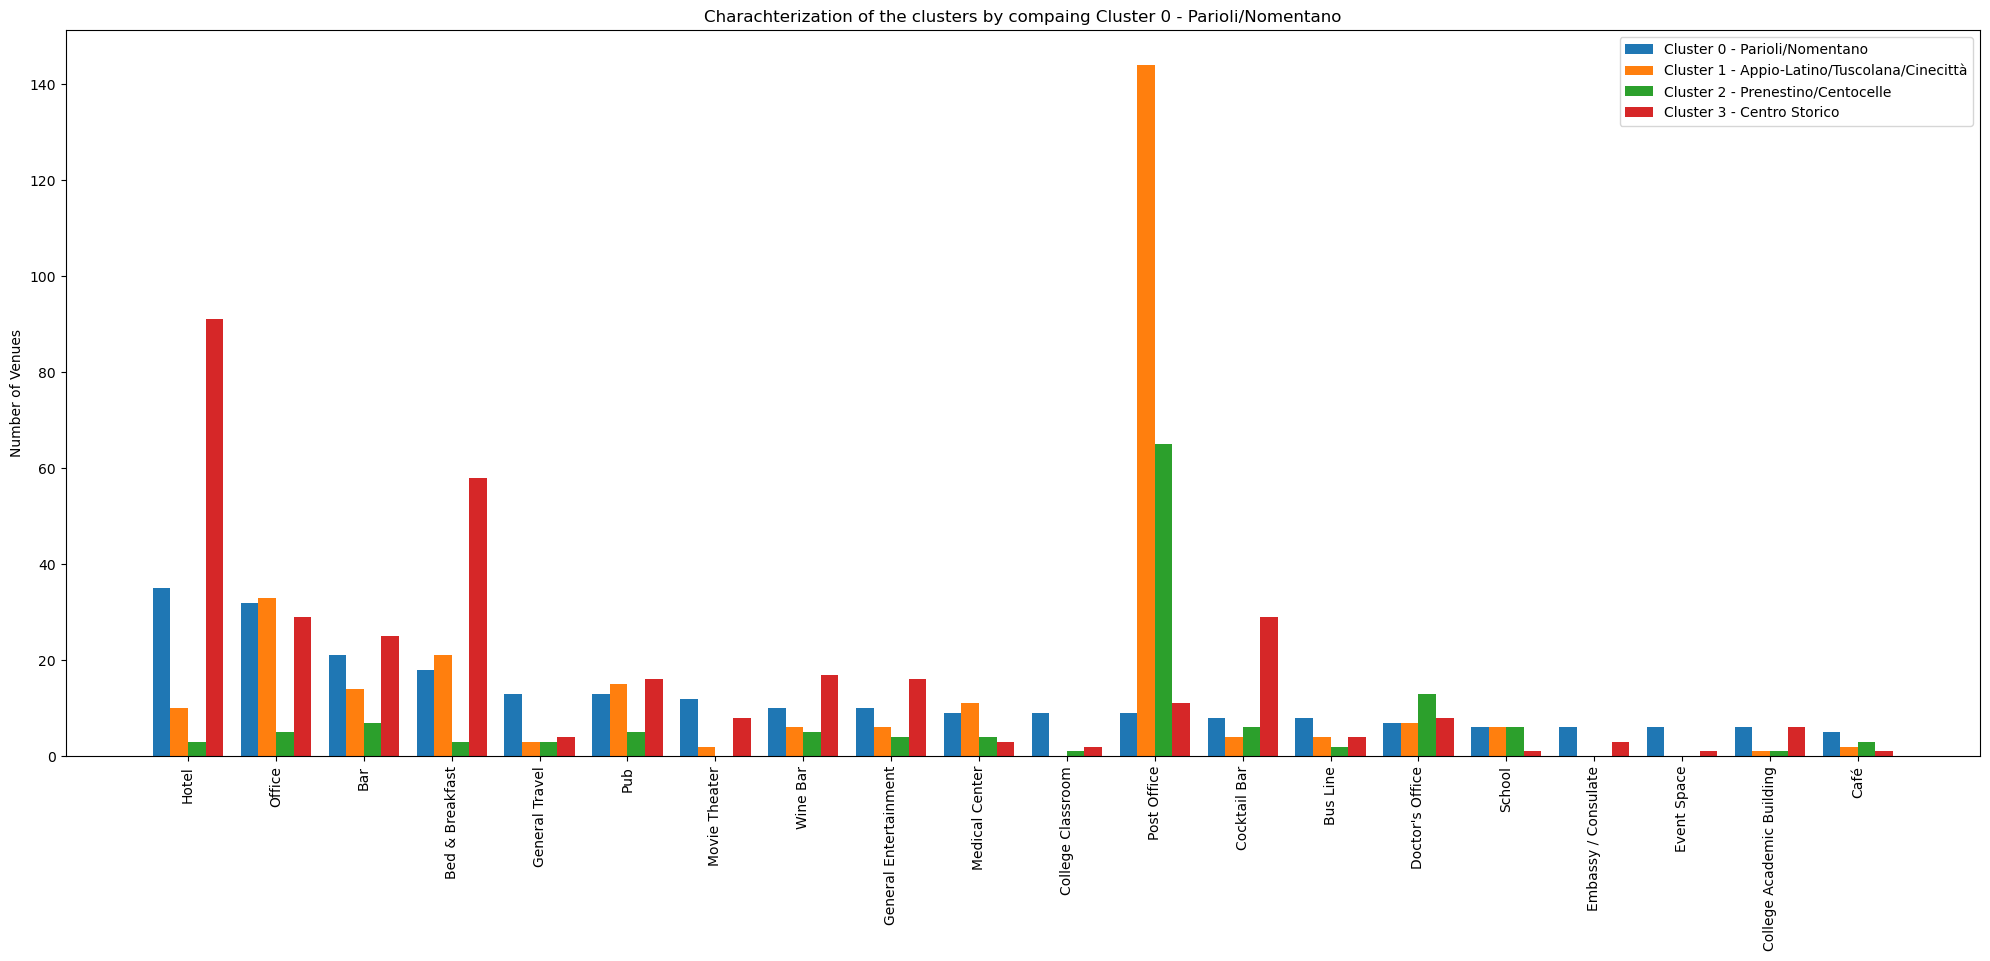

In [167]:
set_1 = test_df.sort_values(test_df.columns[0], ascending=False).head(20)

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Cluster 0 - Parioli/Nomentano')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Cluster 1 - Appio-Latino/Tuscolana/Cinecittà')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Cluster 2 - Prenestino/Centocelle')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='Cluster 3 - Centro Storico')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Cluster 0 - Parioli/Nomentano')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

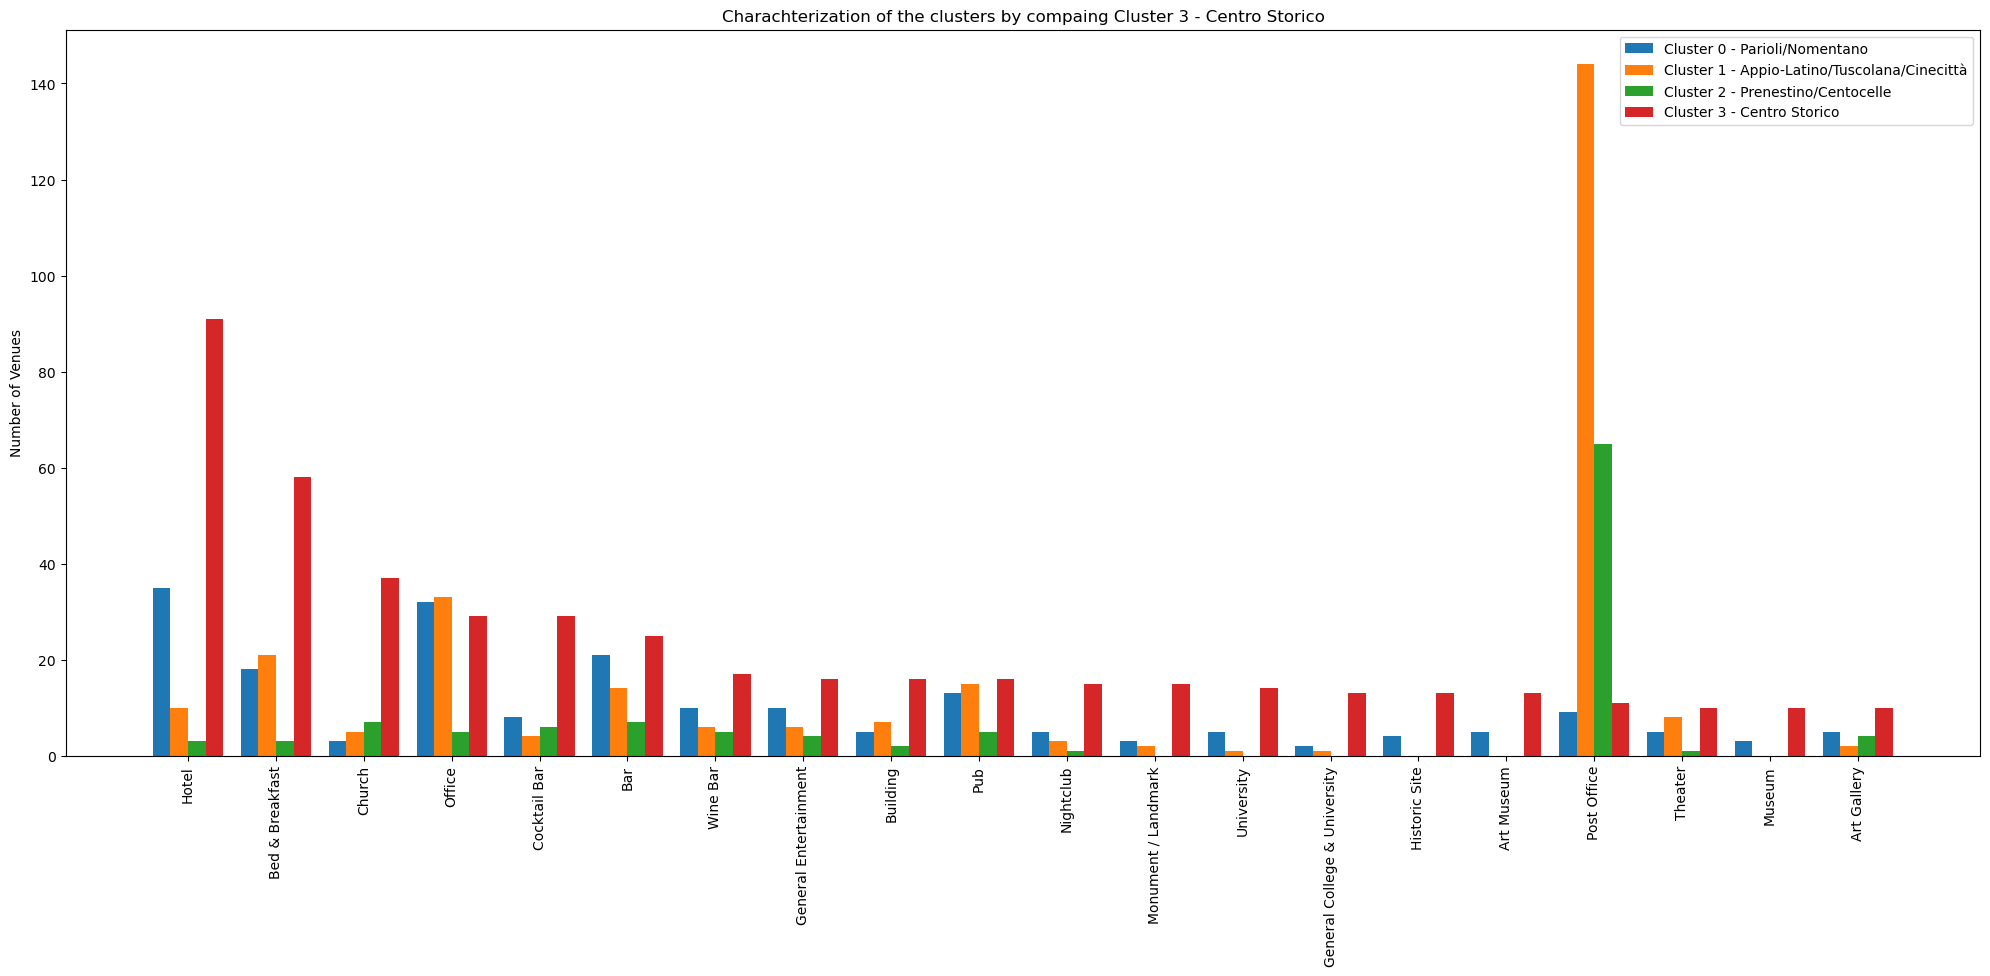

In [170]:
set_1 = test_df.sort_values(test_df.columns[3], ascending=False).head(20)

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Cluster 0 - Parioli/Nomentano')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Cluster 1 - Appio-Latino/Tuscolana/Cinecittà')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Cluster 2 - Prenestino/Centocelle')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='Cluster 3 - Centro Storico')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Cluster 3 - Centro Storico')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

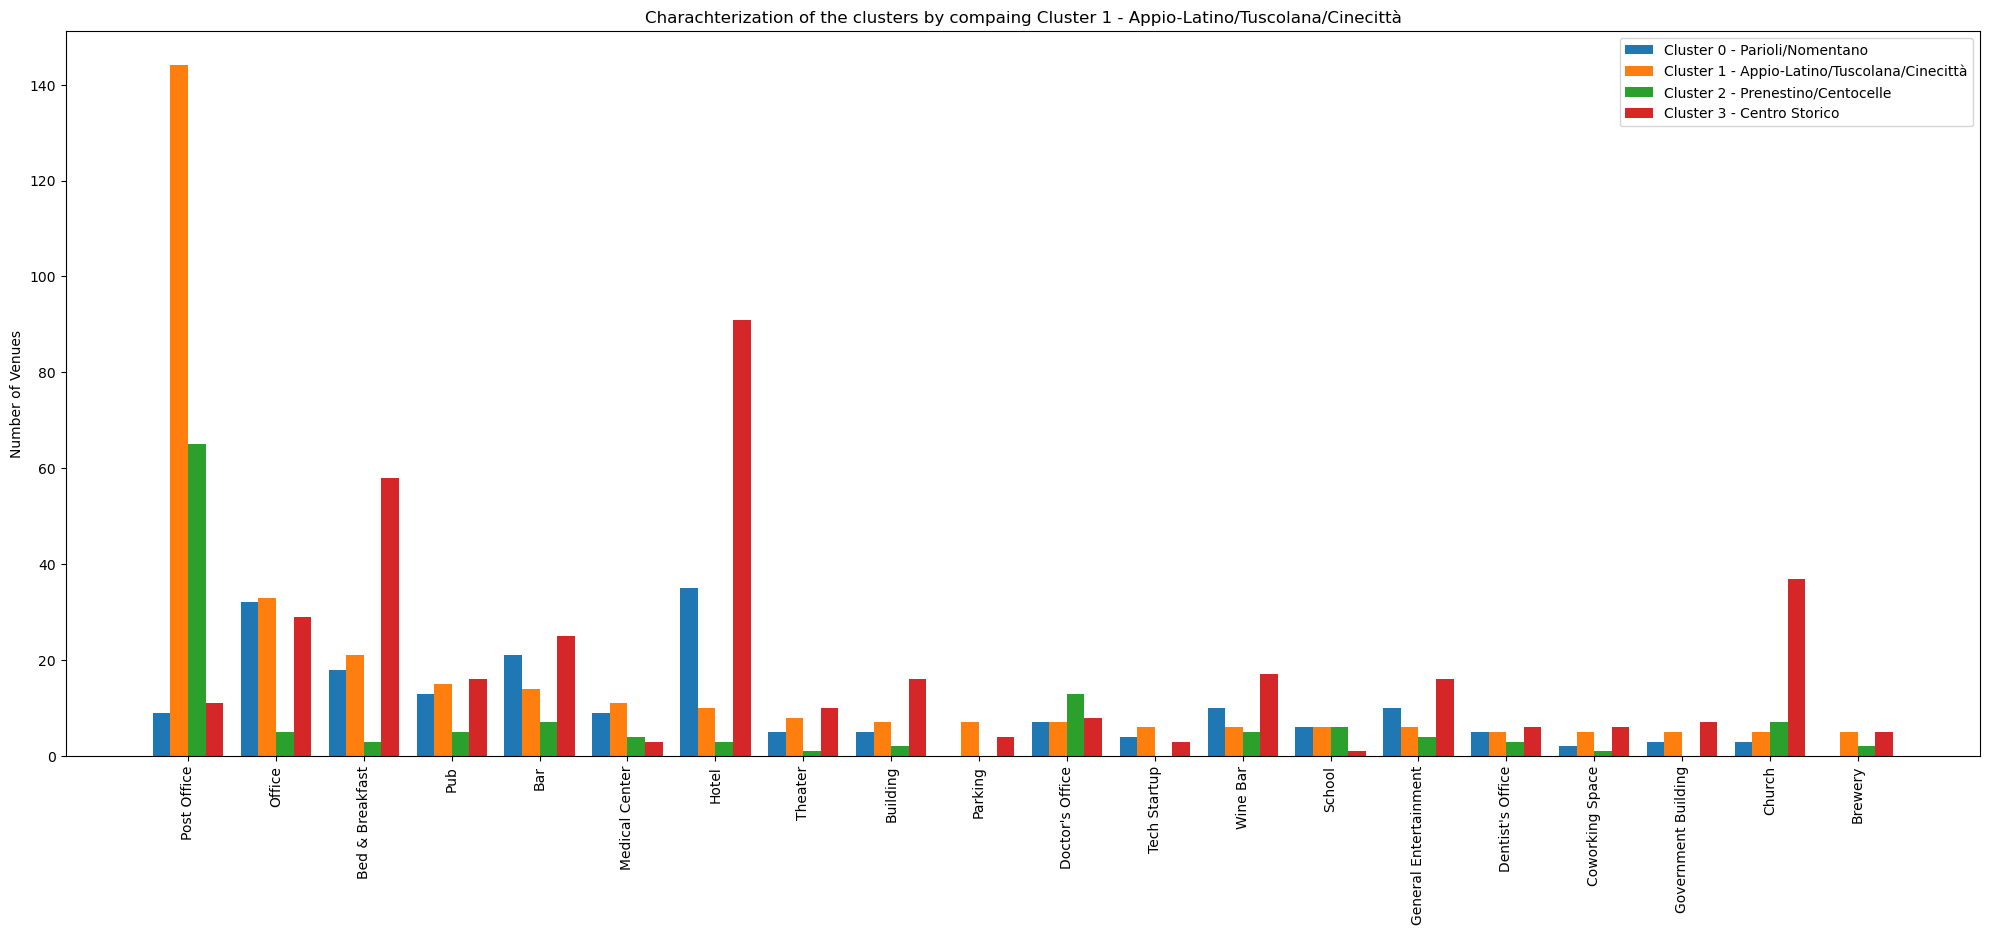

In [168]:
set_1 = test_df.sort_values(test_df.columns[1], ascending=False).head(20)

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Cluster 0 - Parioli/Nomentano')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Cluster 1 - Appio-Latino/Tuscolana/Cinecittà')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Cluster 2 - Prenestino/Centocelle')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='Cluster 3 - Centro Storico')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Cluster 1 - Appio-Latino/Tuscolana/Cinecittà')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

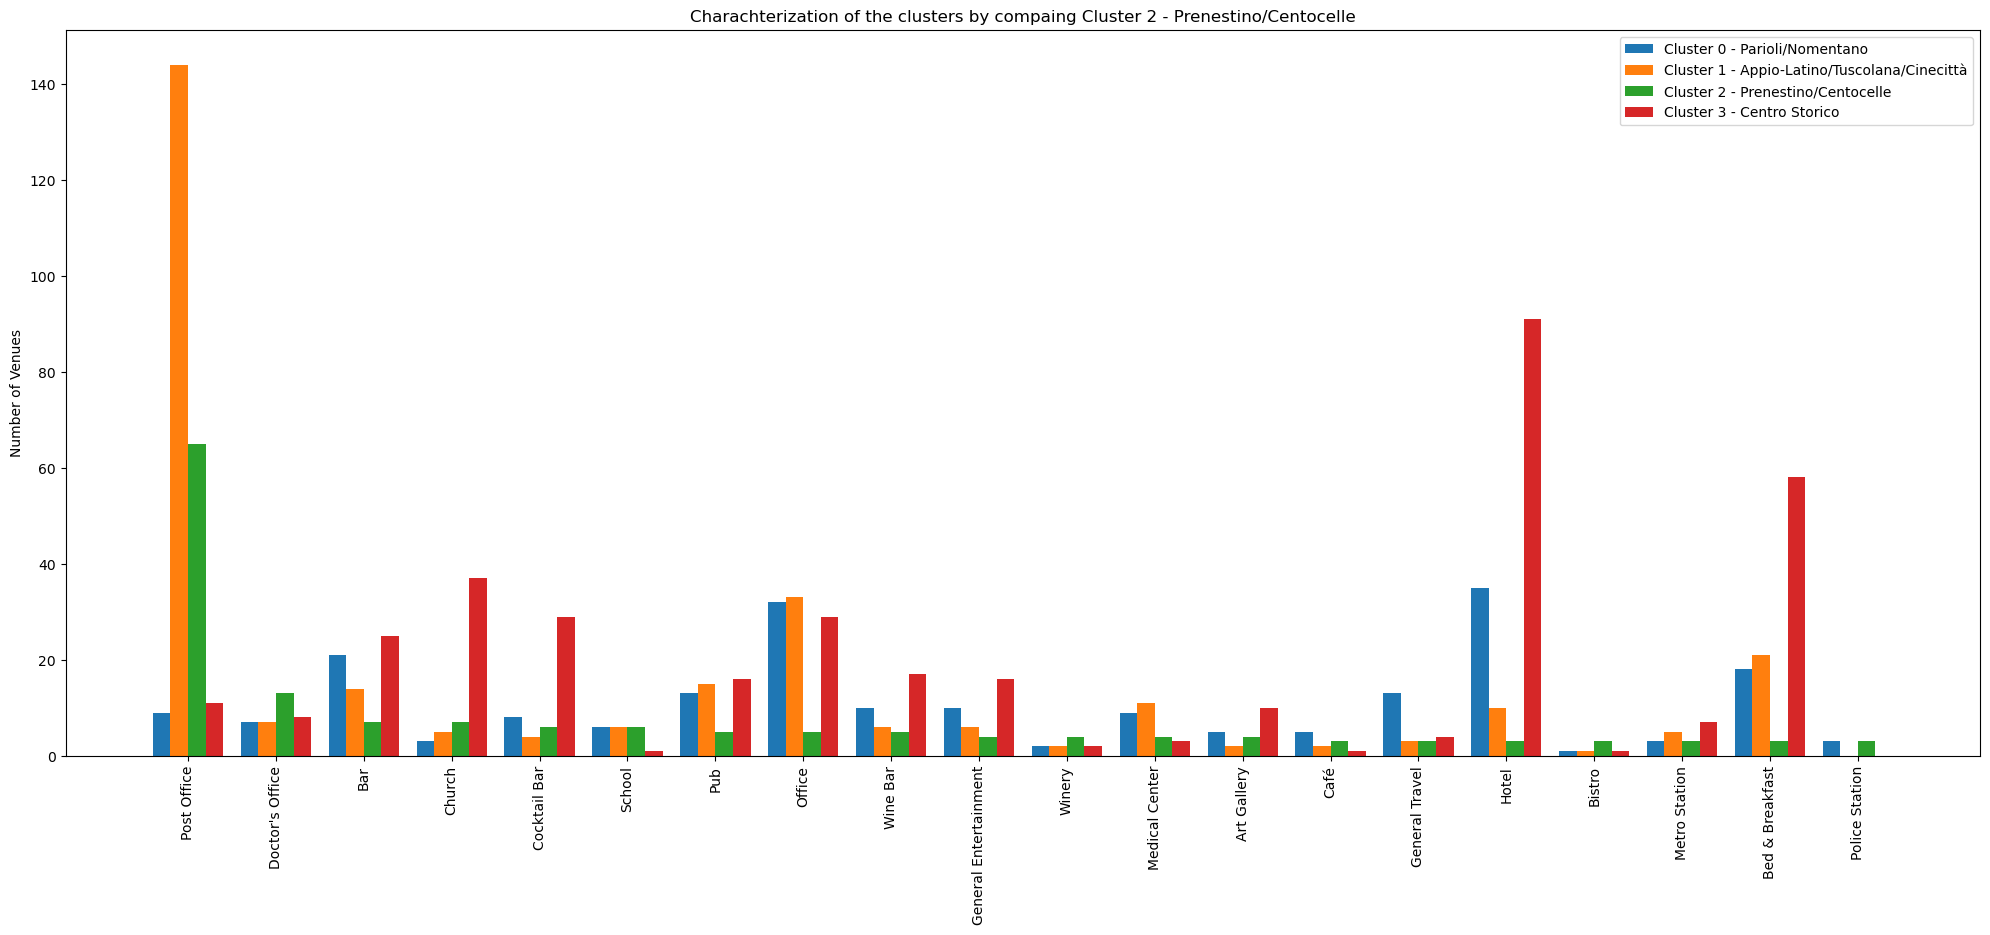

In [169]:
set_1 = test_df.sort_values(test_df.columns[2], ascending=False).head(20)

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Cluster 0 - Parioli/Nomentano')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Cluster 1 - Appio-Latino/Tuscolana/Cinecittà')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Cluster 2 - Prenestino/Centocelle')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='Cluster 3 - Centro Storico')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Cluster 2 - Prenestino/Centocelle')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

## Chosing the location of the Japanese Restaurant is tricky. Both Centro Storico and Parioli/Nomentano are very wealthy and dense with people. I think Centro Storico would be a better option because it is probably more alive during dinner and night time and also it has only 13 Japanese Restaurants compared to the 22 in Parioli/Nomentano

## Now, I am applying the same principale to the "Zone Urbana" of our interest and see which one is more suitable for both the Japanese and Chinese Restaurants.

In [147]:
Testaccio_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'Testaccio']
Eroi_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'Eroi']
Flaminio_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'Flaminio']
San_Lorenzo_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'S. Lorenzo']
Gordiani_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'Gordiani']
Appio_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'Appio']
Latino_df = Venues_grouped_df.loc[Venues_grouped_df['Denominazione'] == 'Latino']
frames = [Eroi_df,Testaccio_df,Flaminio_df,San_Lorenzo_df]
frames2 = [Gordiani_df,Appio_df,Latino_df]

In [148]:
temp_df = pd.concat(frames)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_Eroi_df = temp_df.sort_values('Eroi', ascending=False).head(10)
Top10_Eroi_df

Denominazione    Eroi  Testaccio  Flaminio  S. Lorenzo
Hotel               8          0         7           4
Bed & Breakfast     5          3         0           1
Building            3          1         0           0
Medical Center      2          0         2           0
College Gym         2          0         0           0
Pub                 2          1         1           4
Bar                 2          2         0           4
Doctor's Office     2          0         0           1
Hospital            1          0         0           0
Pizza Place         1          0         0           0

In [149]:
temp_df = pd.concat(frames)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_Testaccio_df = temp_df.sort_values('Testaccio', ascending=False).head(10)
Top10_Testaccio_df

Denominazione          Eroi  Testaccio  Flaminio  S. Lorenzo
Nightclub                 0          6         0           1
Theater                   0          5         1           0
General Entertainment     1          3         2           1
Bed & Breakfast           5          3         0           1
Office                    1          2         4           3
Cocktail Bar              1          2         1           1
Art Gallery               0          2         0           0
Art Museum                0          2         1           0
Bus Line                  1          2         1           0
Museum                    0          2         0           0

In [150]:
temp_df = pd.concat(frames)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_Flaminio_df = temp_df.sort_values('Flaminio', ascending=False).head(10)
Top10_Flaminio_df

Denominazione          Eroi  Testaccio  Flaminio  S. Lorenzo
Hotel                     8          0         7           4
Office                    1          2         4           3
Bus Stop                  0          1         2           0
Medical Center            2          0         2           0
Library                   1          1         2           0
General Entertainment     1          3         2           1
School                    0          0         1           0
Student Center            0          0         1           0
Beer Garden               0          1         1           1
Bus Line                  1          2         1           0

In [151]:
temp_df = pd.concat(frames)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_San_Lorenzo_df = temp_df.sort_values('S. Lorenzo', ascending=False).head(10)
Top10_San_Lorenzo_df

Denominazione      Eroi  Testaccio  Flaminio  S. Lorenzo
Hotel                 8          0         7           4
Rock Club             0          0         0           4
Pub                   2          1         1           4
Bar                   2          2         0           4
Office                1          2         4           3
Other Nightlife       1          0         0           3
Beer Bar              0          0         0           2
College Classroom     0          0         0           2
Event Space           0          1         0           2
Music Venue           0          0         0           2

In [152]:
temp_df = pd.concat(frames2)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_Gordiani_df = temp_df.sort_values('Gordiani', ascending=False).head(10)
Top10_Gordiani_df

Denominazione    Gordiani  Appio  Latino
Post Office            16     12      36
Doctor's Office         5      2       0
Social Club             2      0       0
Bar                     2      3       0
Hospital                1      0       1
Medical Lab             1      0       0
Bus Line                1      0       0
Art Gallery             1      1       1
Veterinarian            1      0       0
School                  1      2       0

In [153]:
temp_df = pd.concat(frames2)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_Appio_df = temp_df.sort_values('Appio', ascending=False).head(10)
Top10_Appio_df

Denominazione    Gordiani  Appio  Latino
Post Office            16     12      36
Bed & Breakfast         0      6       1
Office                  0      5       2
Hotel                   0      4       0
Pub                     0      3       2
Non-Profit              0      3       0
Bar                     2      3       0
Doctor's Office         5      2       0
School                  1      2       0
Music School            0      2       0

In [154]:
temp_df = pd.concat(frames2)
temp_df = temp_df.reset_index()
temp_df = temp_df.set_index('Denominazione')
temp_df.drop(columns='Municipio', axis=1, inplace=True)
temp_df.drop(columns='Cluster Labels', axis=1, inplace=True)
temp_df.drop(columns='index', axis=1, inplace=True)
temp_df = temp_df.transpose()
Top10_Latino_df = temp_df.sort_values('Latino', ascending=False).head(10)
Top10_Latino_df

Denominazione          Gordiani  Appio  Latino
Post Office                  16     12      36
Medical Center                0      1       3
Brewery                       0      0       2
Pub                           0      3       2
Tech Startup                  0      1       2
Office                        0      5       2
Hospital                      1      0       1
General Entertainment         0      1       1
Bed & Breakfast               0      6       1
Travel Agency                 0      0       1

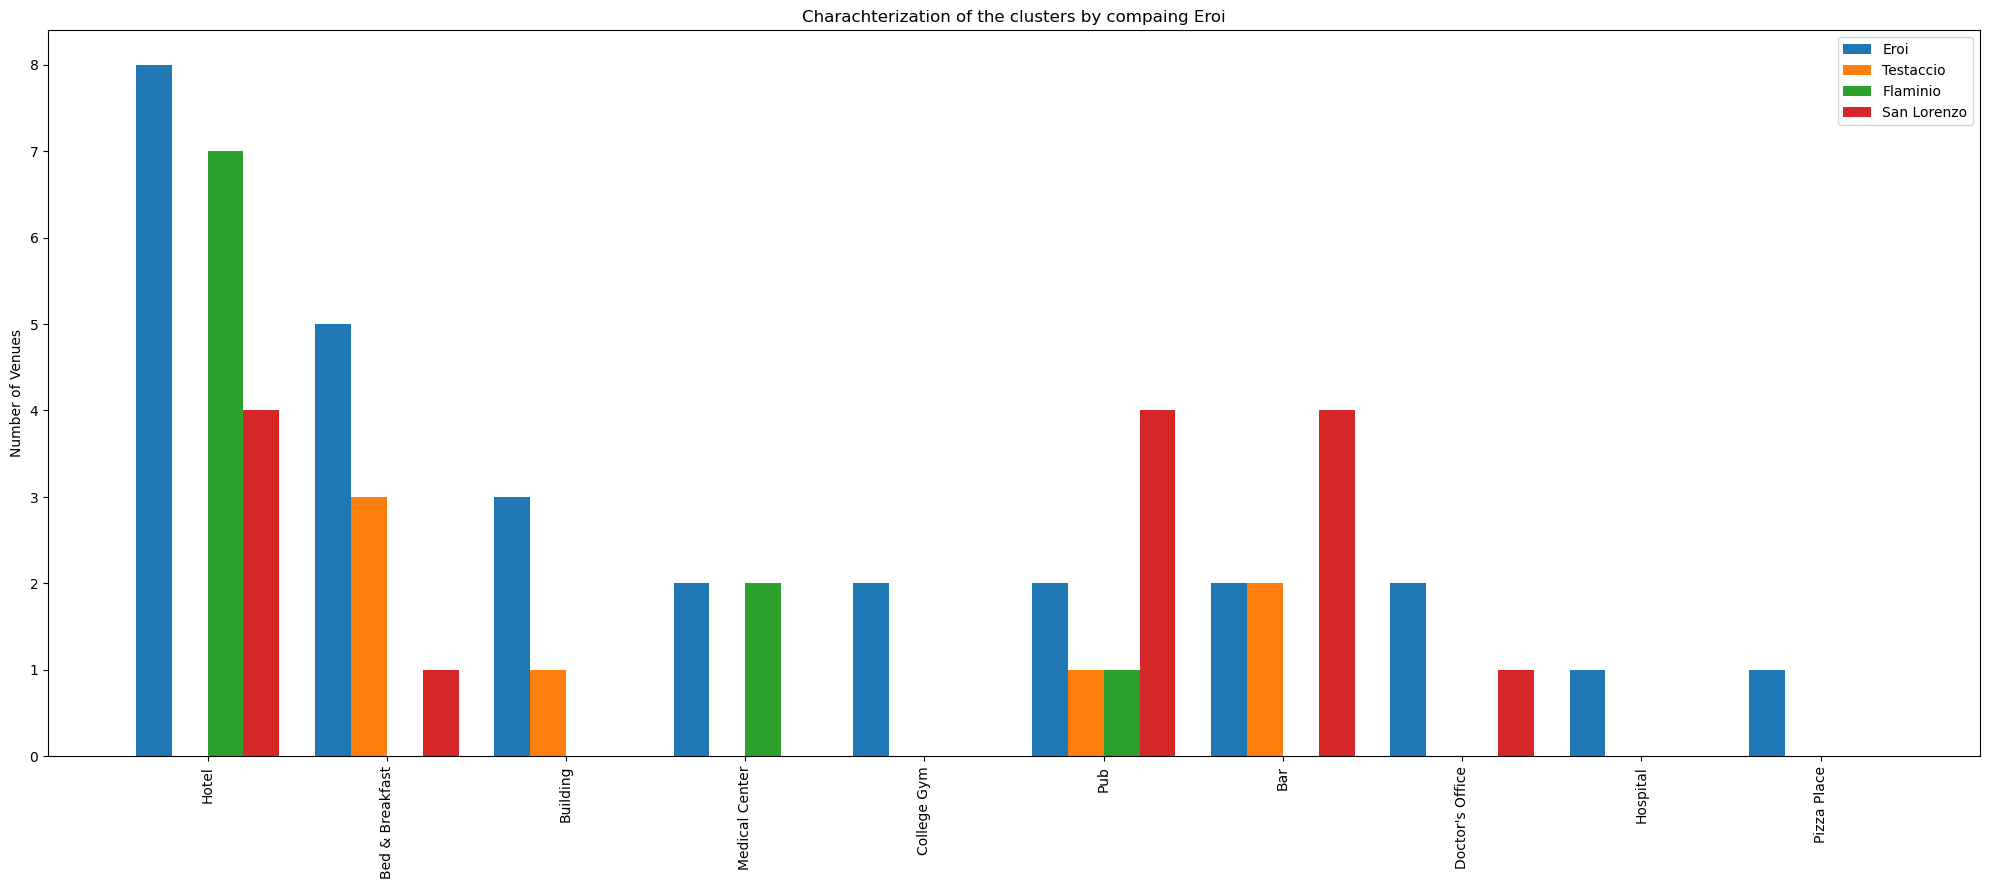

In [179]:
set_1 = Top10_Eroi_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Eroi')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Testaccio')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Flaminio')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Eroi')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

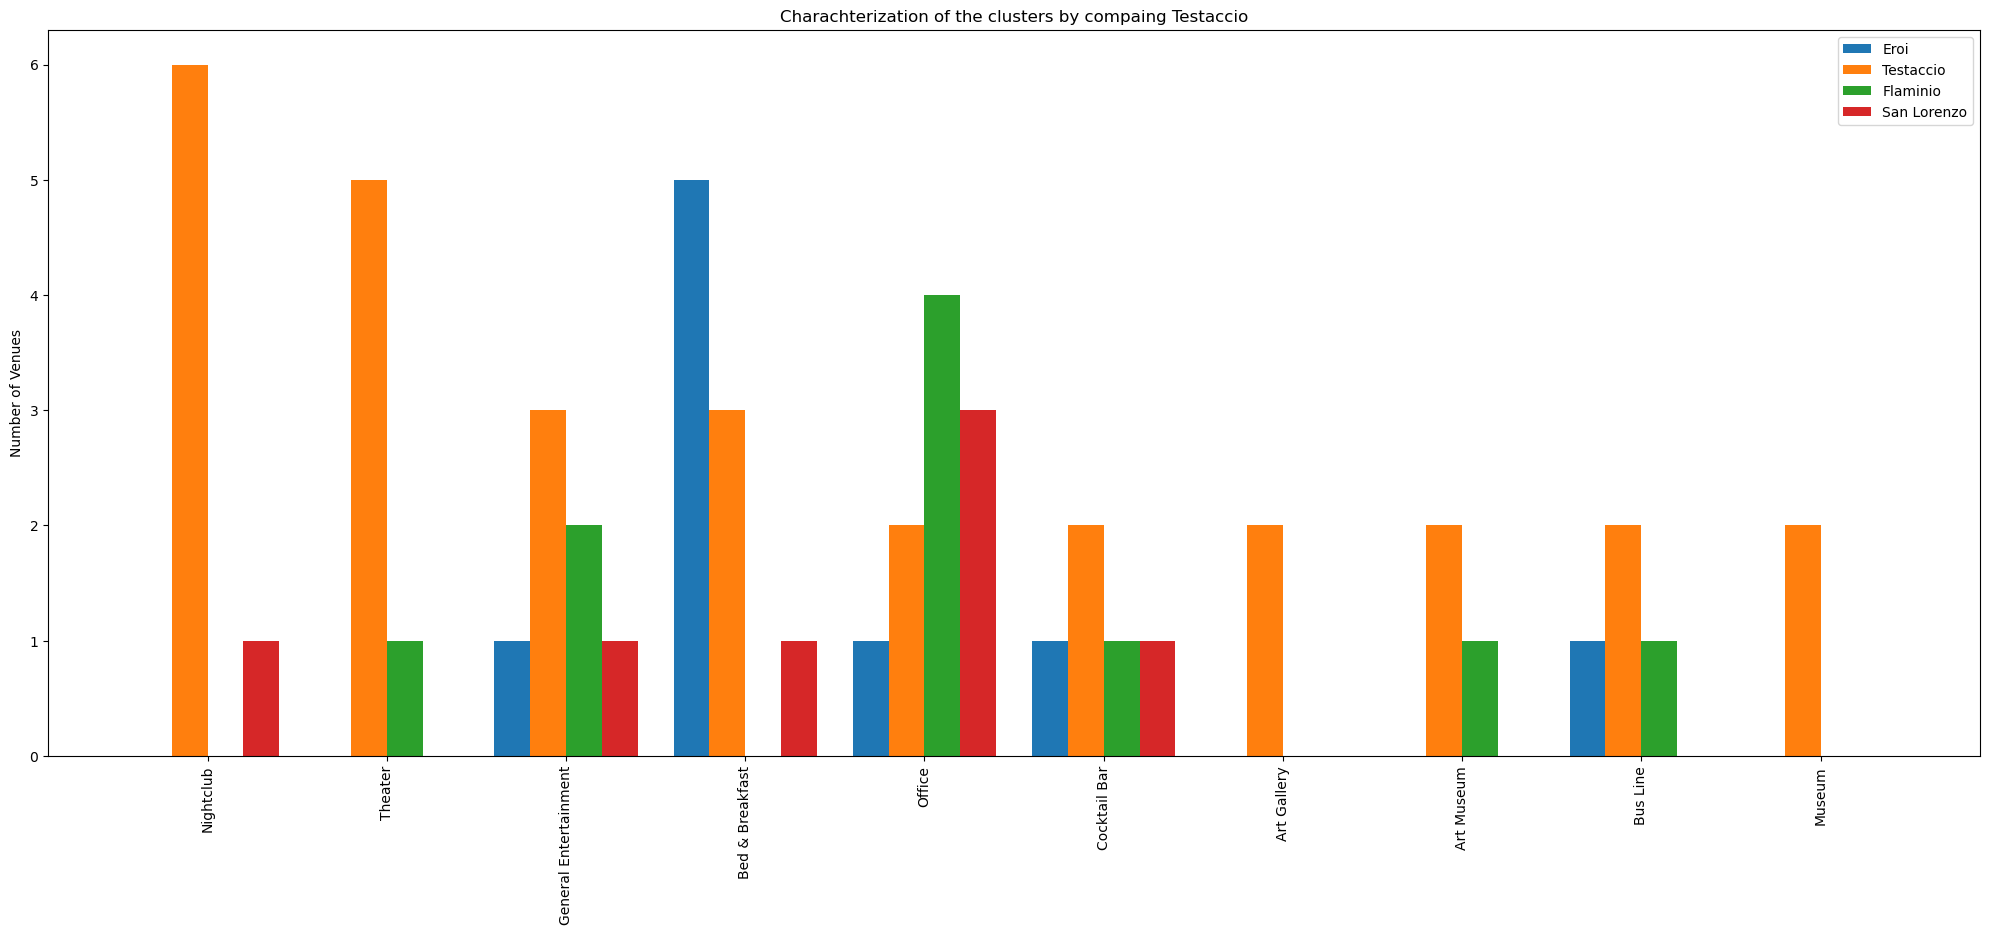

In [178]:
set_1 = Top10_Testaccio_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Eroi')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Testaccio')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Flaminio')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Testaccio')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

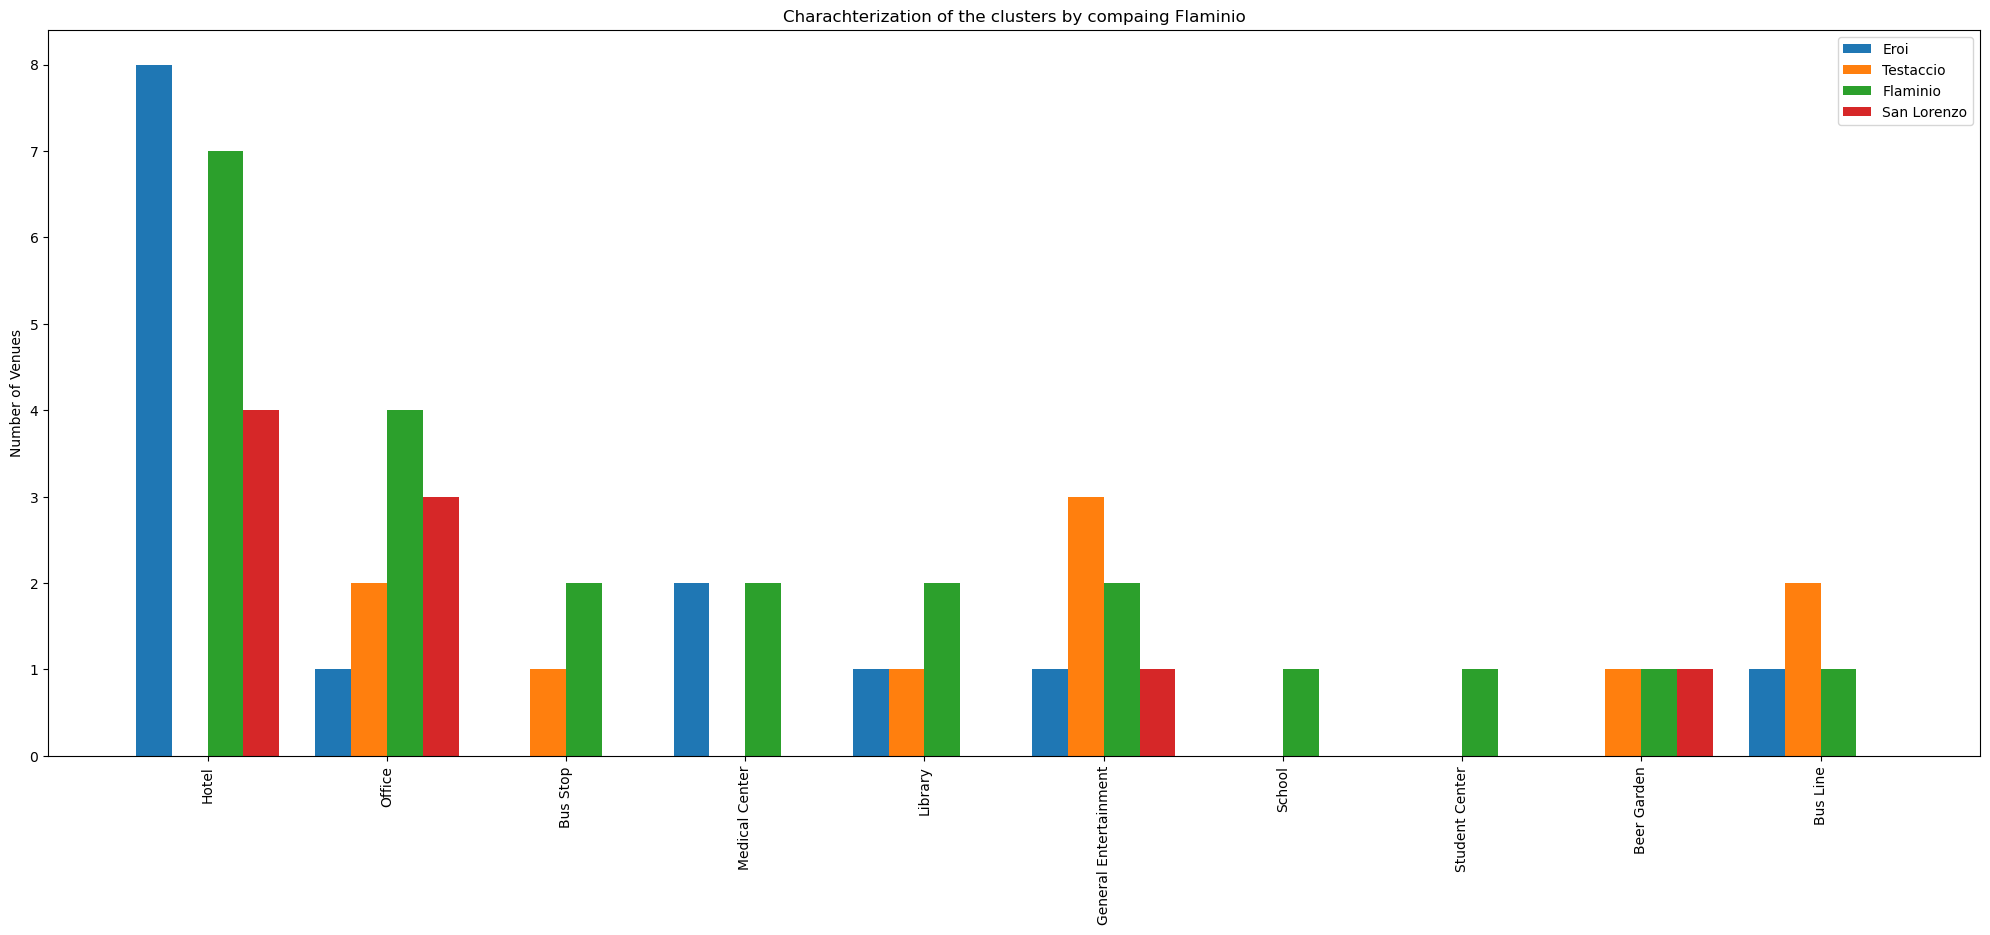

In [180]:
set_1 = Top10_Flaminio_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Eroi')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Testaccio')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Flaminio')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Flaminio')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

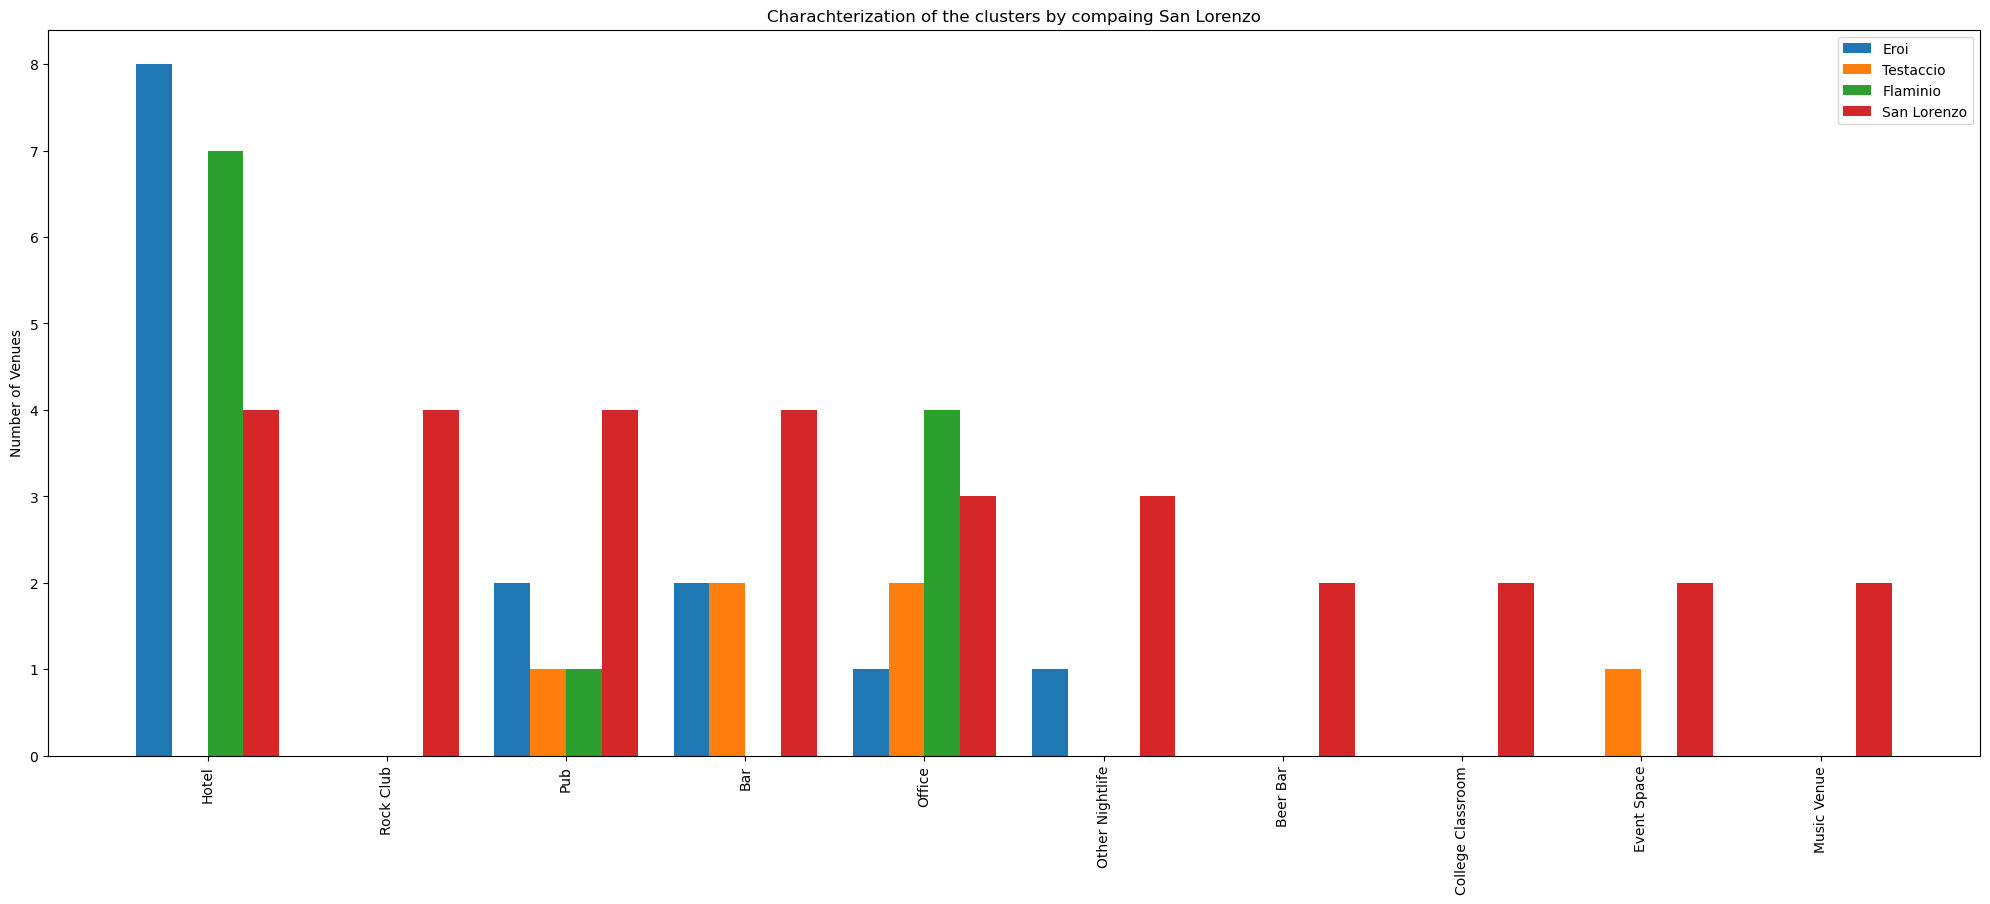

In [181]:
set_1 = Top10_San_Lorenzo_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, set_1[set_1.columns[0]], width, label='Eroi')
rects2 = ax.bar(x - width/2, set_1[set_1.columns[1]], width, label='Testaccio')
rects3 = ax.bar(x + width/2, set_1[set_1.columns[2]], width, label='Flaminio')
rects4 = ax.bar(x + 3*width/2, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing San Lorenzo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

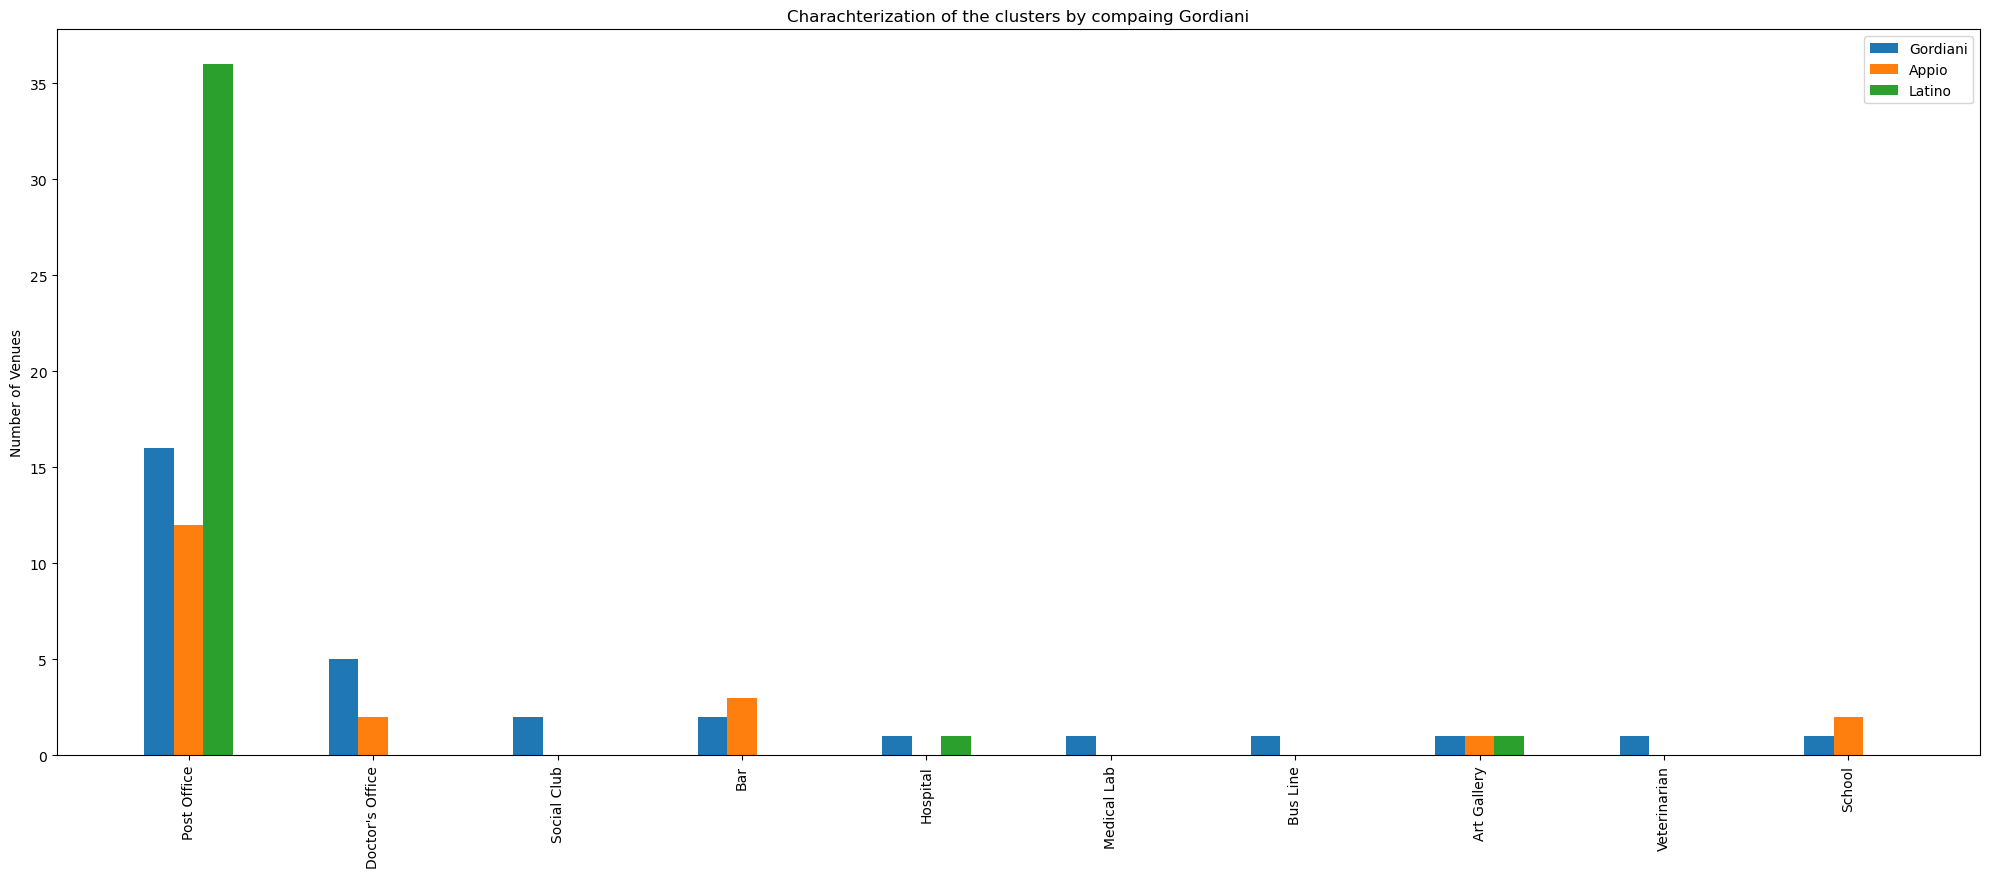

In [174]:
set_1 = Top10_Gordiani_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, set_1[set_1.columns[0]], width, label='Gordiani')
rects2 = ax.bar(x, set_1[set_1.columns[1]], width, label='Appio')
rects3 = ax.bar(x + width, set_1[set_1.columns[2]], width, label='Latino')
#rects4 = ax.bar(x + 2*width, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Gordiani')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

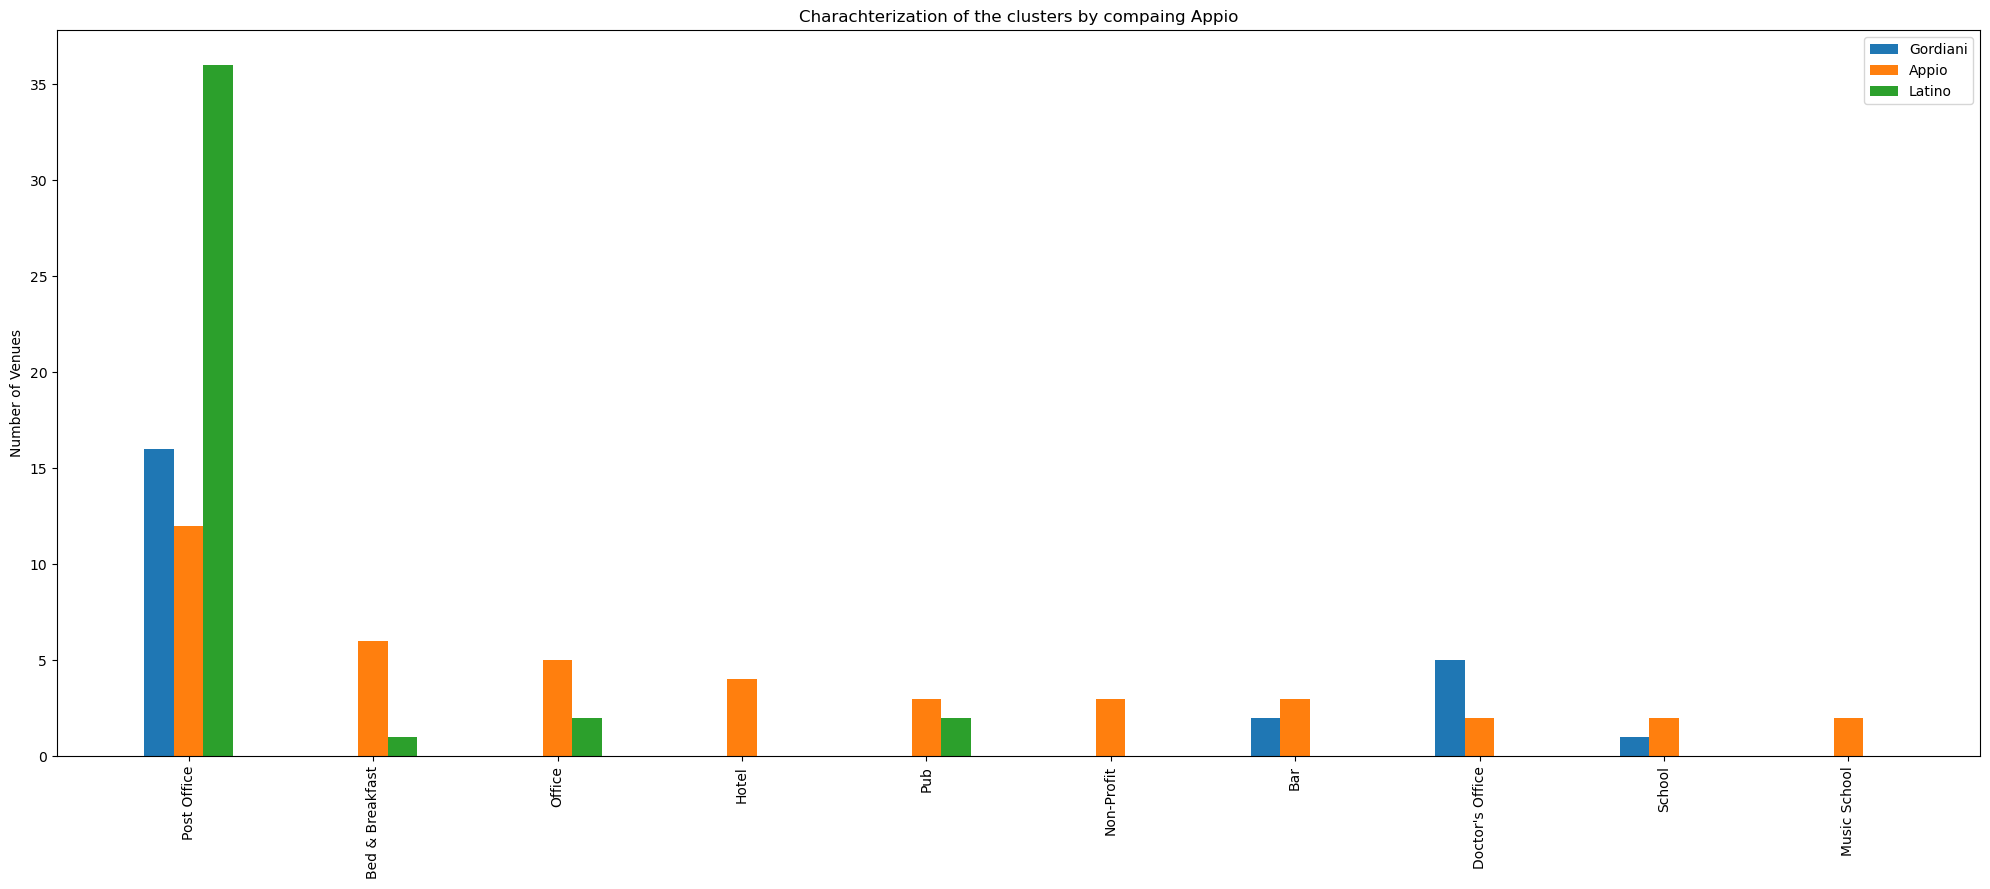

In [176]:
set_1 = Top10_Appio_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, set_1[set_1.columns[0]], width, label='Gordiani')
rects2 = ax.bar(x, set_1[set_1.columns[1]], width, label='Appio')
rects3 = ax.bar(x + width, set_1[set_1.columns[2]], width, label='Latino')
#rects4 = ax.bar(x + 2*width, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Appio')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

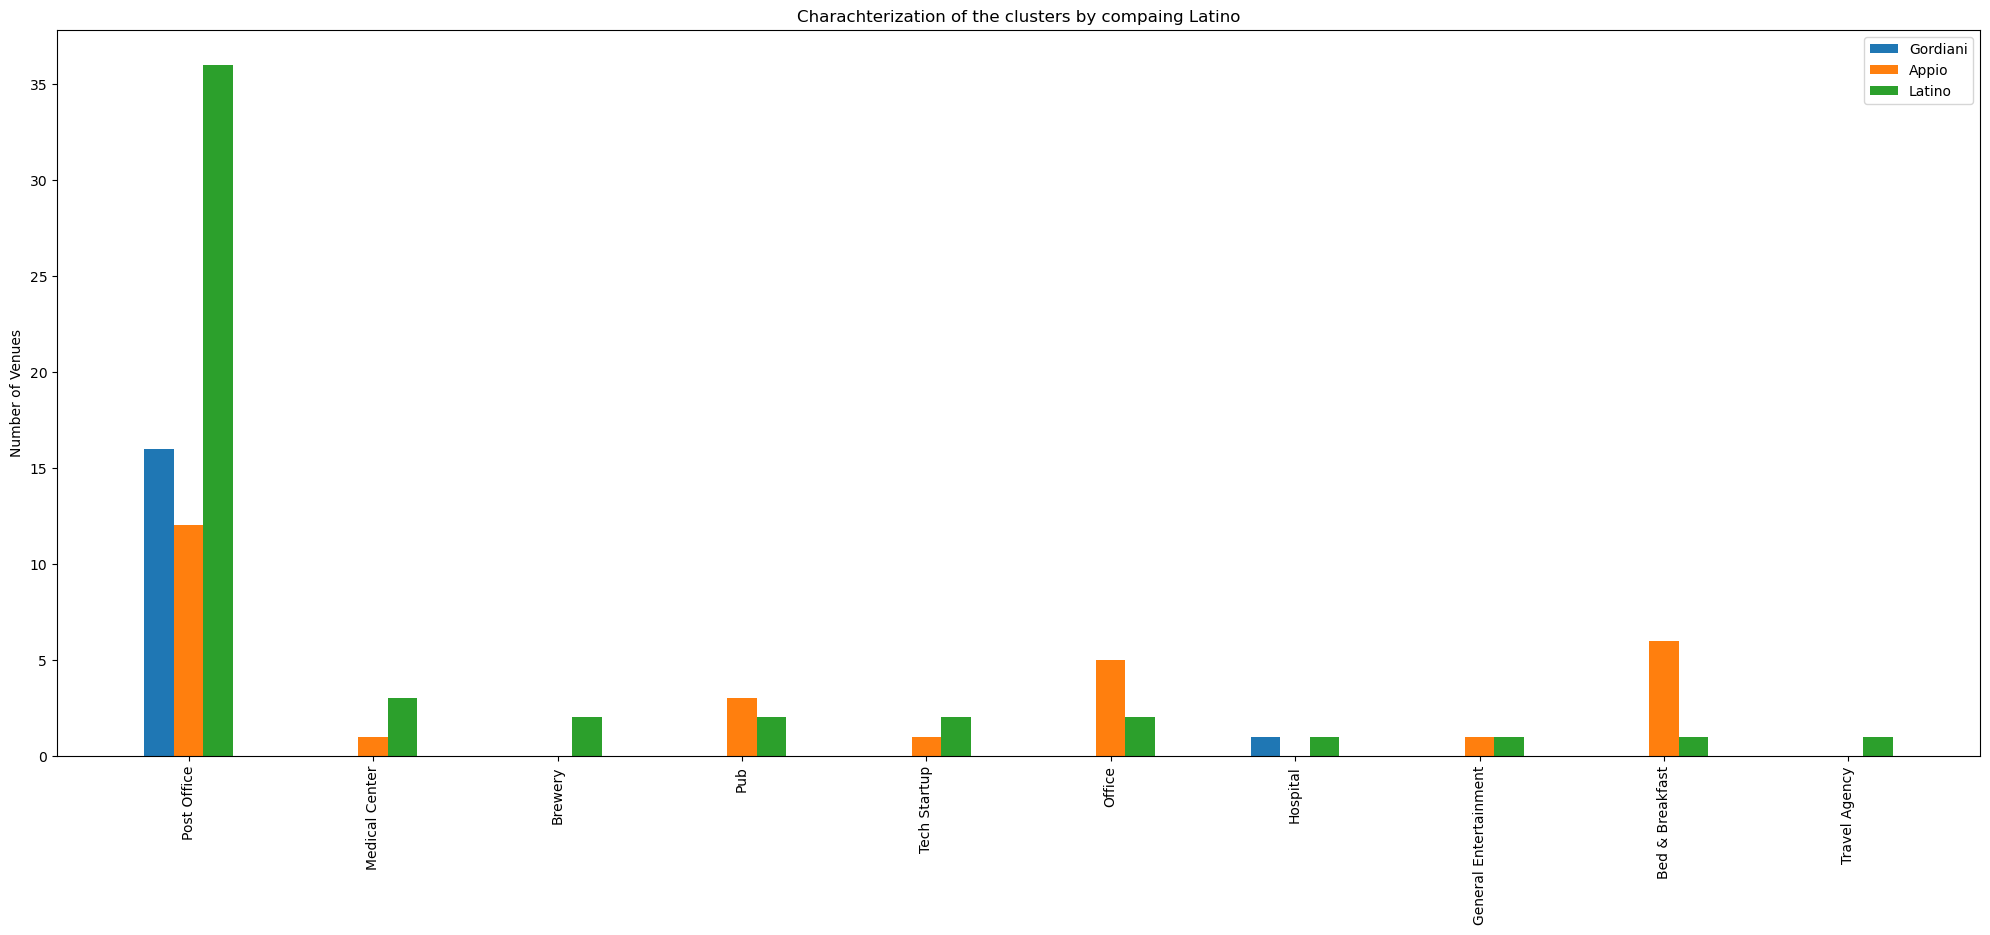

In [177]:
set_1 = Top10_Latino_df

labels = set_1.index

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, set_1[set_1.columns[0]], width, label='Gordiani')
rects2 = ax.bar(x, set_1[set_1.columns[1]], width, label='Appio')
rects3 = ax.bar(x + width, set_1[set_1.columns[2]], width, label='Latino')
#rects4 = ax.bar(x + 2*width, set_1[set_1.columns[3]], width, label='San Lorenzo')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Charachterization of the clusters by compaing Latino')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
#ax.bar_label(rects4, padding=3)

fig.tight_layout()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

# Finally some answers!!
## Testaccio seems the best option for the Luxury Japanese Area:
## - It is in a wealthy area, quite crowed, it has no Japanese Restaurants and compared to Eroi it has more night life, art museum and general entertainment, while Eroi seems more residential.

## Appio seems the best option for the 'All you can eat' Chinese Restaurant:
## - It is more crowed than Latino, it has only one Chinese Restaurant and tend to have more night life and activity.